# Train Ensemble of LSTM Networks on Simulated Training Set

Epoch 1/2000
118/118 [==============================] - ETA: 0s - loss: -1.2747

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel1/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel1/assets


118/118 [==============================] - 34s 263ms/step - loss: -1.2747 - val_loss: -1.4664
Epoch 2/2000
118/118 [==============================] - ETA: 0s - loss: -2.2731

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel1/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel1/assets


118/118 [==============================] - 28s 241ms/step - loss: -2.2731 - val_loss: -2.4835
Epoch 3/2000
118/118 [==============================] - 22s 183ms/step - loss: -2.7825 - val_loss: -2.4663
Epoch 4/2000
118/118 [==============================] - 22s 183ms/step - loss: -3.1102 - val_loss: -1.2524
Epoch 5/2000
118/118 [==============================] - ETA: 0s - loss: -3.2465

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel1/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel1/assets


118/118 [==============================] - 29s 243ms/step - loss: -3.2465 - val_loss: -3.0826
Epoch 6/2000
118/118 [==============================] - ETA: 0s - loss: -3.4907

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel1/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel1/assets


118/118 [==============================] - 29s 243ms/step - loss: -3.4907 - val_loss: -3.3258
Epoch 7/2000
118/118 [==============================] - 22s 183ms/step - loss: -3.6265 - val_loss: -1.0763
Epoch 8/2000
118/118 [==============================] - 22s 184ms/step - loss: -3.7078 - val_loss: -2.6624
Epoch 9/2000
118/118 [==============================] - 22s 183ms/step - loss: -3.7823 - val_loss: -3.2689
Epoch 10/2000
118/118 [==============================] - 22s 183ms/step - loss: -3.8631 - val_loss: -2.1453
Epoch 11/2000
118/118 [==============================] - ETA: 0s - loss: -3.6168

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel1/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel1/assets


118/118 [==============================] - 29s 248ms/step - loss: -3.6168 - val_loss: -3.4154
Epoch 12/2000
118/118 [==============================] - ETA: 0s - loss: -3.8738

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel1/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel1/assets


118/118 [==============================] - 29s 248ms/step - loss: -3.8738 - val_loss: -3.4724
Epoch 13/2000
118/118 [==============================] - 22s 183ms/step - loss: -3.9454 - val_loss: -2.9679
Epoch 14/2000
118/118 [==============================] - 21s 182ms/step - loss: -3.6707 - val_loss: -2.9112
Epoch 15/2000
118/118 [==============================] - 22s 183ms/step - loss: -3.8673 - val_loss: -3.4346
Epoch 16/2000
118/118 [==============================] - 22s 183ms/step - loss: -3.9829 - val_loss: -1.3262
Epoch 17/2000
118/118 [==============================] - 21s 181ms/step - loss: -4.0443 - val_loss: -2.9189
Epoch 18/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.1509 - val_loss: -3.3645
Epoch 19/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.1570 - val_loss: -1.8739
Epoch 20/2000
118/118 [==============================] - ETA: 0s - loss: -4.1303

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel1/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel1/assets


118/118 [==============================] - 29s 245ms/step - loss: -4.1303 - val_loss: -3.8029
Epoch 21/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.1542 - val_loss: -2.9874
Epoch 22/2000
118/118 [==============================] - 21s 180ms/step - loss: -4.2234 - val_loss: -3.7412
Epoch 23/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.1434 - val_loss: -3.0744
Epoch 24/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.2664 - val_loss: -2.7363
Epoch 25/2000
118/118 [==============================] - 21s 181ms/step - loss: -4.2321 - val_loss: -3.6640
Epoch 26/2000
118/118 [==============================] - ETA: 0s - loss: -4.3382

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel1/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel1/assets


118/118 [==============================] - 28s 239ms/step - loss: -4.3382 - val_loss: -3.8321
Epoch 27/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.2251 - val_loss: -3.5657
Epoch 28/2000
118/118 [==============================] - ETA: 0s - loss: -4.2654

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel1/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel1/assets


118/118 [==============================] - 30s 251ms/step - loss: -4.2654 - val_loss: -3.8539
Epoch 29/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.2969 - val_loss: -3.7602
Epoch 30/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.3691 - val_loss: -3.7683
Epoch 31/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.0952 - val_loss: -3.6038
Epoch 32/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.3727 - val_loss: -0.5989
Epoch 33/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.3623 - val_loss: -3.7807
Epoch 34/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.3675 - val_loss: -3.5533
Epoch 35/2000
118/118 [==============================] - 22s 182ms/step - loss: -4.4134 - val_loss: -3.3958
Epoch 36/2000
118/118 [==============================] - ETA: 0s - loss: -4.4488

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel1/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel1/assets


118/118 [==============================] - 28s 237ms/step - loss: -4.4488 - val_loss: -4.0986
Epoch 37/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.4130 - val_loss: -3.9569
Epoch 38/2000
118/118 [==============================] - 22s 182ms/step - loss: -4.4239 - val_loss: -3.9182
Epoch 39/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.4828 - val_loss: -3.9030
Epoch 40/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.4790 - val_loss: -4.0192
Epoch 41/2000
118/118 [==============================] - 22s 182ms/step - loss: -4.0210 - val_loss: -4.0205
Epoch 42/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.3245 - val_loss: -3.7981
Epoch 43/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.3591 - val_loss: -3.7191
Epoch 44/2000
118/118 [==============================] - 21s 179ms/step - loss: -4.3335 - val_loss: -3.6723
Epoch 45/2000
118/118 [===================

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel1/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel1/assets


118/118 [==============================] - 30s 251ms/step - loss: -4.5634 - val_loss: -4.1117
Epoch 68/2000
118/118 [==============================] - ETA: 0s - loss: -4.6087

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel1/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel1/assets


118/118 [==============================] - 29s 243ms/step - loss: -4.6087 - val_loss: -4.1392
Epoch 69/2000
118/118 [==============================] - 21s 182ms/step - loss: -4.6555 - val_loss: 3.5009
Epoch 70/2000
118/118 [==============================] - 21s 182ms/step - loss: -4.6090 - val_loss: -3.7209
Epoch 71/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.6120 - val_loss: -2.8408
Epoch 72/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.5801 - val_loss: -1.4937
Epoch 73/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.0789 - val_loss: -4.1280
Epoch 74/2000
118/118 [==============================] - ETA: 0s - loss: -4.5404

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel1/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel1/assets


118/118 [==============================] - 28s 240ms/step - loss: -4.5404 - val_loss: -4.1733
Epoch 75/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.5101 - val_loss: -3.9119
Epoch 76/2000
118/118 [==============================] - ETA: 0s - loss: -4.6745

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel1/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel1/assets


118/118 [==============================] - 30s 251ms/step - loss: -4.6745 - val_loss: -4.2092
Epoch 77/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.4459 - val_loss: -3.7271
Epoch 78/2000
118/118 [==============================] - 21s 182ms/step - loss: -4.6350 - val_loss: -3.0128
Epoch 79/2000
118/118 [==============================] - 21s 181ms/step - loss: -4.5013 - val_loss: -2.9392
Epoch 80/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.5136 - val_loss: -3.7600
Epoch 81/2000
118/118 [==============================] - 21s 180ms/step - loss: -4.6113 - val_loss: -3.8333
Epoch 82/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.5235 - val_loss: -4.1393
Epoch 83/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.6595 - val_loss: -4.1370
Epoch 84/2000
118/118 [==============================] - 22s 182ms/step - loss: -4.5614 - val_loss: -4.0215
Epoch 85/2000
118/118 [===================

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel1/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel1/assets


118/118 [==============================] - 28s 238ms/step - loss: -4.7395 - val_loss: -4.2856
Epoch 105/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.3498 - val_loss: -4.1313
Epoch 106/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.7433 - val_loss: -4.1849
Epoch 107/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.6266 - val_loss: -4.2115
Epoch 108/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.5292 - val_loss: -4.0507
Epoch 109/2000
118/118 [==============================] - 21s 181ms/step - loss: -4.6461 - val_loss: -3.7771
Epoch 110/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.3608 - val_loss: -3.4053
Epoch 111/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.6566 - val_loss: -3.3874
Epoch 112/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.6009 - val_loss: -3.9678
Epoch 113/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel1/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel1/assets


118/118 [==============================] - 30s 253ms/step - loss: -4.8063 - val_loss: -4.2903
Epoch 128/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.6981 - val_loss: -3.8504
Epoch 129/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.5114 - val_loss: -3.9146
Epoch 130/2000
118/118 [==============================] - 21s 181ms/step - loss: -4.6847 - val_loss: -3.5438
Epoch 131/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.7322 - val_loss: -4.0923
Epoch 132/2000
118/118 [==============================] - ETA: 0s - loss: -4.7827

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel1/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel1/assets


118/118 [==============================] - 28s 241ms/step - loss: -4.7827 - val_loss: -4.4019
Epoch 133/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.4884 - val_loss: -3.9318
Epoch 134/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.7622 - val_loss: -4.3020
Epoch 135/2000
118/118 [==============================] - 22s 182ms/step - loss: -4.6049 - val_loss: -4.1439
Epoch 136/2000
118/118 [==============================] - 22s 182ms/step - loss: -4.7169 - val_loss: -3.3594
Epoch 137/2000
118/118 [==============================] - 23s 193ms/step - loss: -4.6987 - val_loss: -4.3548
Epoch 138/2000
118/118 [==============================] - 21s 182ms/step - loss: -4.7504 - val_loss: -4.0732
Epoch 139/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.8399 - val_loss: -3.7381
Epoch 140/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.0837 - val_loss: -2.8507
Epoch 141/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel1/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel1/assets


118/118 [==============================] - 29s 243ms/step - loss: -4.9743 - val_loss: -4.5845
Epoch 227/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.9617 - val_loss: -3.8962
Epoch 228/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.9754 - val_loss: -4.0869
Epoch 229/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.8989 - val_loss: -2.8008
Epoch 230/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.8832 - val_loss: -3.8920
Epoch 231/2000
118/118 [==============================] - 21s 182ms/step - loss: -4.9753 - val_loss: -3.9668
Epoch 232/2000
118/118 [==============================] - 21s 182ms/step - loss: -4.9318 - val_loss: -4.0622
Epoch 233/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.8452 - val_loss: -4.3834
Epoch 234/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.0236 - val_loss: -4.5173
Epoch 235/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel1/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel1/assets


118/118 [==============================] - 29s 248ms/step - loss: -5.0880 - val_loss: -4.6443
Epoch 320/2000
118/118 [==============================] - 21s 181ms/step - loss: -5.1128 - val_loss: -4.3294
Epoch 321/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.9730 - val_loss: -4.3254
Epoch 322/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.0233 - val_loss: -4.3933
Epoch 323/2000
118/118 [==============================] - 21s 181ms/step - loss: -5.0452 - val_loss: -4.4653
Epoch 324/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.1578 - val_loss: -3.5745
Epoch 325/2000
118/118 [==============================] - 21s 181ms/step - loss: -5.0884 - val_loss: -4.0953
Epoch 326/2000
118/118 [==============================] - ETA: 0s - loss: -5.1486

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel1/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel1/assets


118/118 [==============================] - 29s 248ms/step - loss: -5.1486 - val_loss: -4.6607
Epoch 327/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.0891 - val_loss: -4.1550
Epoch 328/2000
118/118 [==============================] - 22s 182ms/step - loss: -5.1330 - val_loss: -3.9551
Epoch 329/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.1240 - val_loss: -4.3009
Epoch 330/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.0450 - val_loss: -3.7653
Epoch 331/2000
118/118 [==============================] - 21s 182ms/step - loss: -5.1656 - val_loss: -4.4267
Epoch 332/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.0990 - val_loss: -4.4186
Epoch 333/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.0365 - val_loss: -4.4864
Epoch 334/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.1962 - val_loss: -4.6372
Epoch 335/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel1/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel1/assets


118/118 [==============================] - 28s 241ms/step - loss: -5.1833 - val_loss: -4.6714
Epoch 387/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.2305 - val_loss: -1.9535
Epoch 388/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.1213 - val_loss: -4.0953
Epoch 389/2000
118/118 [==============================] - 21s 181ms/step - loss: -5.2383 - val_loss: -3.4752
Epoch 390/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.1863 - val_loss: -2.8231
Epoch 391/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.1737 - val_loss: -4.4738
Epoch 392/2000
118/118 [==============================] - 22s 182ms/step - loss: -5.1806 - val_loss: -4.3798
Epoch 393/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.8573 - val_loss: -2.3291
Epoch 394/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.2228 - val_loss: -4.2158
Epoch 395/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel1/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel1/assets


118/118 [==============================] - 30s 252ms/step - loss: -5.2050 - val_loss: -4.7148
Epoch 431/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.2447 - val_loss: -3.7543
Epoch 432/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.1915 - val_loss: -4.4337
Epoch 433/2000
118/118 [==============================] - 21s 182ms/step - loss: -5.2745 - val_loss: -4.4093
Epoch 434/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.0580 - val_loss: -4.4800
Epoch 435/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.2435 - val_loss: -4.2411
Epoch 436/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.2712 - val_loss: -4.3935
Epoch 437/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.0463 - val_loss: -3.8542
Epoch 438/2000
118/118 [==============================] - 21s 181ms/step - loss: -4.9400 - val_loss: -4.3432
Epoch 439/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel1/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel1/assets


118/118 [==============================] - 29s 246ms/step - loss: -5.1418 - val_loss: -4.7246
Epoch 495/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.2104 - val_loss: -4.0824
Epoch 496/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.0456 - val_loss: -4.3985
Epoch 497/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.0121 - val_loss: -4.1805
Epoch 498/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.2837 - val_loss: -4.5092
Epoch 499/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.2614 - val_loss: -4.0386
Epoch 500/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.2476 - val_loss: -3.3350
Epoch 501/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.1821 - val_loss: -3.9281
Epoch 502/2000
118/118 [==============================] - 22s 182ms/step - loss: -5.3039 - val_loss: -2.3002
Epoch 503/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel1/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel1/assets


118/118 [==============================] - 28s 240ms/step - loss: -5.2699 - val_loss: -4.7505
Epoch 524/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.0772 - val_loss: -3.5355
Epoch 525/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.2810 - val_loss: -3.8189
Epoch 526/2000
118/118 [==============================] - 21s 181ms/step - loss: -5.2170 - val_loss: -4.4731
Epoch 527/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.2502 - val_loss: -3.6358
Epoch 528/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.8172 - val_loss: -4.6555
Epoch 529/2000
118/118 [==============================] - 21s 181ms/step - loss: -5.1808 - val_loss: -4.3368
Epoch 530/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.0686 - val_loss: -4.1026
Epoch 531/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.2500 - val_loss: -0.1710
Epoch 532/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel1/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel1/assets


118/118 [==============================] - 30s 252ms/step - loss: -5.2794 - val_loss: -4.8550
Epoch 651/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.3428 - val_loss: -4.3881
Epoch 652/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.3317 - val_loss: -4.4138
Epoch 653/2000
118/118 [==============================] - 21s 182ms/step - loss: -5.2194 - val_loss: -3.5517
Epoch 654/2000
118/118 [==============================] - 21s 181ms/step - loss: -5.0878 - val_loss: -4.0534
Epoch 655/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.1848 - val_loss: -4.0275
Epoch 656/2000
118/118 [==============================] - 21s 182ms/step - loss: -4.9335 - val_loss: -4.5003
Epoch 657/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.1696 - val_loss: -4.6659
Epoch 658/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.0351 - val_loss: -4.0147
Epoch 659/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel1/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel1/assets


118/118 [==============================] - 28s 237ms/step - loss: -5.4260 - val_loss: -4.8815
Epoch 786/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.3485 - val_loss: -4.4772
Epoch 787/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.2876 - val_loss: -4.2225
Epoch 788/2000
118/118 [==============================] - 21s 180ms/step - loss: -5.3651 - val_loss: -1.5318
Epoch 789/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.4224 - val_loss: -3.9392
Epoch 790/2000
118/118 [==============================] - 22s 188ms/step - loss: -5.3740 - val_loss: -2.9105
Epoch 791/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.1014 - val_loss: -3.9339
Epoch 792/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.2783 - val_loss: -3.9245
Epoch 793/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.7827 - val_loss: -4.3343
Epoch 794/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel1/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel1/assets


118/118 [==============================] - 30s 256ms/step - loss: -5.3787 - val_loss: -4.8818
Epoch 870/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.3713 - val_loss: -3.9037
Epoch 871/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.3862 - val_loss: -3.6920
Epoch 872/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.4063 - val_loss: -4.5233
Epoch 873/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.3328 - val_loss: -4.5554
Epoch 874/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.7294 - val_loss: -3.8477
Epoch 875/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.1829 - val_loss: -3.8351
Epoch 876/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.2336 - val_loss: -4.5651
Epoch 877/2000
118/118 [==============================] - 22s 182ms/step - loss: -5.3326 - val_loss: -3.5045
Epoch 878/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel1/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel1/assets


118/118 [==============================] - 29s 248ms/step - loss: -5.3318 - val_loss: -4.9536
Epoch 896/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.3563 - val_loss: -4.4745
Epoch 897/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.2414 - val_loss: -3.3565
Epoch 898/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.3917 - val_loss: -2.9311
Epoch 899/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.3319 - val_loss: -4.2995
Epoch 900/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.4797 - val_loss: -4.5795
Epoch 901/2000
118/118 [==============================] - 21s 182ms/step - loss: -5.3867 - val_loss: -3.9929
Epoch 902/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.4580 - val_loss: -4.7811
Epoch 903/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.3348 - val_loss: -4.4461
Epoch 904/2000
118/118 [==========

Epoch 1045/2000
118/118 [==============================] - 22s 185ms/step - loss: -3.0464 - val_loss: -2.7893
Epoch 1046/2000
118/118 [==============================] - 22s 184ms/step - loss: -3.2248 - val_loss: -3.1823
Epoch 1047/2000
118/118 [==============================] - 21s 182ms/step - loss: -3.3625 - val_loss: -3.2561
Epoch 1048/2000
118/118 [==============================] - 22s 183ms/step - loss: -3.4977 - val_loss: -3.2661
Epoch 1049/2000
118/118 [==============================] - 22s 185ms/step - loss: -3.5749 - val_loss: -3.3462
Epoch 1050/2000
118/118 [==============================] - 21s 182ms/step - loss: -3.6402 - val_loss: -3.3427
Epoch 1051/2000
118/118 [==============================] - 22s 183ms/step - loss: -3.7450 - val_loss: -3.4585
Epoch 1052/2000
118/118 [==============================] - 22s 185ms/step - loss: -3.8243 - val_loss: -3.4335
Epoch 1053/2000
118/118 [==============================] - 22s 183ms/step - loss: -3.9035 - val_loss: -3.6456
Epoch 1054

118/118 [==============================] - 21s 181ms/step - loss: -5.1611 - val_loss: -4.8782
Epoch 1194/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.2936 - val_loss: -3.8080
Epoch 1195/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.2839 - val_loss: -3.8383
Epoch 1196/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.2338 - val_loss: -4.7411
Epoch 1197/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.2914 - val_loss: -3.5368
Epoch 1198/2000
118/118 [==============================] - 22s 182ms/step - loss: -5.3409 - val_loss: -1.3636
Epoch 1199/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.3054 - val_loss: -0.8033
Epoch 1200/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.1960 - val_loss: -4.1589
Epoch 1201/2000
118/118 [==============================] - 21s 182ms/step - loss: -5.3447 - val_loss: -4.6020
Epoch 1202/2000
118/118 [=

118/118 [==============================] - 22s 184ms/step - loss: -5.3959 - val_loss: -3.9971
Epoch 1342/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.3914 - val_loss: -4.2584
Epoch 1343/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.5148 - val_loss: -3.6440
Epoch 1344/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.4797 - val_loss: -4.3523
Epoch 1345/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.4218 - val_loss: -4.6455
Epoch 1346/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.5306 - val_loss: -4.2983
Epoch 1347/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.5065 - val_loss: -3.5365
Epoch 1348/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.4127 - val_loss: -4.0969
Epoch 1349/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.5163 - val_loss: -4.5477
Epoch 1350/2000
118/118 [=

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel1/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel1/assets


118/118 [==============================] - 29s 250ms/step - loss: -5.3955 - val_loss: -5.0038
Epoch 1417/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.4551 - val_loss: -3.5155
Epoch 1418/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.3934 - val_loss: -4.6810
Epoch 1419/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.3430 - val_loss: -4.4859
Epoch 1420/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.4268 - val_loss: -4.3272
Epoch 1421/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.4928 - val_loss: -4.7869
Epoch 1422/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.5059 - val_loss: -3.6342
Epoch 1423/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.4618 - val_loss: -4.6341
Epoch 1424/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.5175 - val_loss: -4.6507
Epoch 1425/2000
118/118 [=

118/118 [==============================] - 22s 186ms/step - loss: -5.3341 - val_loss: -4.2335
Epoch 1565/2000
118/118 [==============================] - 21s 182ms/step - loss: -5.3990 - val_loss: -3.8895
Epoch 1566/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.2233 - val_loss: -4.6926
Epoch 1567/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.4576 - val_loss: -4.2956
Epoch 1568/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.3530 - val_loss: -4.7227
Epoch 1569/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.3275 - val_loss: -4.3528
Epoch 1570/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.4589 - val_loss: -4.1719
Epoch 1571/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.4943 - val_loss: -4.1174
Epoch 1572/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.3924 - val_loss: -4.0437
Epoch 1573/2000
118/118 [=

118/118 [==============================] - 22s 185ms/step - loss: -5.6645 - val_loss: -4.2404
Epoch 1713/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.5054 - val_loss: -3.8451
Epoch 1714/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.6451 - val_loss: -4.2269
Epoch 1715/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.4713 - val_loss: -4.4185
Epoch 1716/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.5268 - val_loss: -3.3392
Epoch 1717/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.6246 - val_loss: -2.4954
Epoch 1718/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.6819 - val_loss: -3.8913
Epoch 1719/2000
118/118 [==============================] - 21s 181ms/step - loss: -5.6361 - val_loss: -4.4615
Epoch 1720/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.8310 - val_loss: -4.1235
Epoch 1721/2000
118/118 [=

118/118 [==============================] - 22s 184ms/step - loss: -5.3527 - val_loss: -1.0832
Epoch 1861/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.1759 - val_loss: -4.6716
Epoch 1862/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.3908 - val_loss: -3.3636
Epoch 1863/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.4925 - val_loss: 3.5381
Epoch 1864/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.4335 - val_loss: -3.9685
Epoch 1865/2000
118/118 [==============================] - 21s 181ms/step - loss: -5.3978 - val_loss: -4.3273
Epoch 1866/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.5055 - val_loss: -3.6168
Epoch 1867/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.4223 - val_loss: -4.0356
Epoch 1868/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.5507 - val_loss: -3.8231
Epoch 1869/2000
118/118 [==

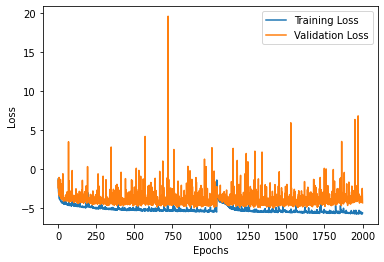

157/157 [==============================] - 7s 44ms/step - loss: -5.1714


157/157 [==============================] - 8s 46ms/step - loss: -5.2377


Epoch 1/2000
118/118 [==============================] - ETA: 0s - loss: -0.8296

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel2/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel2/assets


118/118 [==============================] - 32s 246ms/step - loss: -0.8296 - val_loss: -0.0199
Epoch 2/2000
118/118 [==============================] - 22s 184ms/step - loss: -1.2299 - val_loss: 0.4383
Epoch 3/2000
118/118 [==============================] - 22s 188ms/step - loss: -1.2443 - val_loss: 0.5671
Epoch 4/2000
118/118 [==============================] - 22s 183ms/step - loss: -1.2490 - val_loss: 0.4942
Epoch 5/2000
118/118 [==============================] - 22s 186ms/step - loss: -1.2517 - val_loss: 0.5545
Epoch 6/2000
118/118 [==============================] - 22s 188ms/step - loss: -1.2538 - val_loss: 0.5924
Epoch 7/2000
118/118 [==============================] - 22s 184ms/step - loss: -1.2548 - val_loss: 0.3881
Epoch 8/2000
118/118 [==============================] - ETA: 0s - loss: -1.2666

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel2/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel2/assets


118/118 [==============================] - 29s 246ms/step - loss: -1.2666 - val_loss: -0.2173
Epoch 9/2000
118/118 [==============================] - 22s 183ms/step - loss: -1.2655 - val_loss: 0.5491
Epoch 10/2000
118/118 [==============================] - 22s 184ms/step - loss: -1.2633 - val_loss: 0.5238
Epoch 11/2000
118/118 [==============================] - 22s 186ms/step - loss: -1.2583 - val_loss: 0.2495
Epoch 12/2000
118/118 [==============================] - 22s 184ms/step - loss: -1.2609 - val_loss: 0.5307
Epoch 13/2000
118/118 [==============================] - ETA: 0s - loss: -1.4564

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel2/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel2/assets


118/118 [==============================] - 29s 248ms/step - loss: -1.4564 - val_loss: -0.6082
Epoch 14/2000
118/118 [==============================] - ETA: 0s - loss: -2.3096

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel2/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel2/assets


118/118 [==============================] - 28s 238ms/step - loss: -2.3096 - val_loss: -2.1790
Epoch 15/2000
118/118 [==============================] - ETA: 0s - loss: -3.0639

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel2/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel2/assets


118/118 [==============================] - 29s 251ms/step - loss: -3.0639 - val_loss: -2.3378
Epoch 16/2000
118/118 [==============================] - 22s 185ms/step - loss: -3.4636 - val_loss: -1.7272
Epoch 17/2000
118/118 [==============================] - ETA: 0s - loss: -3.6501

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel2/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel2/assets


118/118 [==============================] - 29s 247ms/step - loss: -3.6501 - val_loss: -2.7256
Epoch 18/2000
118/118 [==============================] - ETA: 0s - loss: -3.7579

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel2/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel2/assets


118/118 [==============================] - 29s 248ms/step - loss: -3.7579 - val_loss: -3.4058
Epoch 19/2000
118/118 [==============================] - ETA: 0s - loss: -3.8575

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel2/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel2/assets


118/118 [==============================] - 28s 238ms/step - loss: -3.8575 - val_loss: -3.5069
Epoch 20/2000
118/118 [==============================] - 22s 185ms/step - loss: -3.9829 - val_loss: -2.8683
Epoch 21/2000
118/118 [==============================] - 21s 181ms/step - loss: -4.0285 - val_loss: -3.4887
Epoch 22/2000
118/118 [==============================] - ETA: 0s - loss: -4.0092

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel2/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel2/assets


118/118 [==============================] - 30s 253ms/step - loss: -4.0092 - val_loss: -3.5924
Epoch 23/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.0727 - val_loss: -3.2662
Epoch 24/2000
118/118 [==============================] - ETA: 0s - loss: -4.1689

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel2/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel2/assets


118/118 [==============================] - 29s 244ms/step - loss: -4.1689 - val_loss: -3.8541
Epoch 25/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.0457 - val_loss: -2.1706
Epoch 26/2000
118/118 [==============================] - 21s 182ms/step - loss: -3.8200 - val_loss: -3.7143
Epoch 27/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.1191 - val_loss: -3.5303
Epoch 28/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.2793 - val_loss: -3.4161
Epoch 29/2000
118/118 [==============================] - ETA: 0s - loss: -4.2350

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel2/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel2/assets


118/118 [==============================] - 28s 240ms/step - loss: -4.2350 - val_loss: -3.8781
Epoch 30/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.2669 - val_loss: -1.8003
Epoch 31/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.3302 - val_loss: -3.7022
Epoch 32/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.0533 - val_loss: -3.6862
Epoch 33/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.1194 - val_loss: -3.6535
Epoch 34/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.3276 - val_loss: -3.7371
Epoch 35/2000
118/118 [==============================] - ETA: 0s - loss: -4.3434

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel2/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel2/assets


118/118 [==============================] - 30s 252ms/step - loss: -4.3434 - val_loss: -3.9180
Epoch 36/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.3670 - val_loss: -1.0319
Epoch 37/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.3458 - val_loss: -3.6333
Epoch 38/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.3049 - val_loss: -3.1027
Epoch 39/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.3171 - val_loss: -3.5141
Epoch 40/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.4275 - val_loss: -3.7218
Epoch 41/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.0099 - val_loss: -2.6611
Epoch 42/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.1297 - val_loss: -3.5584
Epoch 43/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.2412 - val_loss: -3.4183
Epoch 44/2000
118/118 [===================

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel2/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel2/assets


118/118 [==============================] - 28s 240ms/step - loss: -4.3786 - val_loss: -3.9209
Epoch 47/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.4792 - val_loss: -3.5566
Epoch 48/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.4562 - val_loss: -2.1711
Epoch 49/2000
118/118 [==============================] - ETA: 0s - loss: -4.5008

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel2/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel2/assets


118/118 [==============================] - 30s 252ms/step - loss: -4.5008 - val_loss: -4.0243
Epoch 50/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.3127 - val_loss: -3.6162
Epoch 51/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.4649 - val_loss: -3.5858
Epoch 52/2000
118/118 [==============================] - ETA: 0s - loss: -4.4923

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel2/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel2/assets


118/118 [==============================] - 29s 245ms/step - loss: -4.4923 - val_loss: -4.0552
Epoch 53/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.3533 - val_loss: -3.0858
Epoch 54/2000
118/118 [==============================] - 22s 185ms/step - loss: -3.8782 - val_loss: -3.7341
Epoch 55/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.2701 - val_loss: -3.4451
Epoch 56/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.4501 - val_loss: -4.0329
Epoch 57/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.4981 - val_loss: -3.3756
Epoch 58/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.4986 - val_loss: -3.7743
Epoch 59/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.4768 - val_loss: -3.9914
Epoch 60/2000
118/118 [==============================] - ETA: 0s - loss: -4.5089

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel2/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel2/assets


118/118 [==============================] - 29s 246ms/step - loss: -4.5089 - val_loss: -4.0692
Epoch 61/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.5251 - val_loss: -3.9476
Epoch 62/2000
118/118 [==============================] - ETA: 0s - loss: -4.5449

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel2/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel2/assets


118/118 [==============================] - 28s 239ms/step - loss: -4.5449 - val_loss: -4.1073
Epoch 63/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.5571 - val_loss: -3.7240
Epoch 64/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.4574 - val_loss: -3.0047
Epoch 65/2000
118/118 [==============================] - 21s 182ms/step - loss: -4.4141 - val_loss: -3.0414
Epoch 66/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.5294 - val_loss: -4.0465
Epoch 67/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.5619 - val_loss: -3.9584
Epoch 68/2000
118/118 [==============================] - ETA: 0s - loss: -4.5869

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel2/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel2/assets


118/118 [==============================] - 29s 250ms/step - loss: -4.5869 - val_loss: -4.1133
Epoch 69/2000
118/118 [==============================] - 22s 188ms/step - loss: -3.6911 - val_loss: -3.4879
Epoch 70/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.5041 - val_loss: -3.5439
Epoch 71/2000
118/118 [==============================] - 21s 182ms/step - loss: -4.5304 - val_loss: 1.9947
Epoch 72/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.4134 - val_loss: -3.7052
Epoch 73/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.5177 - val_loss: -3.7563
Epoch 74/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.5073 - val_loss: -3.6139
Epoch 75/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.6159 - val_loss: -4.1132
Epoch 76/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.4178 - val_loss: -3.5200
Epoch 77/2000
118/118 [====================

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel2/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel2/assets


118/118 [==============================] - 29s 244ms/step - loss: -4.6736 - val_loss: -4.2707
Epoch 119/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.4915 - val_loss: -3.9277
Epoch 120/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.5891 - val_loss: -3.4166
Epoch 121/2000
118/118 [==============================] - 22s 185ms/step - loss: -3.8209 - val_loss: -3.7962
Epoch 122/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.2983 - val_loss: -3.6499
Epoch 123/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.4283 - val_loss: -3.7320
Epoch 124/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.6050 - val_loss: -4.0571
Epoch 125/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.6473 - val_loss: -3.4776
Epoch 126/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.7521 - val_loss: -4.0359
Epoch 127/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel2/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel2/assets


118/118 [==============================] - 30s 252ms/step - loss: -4.6476 - val_loss: -4.2789
Epoch 163/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.6020 - val_loss: -3.1968
Epoch 164/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.6211 - val_loss: -3.5218
Epoch 165/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.6678 - val_loss: -3.6081
Epoch 166/2000
118/118 [==============================] - ETA: 0s - loss: -4.7465

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel2/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel2/assets


118/118 [==============================] - 29s 246ms/step - loss: -4.7465 - val_loss: -4.3625
Epoch 167/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.4309 - val_loss: -3.0168
Epoch 168/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.0960 - val_loss: -3.6183
Epoch 169/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.6787 - val_loss: -4.1767
Epoch 170/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.5722 - val_loss: -2.7343
Epoch 171/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.7018 - val_loss: -4.0716
Epoch 172/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.6736 - val_loss: -1.7758
Epoch 173/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.6046 - val_loss: -3.6812
Epoch 174/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.7336 - val_loss: -3.5801
Epoch 175/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel2/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel2/assets


118/118 [==============================] - 29s 249ms/step - loss: -4.6604 - val_loss: -4.4009
Epoch 215/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.4157 - val_loss: -4.1330
Epoch 216/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.6250 - val_loss: -3.9619
Epoch 217/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.4727 - val_loss: -4.1009
Epoch 218/2000
118/118 [==============================] - 22s 182ms/step - loss: -4.7899 - val_loss: -4.1883
Epoch 219/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.7911 - val_loss: -4.1243
Epoch 220/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.4289 - val_loss: -3.7366
Epoch 221/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.7314 - val_loss: -4.1198
Epoch 222/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.7375 - val_loss: -4.1822
Epoch 223/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel2/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel2/assets


118/118 [==============================] - 28s 236ms/step - loss: -4.8658 - val_loss: -4.4153
Epoch 227/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.7171 - val_loss: -3.8088
Epoch 228/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.8306 - val_loss: -4.1805
Epoch 229/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.8556 - val_loss: -3.9099
Epoch 230/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.6894 - val_loss: -4.4080
Epoch 231/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.8307 - val_loss: -4.2378
Epoch 232/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.8093 - val_loss: -4.1713
Epoch 233/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.8609 - val_loss: -3.2408
Epoch 234/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.8103 - val_loss: -4.3667
Epoch 235/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel2/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel2/assets


118/118 [==============================] - 30s 252ms/step - loss: -4.8182 - val_loss: -4.4286
Epoch 305/2000
118/118 [==============================] - 22s 183ms/step - loss: -3.9948 - val_loss: -3.9750
Epoch 306/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.1403 - val_loss: -4.1726
Epoch 307/2000
118/118 [==============================] - 21s 182ms/step - loss: -4.6444 - val_loss: -4.1633
Epoch 308/2000
118/118 [==============================] - 22s 182ms/step - loss: -4.6986 - val_loss: -4.2176
Epoch 309/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.6579 - val_loss: -4.2138
Epoch 310/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.8132 - val_loss: -4.1049
Epoch 311/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.7943 - val_loss: -4.2916
Epoch 312/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.7275 - val_loss: -4.1712
Epoch 313/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel2/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel2/assets


118/118 [==============================] - 29s 249ms/step - loss: -4.9050 - val_loss: -4.4858
Epoch 333/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.6210 - val_loss: -3.8118
Epoch 334/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.8723 - val_loss: -4.1783
Epoch 335/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.8060 - val_loss: -3.5809
Epoch 336/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.8639 - val_loss: -4.1453
Epoch 337/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.8999 - val_loss: -4.2125
Epoch 338/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.3671 - val_loss: -4.2741
Epoch 339/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.8380 - val_loss: -4.3098
Epoch 340/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.8427 - val_loss: -2.0081
Epoch 341/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel2/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel2/assets


118/118 [==============================] - 28s 242ms/step - loss: -5.0079 - val_loss: -4.5139
Epoch 360/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.7924 - val_loss: -4.0895
Epoch 361/2000
118/118 [==============================] - 22s 185ms/step - loss: -3.0017 - val_loss: -2.2759
Epoch 362/2000
118/118 [==============================] - 22s 186ms/step - loss: -3.3682 - val_loss: -2.7135
Epoch 363/2000
118/118 [==============================] - 22s 185ms/step - loss: -3.7223 - val_loss: -3.0647
Epoch 364/2000
118/118 [==============================] - 22s 184ms/step - loss: -3.9844 - val_loss: -2.5206
Epoch 365/2000
118/118 [==============================] - 21s 181ms/step - loss: -4.0837 - val_loss: -3.0751
Epoch 366/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.1819 - val_loss: -3.2489
Epoch 367/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.1591 - val_loss: -3.6173
Epoch 368/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel2/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel2/assets


118/118 [==============================] - 30s 253ms/step - loss: -4.9888 - val_loss: -4.6617
Epoch 453/2000
118/118 [==============================] - 22s 182ms/step - loss: -5.0183 - val_loss: -4.5658
Epoch 454/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.0293 - val_loss: -4.2691
Epoch 455/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.9365 - val_loss: -4.4232
Epoch 456/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.0838 - val_loss: -4.6256
Epoch 457/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.0747 - val_loss: -2.3282
Epoch 458/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.9951 - val_loss: -4.1934
Epoch 459/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.0566 - val_loss: -4.4369
Epoch 460/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.0631 - val_loss: -3.9336
Epoch 461/2000
118/118 [==========

118/118 [==============================] - 22s 186ms/step - loss: -3.8517 - val_loss: -4.1629
Epoch 603/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.6347 - val_loss: -4.3258
Epoch 604/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.8702 - val_loss: -3.7050
Epoch 605/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.9453 - val_loss: -4.0340
Epoch 606/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.0225 - val_loss: -4.3412
Epoch 607/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.8432 - val_loss: -4.0468
Epoch 608/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.9266 - val_loss: -4.5072
Epoch 609/2000
118/118 [==============================] - 21s 181ms/step - loss: -5.0562 - val_loss: -4.2548
Epoch 610/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.0268 - val_loss: -4.1074
Epoch 611/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel2/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel2/assets


118/118 [==============================] - 28s 241ms/step - loss: -5.0999 - val_loss: -4.6874
Epoch 658/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.0382 - val_loss: -3.1735
Epoch 659/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.0568 - val_loss: -3.8537
Epoch 660/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.1159 - val_loss: -4.4168
Epoch 661/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.0727 - val_loss: -4.1964
Epoch 662/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.0573 - val_loss: -4.1779
Epoch 663/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.1227 - val_loss: -4.3870
Epoch 664/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.0975 - val_loss: -4.3641
Epoch 665/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.1367 - val_loss: -3.7793
Epoch 666/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel2/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel2/assets


118/118 [==============================] - 30s 253ms/step - loss: -5.1048 - val_loss: -4.7002
Epoch 674/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.1753 - val_loss: -3.7298
Epoch 675/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.9839 - val_loss: -3.5678
Epoch 676/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.0687 - val_loss: -4.1532
Epoch 677/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.1516 - val_loss: -1.7540
Epoch 678/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.0234 - val_loss: -4.2230
Epoch 679/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.1564 - val_loss: -4.0989
Epoch 680/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.1259 - val_loss: -4.3952
Epoch 681/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.1892 - val_loss: -3.5783
Epoch 682/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel2/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel2/assets


118/118 [==============================] - 29s 249ms/step - loss: -5.1601 - val_loss: -4.7405
Epoch 685/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.1791 - val_loss: -4.3407
Epoch 686/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.1062 - val_loss: -4.5218
Epoch 687/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.1077 - val_loss: -3.9339
Epoch 688/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.0697 - val_loss: -2.4389
Epoch 689/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.0840 - val_loss: -4.3465
Epoch 690/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.2213 - val_loss: -4.5735
Epoch 691/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.1850 - val_loss: -4.3930
Epoch 692/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.1162 - val_loss: -4.5265
Epoch 693/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel2/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel2/assets


118/118 [==============================] - 29s 247ms/step - loss: -5.3173 - val_loss: -4.8205
Epoch 785/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.1560 - val_loss: -3.5461
Epoch 786/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.2287 - val_loss: -3.9379
Epoch 787/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.3291 - val_loss: -3.2275
Epoch 788/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.6412 - val_loss: -3.6857
Epoch 789/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.8944 - val_loss: -4.0138
Epoch 790/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.0379 - val_loss: -4.5451
Epoch 791/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.0827 - val_loss: -3.8285
Epoch 792/2000
118/118 [==============================] - 21s 181ms/step - loss: -5.2044 - val_loss: -4.4986
Epoch 793/2000
118/118 [==========

118/118 [==============================] - 22s 184ms/step - loss: -5.1835 - val_loss: -4.5545
Epoch 935/2000
118/118 [==============================] - 22s 182ms/step - loss: -5.3312 - val_loss: -2.5711
Epoch 936/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.3094 - val_loss: -3.5676
Epoch 937/2000
118/118 [==============================] - 22s 188ms/step - loss: -5.3029 - val_loss: -4.3647
Epoch 938/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.3502 - val_loss: -3.2711
Epoch 939/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.3065 - val_loss: -4.2561
Epoch 940/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.3649 - val_loss: -4.1636
Epoch 941/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.4160 - val_loss: -3.1993
Epoch 942/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.2756 - val_loss: -4.3370
Epoch 943/2000
118/118 [==========

118/118 [==============================] - 22s 186ms/step - loss: -5.3926 - val_loss: -4.5856
Epoch 1084/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.4261 - val_loss: -1.5197
Epoch 1085/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.3840 - val_loss: -4.0349
Epoch 1086/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.3950 - val_loss: -3.6197
Epoch 1087/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.3603 - val_loss: -4.7323
Epoch 1088/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.3638 - val_loss: -4.5202
Epoch 1089/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.4236 - val_loss: -3.2929
Epoch 1090/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.4008 - val_loss: -3.6964
Epoch 1091/2000
118/118 [==============================] - 22s 182ms/step - loss: -5.4191 - val_loss: -4.1756
Epoch 1092/2000
118/118 [=

118/118 [==============================] - 22s 187ms/step - loss: -5.4329 - val_loss: -3.6838
Epoch 1232/2000
118/118 [==============================] - 22s 182ms/step - loss: -5.4413 - val_loss: -2.3650
Epoch 1233/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.4225 - val_loss: -4.3222
Epoch 1234/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.4902 - val_loss: -4.2776
Epoch 1235/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.4054 - val_loss: 3.3911
Epoch 1236/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.2450 - val_loss: -4.4687
Epoch 1237/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.4613 - val_loss: -4.5103
Epoch 1238/2000
118/118 [==============================] - 21s 182ms/step - loss: -5.4247 - val_loss: -3.1566
Epoch 1239/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.4948 - val_loss: -3.7216
Epoch 1240/2000
118/118 [==

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel2/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel2/assets


118/118 [==============================] - 28s 240ms/step - loss: -5.3982 - val_loss: -4.8238
Epoch 1317/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.5083 - val_loss: -4.3761
Epoch 1318/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.4472 - val_loss: -4.2218
Epoch 1319/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.4264 - val_loss: -4.0331
Epoch 1320/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.4440 - val_loss: -3.1024
Epoch 1321/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.4729 - val_loss: -4.4293
Epoch 1322/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.5053 - val_loss: -4.3176
Epoch 1323/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.4558 - val_loss: -4.4672
Epoch 1324/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.4924 - val_loss: -3.6621
Epoch 1325/2000
118/118 [=

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel2/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel2/assets


118/118 [==============================] - 30s 255ms/step - loss: -5.4343 - val_loss: -4.8488
Epoch 1356/2000
118/118 [==============================] - 22s 182ms/step - loss: -5.2977 - val_loss: -4.4282
Epoch 1357/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.4390 - val_loss: -4.6092
Epoch 1358/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.5323 - val_loss: -4.1360
Epoch 1359/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.4767 - val_loss: -4.0066
Epoch 1360/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.3997 - val_loss: -3.5448
Epoch 1361/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.5184 - val_loss: -3.0106
Epoch 1362/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.2748 - val_loss: -3.4547
Epoch 1363/2000
118/118 [==============================] - 22s 182ms/step - loss: -5.4470 - val_loss: -0.4040
Epoch 1364/2000
118/118 [=

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel2/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel2/assets


118/118 [==============================] - 30s 251ms/step - loss: -5.3872 - val_loss: -4.9107
Epoch 1365/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.4808 - val_loss: -2.7403
Epoch 1366/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.4892 - val_loss: -4.0541
Epoch 1367/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.5263 - val_loss: -3.8518
Epoch 1368/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.3747 - val_loss: -3.6808
Epoch 1369/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.3863 - val_loss: -3.8222
Epoch 1370/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.4761 - val_loss: -3.7266
Epoch 1371/2000
118/118 [==============================] - 21s 181ms/step - loss: -5.5241 - val_loss: -4.4775
Epoch 1372/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.4189 - val_loss: -3.8097
Epoch 1373/2000
118/118 [=

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel2/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel2/assets


118/118 [==============================] - 28s 240ms/step - loss: -5.4275 - val_loss: -4.9561
Epoch 1492/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.4806 - val_loss: -4.0069
Epoch 1493/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.3685 - val_loss: -4.7234
Epoch 1494/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.4536 - val_loss: -3.8381
Epoch 1495/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.4461 - val_loss: -4.0373
Epoch 1496/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.5043 - val_loss: 2.4105
Epoch 1497/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.8333 - val_loss: -4.1284
Epoch 1498/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.3025 - val_loss: -4.3597
Epoch 1499/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.4082 - val_loss: -3.9728
Epoch 1500/2000
118/118 [==

118/118 [==============================] - 22s 183ms/step - loss: -5.5793 - val_loss: -3.8869
Epoch 1640/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.5167 - val_loss: -4.5039
Epoch 1641/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.5690 - val_loss: -2.7758
Epoch 1642/2000
118/118 [==============================] - 22s 189ms/step - loss: -5.4686 - val_loss: -4.2495
Epoch 1643/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.5152 - val_loss: -4.2589
Epoch 1644/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.0889 - val_loss: -4.1401
Epoch 1645/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.3876 - val_loss: -4.2526
Epoch 1646/2000
118/118 [==============================] - 22s 188ms/step - loss: -5.3783 - val_loss: -3.4054
Epoch 1647/2000
118/118 [==============================] - 22s 182ms/step - loss: -5.4745 - val_loss: -4.9275
Epoch 1648/2000
118/118 [=

118/118 [==============================] - 22s 186ms/step - loss: -5.4979 - val_loss: -4.5266
Epoch 1788/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.5595 - val_loss: -2.9853
Epoch 1789/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.2085 - val_loss: -3.8913
Epoch 1790/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.4209 - val_loss: -3.6921
Epoch 1791/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.5028 - val_loss: -4.2830
Epoch 1792/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.4871 - val_loss: -4.6603
Epoch 1793/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.5364 - val_loss: -3.3059
Epoch 1794/2000
118/118 [==============================] - 21s 182ms/step - loss: -5.4680 - val_loss: -3.8888
Epoch 1795/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.5429 - val_loss: -4.4454
Epoch 1796/2000
118/118 [=

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel2/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel2/assets


118/118 [==============================] - 30s 255ms/step - loss: -5.2824 - val_loss: -5.0641
Epoch 1928/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.3717 - val_loss: -4.1433
Epoch 1929/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.4418 - val_loss: -4.1560
Epoch 1930/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.5018 - val_loss: -1.1716
Epoch 1931/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.4843 - val_loss: -0.6700
Epoch 1932/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.5215 - val_loss: -3.9082
Epoch 1933/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.4173 - val_loss: -4.3436
Epoch 1934/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.5608 - val_loss: -4.7874
Epoch 1935/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.4823 - val_loss: -4.6636
Epoch 1936/2000
118/118 [=

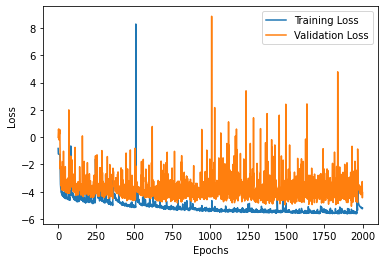

157/157 [==============================] - 7s 44ms/step - loss: -4.9657


157/157 [==============================] - 9s 44ms/step - loss: -5.3059


Epoch 1/2000
118/118 [==============================] - ETA: 0s - loss: -0.9935

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel3/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel3/assets


118/118 [==============================] - 33s 250ms/step - loss: -0.9935 - val_loss: -0.8825
Epoch 2/2000
118/118 [==============================] - 22s 188ms/step - loss: -1.2428 - val_loss: 0.4508
Epoch 3/2000
118/118 [==============================] - 22s 185ms/step - loss: -1.2474 - val_loss: 0.4559
Epoch 4/2000
118/118 [==============================] - 22s 184ms/step - loss: -1.2601 - val_loss: 0.2745
Epoch 5/2000
118/118 [==============================] - 22s 185ms/step - loss: -1.4990 - val_loss: -0.4022
Epoch 6/2000
118/118 [==============================] - ETA: 0s - loss: -2.3239

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel3/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel3/assets


118/118 [==============================] - 29s 248ms/step - loss: -2.3239 - val_loss: -1.0391
Epoch 7/2000
118/118 [==============================] - ETA: 0s - loss: -2.8857

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel3/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel3/assets


118/118 [==============================] - 29s 246ms/step - loss: -2.8857 - val_loss: -1.5700
Epoch 8/2000
118/118 [==============================] - ETA: 0s - loss: -3.2648

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel3/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel3/assets


118/118 [==============================] - 29s 246ms/step - loss: -3.2648 - val_loss: -2.6680
Epoch 9/2000
118/118 [==============================] - ETA: 0s - loss: -3.4539

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel3/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel3/assets


118/118 [==============================] - 29s 247ms/step - loss: -3.4539 - val_loss: -3.0539
Epoch 10/2000
118/118 [==============================] - 22s 185ms/step - loss: -3.7572 - val_loss: -1.2060
Epoch 11/2000
118/118 [==============================] - 22s 186ms/step - loss: -3.7574 - val_loss: -2.9630
Epoch 12/2000
118/118 [==============================] - 22s 185ms/step - loss: -3.9044 - val_loss: -3.0201
Epoch 13/2000
118/118 [==============================] - ETA: 0s - loss: -4.0555

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel3/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel3/assets


118/118 [==============================] - 29s 247ms/step - loss: -4.0555 - val_loss: -3.4860
Epoch 14/2000
118/118 [==============================] - ETA: 0s - loss: -4.1062

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel3/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel3/assets


118/118 [==============================] - 29s 249ms/step - loss: -4.1062 - val_loss: -3.7796
Epoch 15/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.0064 - val_loss: -3.5942
Epoch 16/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.1351 - val_loss: -3.5998
Epoch 17/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.2010 - val_loss: -3.4166
Epoch 18/2000
118/118 [==============================] - ETA: 0s - loss: -4.2914

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel3/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel3/assets


118/118 [==============================] - 29s 246ms/step - loss: -4.2914 - val_loss: -3.9311
Epoch 19/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.2561 - val_loss: -3.0444
Epoch 20/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.3204 - val_loss: -3.8722
Epoch 21/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.3755 - val_loss: -0.8702
Epoch 22/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.4109 - val_loss: 0.0625
Epoch 23/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.3253 - val_loss: -3.1704
Epoch 24/2000
118/118 [==============================] - ETA: 0s - loss: -4.4317

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel3/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel3/assets


118/118 [==============================] - 29s 243ms/step - loss: -4.4317 - val_loss: -3.9815
Epoch 25/2000
118/118 [==============================] - 21s 182ms/step - loss: -4.3840 - val_loss: -3.8176
Epoch 26/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.3787 - val_loss: -3.9789
Epoch 27/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.2720 - val_loss: -3.5633
Epoch 28/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.5294 - val_loss: -1.7222
Epoch 29/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.1497 - val_loss: -1.6645
Epoch 30/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.3376 - val_loss: -2.9053
Epoch 31/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.3382 - val_loss: -3.9730
Epoch 32/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.4208 - val_loss: -2.8771
Epoch 33/2000
118/118 [===================

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel3/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel3/assets


118/118 [==============================] - 30s 252ms/step - loss: -4.5083 - val_loss: -3.9872
Epoch 34/2000
118/118 [==============================] - ETA: 0s - loss: -4.5790

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel3/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel3/assets


118/118 [==============================] - 29s 247ms/step - loss: -4.5790 - val_loss: -4.1679
Epoch 35/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.3550 - val_loss: -4.0482
Epoch 36/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.5729 - val_loss: -3.5633
Epoch 37/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.5394 - val_loss: -4.0659
Epoch 38/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.5274 - val_loss: -3.3357
Epoch 39/2000
118/118 [==============================] - ETA: 0s - loss: -4.6022

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel3/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel3/assets


118/118 [==============================] - 29s 247ms/step - loss: -4.6022 - val_loss: -4.2247
Epoch 40/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.5844 - val_loss: -3.8189
Epoch 41/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.6149 - val_loss: -4.0130
Epoch 42/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.5296 - val_loss: -4.0791
Epoch 43/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.6315 - val_loss: -2.5451
Epoch 44/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.6048 - val_loss: -3.2233
Epoch 45/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.6375 - val_loss: -4.1315
Epoch 46/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.5700 - val_loss: -2.4980
Epoch 47/2000
118/118 [==============================] - ETA: 0s - loss: -4.6505

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel3/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel3/assets


118/118 [==============================] - 30s 252ms/step - loss: -4.6505 - val_loss: -4.2698
Epoch 48/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.6886 - val_loss: -4.1459
Epoch 49/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.6235 - val_loss: -2.9004
Epoch 50/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.5960 - val_loss: -4.2641
Epoch 51/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.6625 - val_loss: -2.8882
Epoch 52/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.5984 - val_loss: -4.0624
Epoch 53/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.6950 - val_loss: -3.5597
Epoch 54/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.5860 - val_loss: -3.7127
Epoch 55/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.6359 - val_loss: -3.4756
Epoch 56/2000
118/118 [===================

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel3/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel3/assets


118/118 [==============================] - 29s 242ms/step - loss: -4.5555 - val_loss: -4.3029
Epoch 66/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.4996 - val_loss: -3.6490
Epoch 67/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.6219 - val_loss: -3.9910
Epoch 68/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.5604 - val_loss: -3.9342
Epoch 69/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.5538 - val_loss: -2.9340
Epoch 70/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.1964 - val_loss: -3.1512
Epoch 71/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.5445 - val_loss: -3.3004
Epoch 72/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.5382 - val_loss: -2.9845
Epoch 73/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.6309 - val_loss: -3.9606
Epoch 74/2000
118/118 [===================

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel3/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel3/assets


118/118 [==============================] - 30s 253ms/step - loss: -4.8190 - val_loss: -4.3664
Epoch 86/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.7518 - val_loss: -2.9862
Epoch 87/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.7498 - val_loss: -2.9589
Epoch 88/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.8433 - val_loss: -3.3886
Epoch 89/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.2878 - val_loss: -4.0483
Epoch 90/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.5980 - val_loss: -4.1094
Epoch 91/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.7619 - val_loss: -4.2585
Epoch 92/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.7246 - val_loss: -3.9030
Epoch 93/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.8006 - val_loss: -3.6190
Epoch 94/2000
118/118 [===================

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel3/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel3/assets


118/118 [==============================] - 29s 248ms/step - loss: -4.8643 - val_loss: -4.3995
Epoch 97/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.7492 - val_loss: -4.1563
Epoch 98/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.7433 - val_loss: -3.9004
Epoch 99/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.8795 - val_loss: -3.3981
Epoch 100/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.4473 - val_loss: -3.8873
Epoch 101/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.7084 - val_loss: -4.1652
Epoch 102/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.7042 - val_loss: -3.8361
Epoch 103/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.8131 - val_loss: -4.0480
Epoch 104/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.7930 - val_loss: -4.3828
Epoch 105/2000
118/118 [=============

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel3/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel3/assets


118/118 [==============================] - 29s 248ms/step - loss: -4.5937 - val_loss: -4.4077
Epoch 170/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.7936 - val_loss: -3.1627
Epoch 171/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.8230 - val_loss: -4.3704
Epoch 172/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.5855 - val_loss: -4.2238
Epoch 173/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.8046 - val_loss: -3.9587
Epoch 174/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.9001 - val_loss: -4.1287
Epoch 175/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.8284 - val_loss: -2.5946
Epoch 176/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.6499 - val_loss: -4.3378
Epoch 177/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.8758 - val_loss: -3.2870
Epoch 178/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel3/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel3/assets


118/118 [==============================] - 29s 248ms/step - loss: -4.9013 - val_loss: -4.4300
Epoch 189/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.5804 - val_loss: -3.6352
Epoch 190/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.8538 - val_loss: -4.4103
Epoch 191/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.9014 - val_loss: -3.6920
Epoch 192/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.8691 - val_loss: -3.9488
Epoch 193/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.9818 - val_loss: -2.1029
Epoch 194/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.8854 - val_loss: -4.3098
Epoch 195/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.8398 - val_loss: -4.1926
Epoch 196/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.7520 - val_loss: -3.6711
Epoch 197/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel3/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel3/assets


118/118 [==============================] - 29s 250ms/step - loss: -5.0528 - val_loss: -4.4311
Epoch 216/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.9997 - val_loss: -4.3488
Epoch 217/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.9987 - val_loss: -3.3172
Epoch 218/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.7826 - val_loss: -4.3646
Epoch 219/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.0092 - val_loss: -2.6471
Epoch 220/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.7915 - val_loss: -4.2164
Epoch 221/2000
118/118 [==============================] - 22s 182ms/step - loss: -4.9425 - val_loss: -4.2486
Epoch 222/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.9127 - val_loss: -4.2147
Epoch 223/2000
118/118 [==============================] - 22s 188ms/step - loss: -5.0373 - val_loss: -3.5066
Epoch 224/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel3/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel3/assets


118/118 [==============================] - 29s 248ms/step - loss: -4.9923 - val_loss: -4.4351
Epoch 225/2000
118/118 [==============================] - 22s 189ms/step - loss: -4.8926 - val_loss: -4.2184
Epoch 226/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.0632 - val_loss: -3.9909
Epoch 227/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.0222 - val_loss: -2.4968
Epoch 228/2000
118/118 [==============================] - 22s 189ms/step - loss: -4.2712 - val_loss: -3.8176
Epoch 229/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.9181 - val_loss: -3.6942
Epoch 230/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.9248 - val_loss: -4.0106
Epoch 231/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.7444 - val_loss: -3.7714
Epoch 232/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.8531 - val_loss: -4.2376
Epoch 233/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel3/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel3/assets


118/118 [==============================] - 29s 247ms/step - loss: -5.0047 - val_loss: -4.6412
Epoch 236/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.6984 - val_loss: -3.4453
Epoch 237/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.9625 - val_loss: -4.3044
Epoch 238/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.9549 - val_loss: -4.4472
Epoch 239/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.0559 - val_loss: -4.3501
Epoch 240/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.0177 - val_loss: -4.3772
Epoch 241/2000
118/118 [==============================] - 22s 190ms/step - loss: -4.9971 - val_loss: -1.9740
Epoch 242/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.0103 - val_loss: -4.2792
Epoch 243/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.0348 - val_loss: -3.8201
Epoch 244/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel3/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel3/assets


118/118 [==============================] - 29s 248ms/step - loss: -5.1251 - val_loss: -4.6765
Epoch 370/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.2413 - val_loss: -4.3160
Epoch 371/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.0765 - val_loss: -4.4079
Epoch 372/2000
118/118 [==============================] - 22s 187ms/step - loss: -3.6631 - val_loss: -4.1874
Epoch 373/2000
118/118 [==============================] - 22s 182ms/step - loss: -4.3513 - val_loss: -4.3822
Epoch 374/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.9293 - val_loss: -2.0804
Epoch 375/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.0674 - val_loss: -4.5657
Epoch 376/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.9926 - val_loss: -4.4377
Epoch 377/2000
118/118 [==============================] - 22s 189ms/step - loss: -5.1298 - val_loss: -3.9932
Epoch 378/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel3/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel3/assets


118/118 [==============================] - 29s 249ms/step - loss: -5.2182 - val_loss: -4.7852
Epoch 409/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.1946 - val_loss: -4.1921
Epoch 410/2000
118/118 [==============================] - 22s 188ms/step - loss: -5.1054 - val_loss: -4.3195
Epoch 411/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.2876 - val_loss: -3.2525
Epoch 412/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.2566 - val_loss: -4.3405
Epoch 413/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.1589 - val_loss: -4.4504
Epoch 414/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.1307 - val_loss: -3.1101
Epoch 415/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.0900 - val_loss: -4.6808
Epoch 416/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.1061 - val_loss: -3.2349
Epoch 417/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel3/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel3/assets


118/118 [==============================] - 29s 248ms/step - loss: -5.2051 - val_loss: -4.8340
Epoch 437/2000
118/118 [==============================] - ETA: 0s - loss: -5.2092

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel3/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel3/assets


118/118 [==============================] - 29s 248ms/step - loss: -5.2092 - val_loss: -4.8415
Epoch 438/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.7814 - val_loss: -4.4544
Epoch 439/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.1632 - val_loss: -3.4440
Epoch 440/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.1203 - val_loss: -3.9619
Epoch 441/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.2865 - val_loss: -3.7943
Epoch 442/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.1825 - val_loss: -4.3144
Epoch 443/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.9705 - val_loss: -4.2459
Epoch 444/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.2258 - val_loss: -2.8326
Epoch 445/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.1871 - val_loss: -4.2267
Epoch 446/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel3/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel3/assets


118/118 [==============================] - 29s 248ms/step - loss: -5.2592 - val_loss: -4.8535
Epoch 494/2000
118/118 [==============================] - 22s 189ms/step - loss: -4.9680 - val_loss: -4.0738
Epoch 495/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.2662 - val_loss: -4.6372
Epoch 496/2000
118/118 [==============================] - 22s 190ms/step - loss: -5.2667 - val_loss: -3.0213
Epoch 497/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.2377 - val_loss: -4.1075
Epoch 498/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.2907 - val_loss: -4.6415
Epoch 499/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.2204 - val_loss: -4.1796
Epoch 500/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.1984 - val_loss: -4.6513
Epoch 501/2000
118/118 [==============================] - 22s 188ms/step - loss: -5.2809 - val_loss: -4.4752
Epoch 502/2000
118/118 [==========

118/118 [==============================] - 22s 187ms/step - loss: -5.1919 - val_loss: -3.9607
Epoch 644/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.1138 - val_loss: -3.6627
Epoch 645/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.2361 - val_loss: -3.6963
Epoch 646/2000
118/118 [==============================] - 22s 188ms/step - loss: -5.0031 - val_loss: -4.4259
Epoch 647/2000
118/118 [==============================] - 22s 188ms/step - loss: -5.3102 - val_loss: -3.9014
Epoch 648/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.2980 - val_loss: -3.4723
Epoch 649/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.2475 - val_loss: -3.2871
Epoch 650/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.2838 - val_loss: -4.5117
Epoch 651/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.1815 - val_loss: -4.4885
Epoch 652/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel3/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel3/assets


118/118 [==============================] - 29s 247ms/step - loss: -5.4554 - val_loss: -4.8786
Epoch 785/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.3963 - val_loss: -4.3973
Epoch 786/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.3716 - val_loss: -4.5333
Epoch 787/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.3579 - val_loss: -3.5944
Epoch 788/2000
118/118 [==============================] - 22s 188ms/step - loss: -5.3968 - val_loss: -2.7597
Epoch 789/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.3858 - val_loss: -4.6142
Epoch 790/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.4229 - val_loss: -4.3696
Epoch 791/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.4041 - val_loss: -4.1862
Epoch 792/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.4117 - val_loss: -4.0353
Epoch 793/2000
118/118 [==========

118/118 [==============================] - 22s 186ms/step - loss: -5.2881 - val_loss: -4.3988
Epoch 935/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.4668 - val_loss: -4.3240
Epoch 936/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.4040 - val_loss: -4.4246
Epoch 937/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.3408 - val_loss: -4.6232
Epoch 938/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.3673 - val_loss: -3.3961
Epoch 939/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.4849 - val_loss: -3.9994
Epoch 940/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.4121 - val_loss: -4.6908
Epoch 941/2000
118/118 [==============================] - 22s 189ms/step - loss: -5.4485 - val_loss: -3.7168
Epoch 942/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.4564 - val_loss: -4.1075
Epoch 943/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel3/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel3/assets


118/118 [==============================] - 29s 243ms/step - loss: -5.4723 - val_loss: -4.8818
Epoch 985/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.4698 - val_loss: -4.4814
Epoch 986/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.2420 - val_loss: -4.3724
Epoch 987/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.4291 - val_loss: -4.0049
Epoch 988/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.5041 - val_loss: -4.3799
Epoch 989/2000
118/118 [==============================] - 22s 188ms/step - loss: -5.4632 - val_loss: -0.5276
Epoch 990/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.1877 - val_loss: -3.6920
Epoch 991/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.3310 - val_loss: -3.9021
Epoch 992/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.3687 - val_loss: -4.7288
Epoch 993/2000
118/118 [==========

Epoch 1059/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.4177 - val_loss: -4.1758
Epoch 1060/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.4963 - val_loss: -4.8218
Epoch 1061/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.4363 - val_loss: -4.3410
Epoch 1062/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.5725 - val_loss: -3.4225
Epoch 1063/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.5637 - val_loss: -2.2151
Epoch 1064/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.4274 - val_loss: -3.9192
Epoch 1065/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.4082 - val_loss: -4.5075
Epoch 1066/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.4678 - val_loss: -3.5393
Epoch 1067/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.4945 - val_loss: -2.0707
Epoch 1068

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel3/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel3/assets


118/118 [==============================] - 30s 252ms/step - loss: -5.3971 - val_loss: -4.9828
Epoch 1157/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.4683 - val_loss: -2.6286
Epoch 1158/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.3101 - val_loss: -4.5021
Epoch 1159/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.4172 - val_loss: -4.8396
Epoch 1160/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.4781 - val_loss: -3.8451
Epoch 1161/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.5235 - val_loss: -3.7529
Epoch 1162/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.2848 - val_loss: -4.6064
Epoch 1163/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.5377 - val_loss: -4.0177
Epoch 1164/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.3104 - val_loss: -3.4171
Epoch 1165/2000
118/118 [=

118/118 [==============================] - 22s 186ms/step - loss: -5.5670 - val_loss: -3.5377
Epoch 1305/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.5557 - val_loss: -3.7503
Epoch 1306/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.4588 - val_loss: -3.4676
Epoch 1307/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.5994 - val_loss: -4.2801
Epoch 1308/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.2362 - val_loss: -4.4089
Epoch 1309/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.3017 - val_loss: -4.1938
Epoch 1310/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.4190 - val_loss: -4.3395
Epoch 1311/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.4936 - val_loss: -3.1902
Epoch 1312/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.1935 - val_loss: -4.4976
Epoch 1313/2000
118/118 [=

118/118 [==============================] - 22s 188ms/step - loss: -5.4437 - val_loss: -4.2363
Epoch 1453/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.4116 - val_loss: 5.2303
Epoch 1454/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.3086 - val_loss: -3.9341
Epoch 1455/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.4164 - val_loss: -4.5794
Epoch 1456/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.4189 - val_loss: -3.9591
Epoch 1457/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.4309 - val_loss: -3.9185
Epoch 1458/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.4150 - val_loss: -4.2861
Epoch 1459/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.2918 - val_loss: -4.6103
Epoch 1460/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.4610 - val_loss: -4.7679
Epoch 1461/2000
118/118 [==

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel3/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel3/assets


118/118 [==============================] - 29s 247ms/step - loss: -5.4616 - val_loss: -5.0393
Epoch 1486/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.2788 - val_loss: -4.7126
Epoch 1487/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.4036 - val_loss: -4.2629
Epoch 1488/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.5177 - val_loss: -3.8807
Epoch 1489/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.4993 - val_loss: -4.5252
Epoch 1490/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.4700 - val_loss: -4.6881
Epoch 1491/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.4566 - val_loss: -4.1760
Epoch 1492/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.1489 - val_loss: -4.7731
Epoch 1493/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.0141 - val_loss: -4.2230
Epoch 1494/2000
118/118 [=

118/118 [==============================] - 22s 185ms/step - loss: -5.4741 - val_loss: -3.9971
Epoch 1634/2000
118/118 [==============================] - 22s 188ms/step - loss: -5.1520 - val_loss: -3.2757
Epoch 1635/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.4500 - val_loss: -1.2807
Epoch 1636/2000
118/118 [==============================] - 22s 188ms/step - loss: -5.2990 - val_loss: -3.9038
Epoch 1637/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.4972 - val_loss: -4.3807
Epoch 1638/2000
118/118 [==============================] - 22s 189ms/step - loss: -5.3997 - val_loss: -3.4988
Epoch 1639/2000
118/118 [==============================] - 22s 188ms/step - loss: -5.4870 - val_loss: -4.2443
Epoch 1640/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.4272 - val_loss: -4.6638
Epoch 1641/2000
118/118 [==============================] - 22s 190ms/step - loss: -5.5335 - val_loss: -2.1380
Epoch 1642/2000
118/118 [=

118/118 [==============================] - 22s 186ms/step - loss: -5.5935 - val_loss: -4.3986
Epoch 1782/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.6181 - val_loss: -4.5850
Epoch 1783/2000
118/118 [==============================] - 22s 188ms/step - loss: -5.4660 - val_loss: -2.6954
Epoch 1784/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.5495 - val_loss: -4.0234
Epoch 1785/2000
118/118 [==============================] - 22s 188ms/step - loss: -5.4802 - val_loss: -4.1998
Epoch 1786/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.5492 - val_loss: -2.7930
Epoch 1787/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.4172 - val_loss: -4.1835
Epoch 1788/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.4245 - val_loss: -4.7714
Epoch 1789/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.5342 - val_loss: -1.6461
Epoch 1790/2000
118/118 [=

118/118 [==============================] - 22s 189ms/step - loss: -5.2527 - val_loss: -3.7517
Epoch 1930/2000
118/118 [==============================] - 22s 188ms/step - loss: -5.2995 - val_loss: -3.5332
Epoch 1931/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.3297 - val_loss: -4.2680
Epoch 1932/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.0585 - val_loss: -4.8155
Epoch 1933/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.2349 - val_loss: -4.2891
Epoch 1934/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.3473 - val_loss: -3.7986
Epoch 1935/2000
118/118 [==============================] - 22s 189ms/step - loss: -5.1522 - val_loss: -4.1637
Epoch 1936/2000
118/118 [==============================] - 22s 188ms/step - loss: -5.2875 - val_loss: -4.6562
Epoch 1937/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.2373 - val_loss: -3.4221
Epoch 1938/2000
118/118 [=

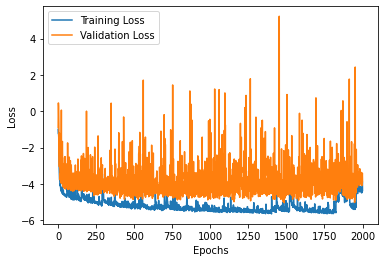

157/157 [==============================] - 7s 44ms/step - loss: -4.3648


157/157 [==============================] - 8s 45ms/step - loss: -5.2940


Epoch 1/2000
118/118 [==============================] - ETA: 0s - loss: -1.1760

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel4/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel4/assets


118/118 [==============================] - 33s 253ms/step - loss: -1.1760 - val_loss: -1.4493
Epoch 2/2000
118/118 [==============================] - ETA: 0s - loss: -2.3452

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel4/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel4/assets


118/118 [==============================] - 29s 250ms/step - loss: -2.3452 - val_loss: -2.5134
Epoch 3/2000
118/118 [==============================] - 22s 184ms/step - loss: -2.8971 - val_loss: -2.4517
Epoch 4/2000
118/118 [==============================] - ETA: 0s - loss: -3.2487

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel4/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel4/assets


118/118 [==============================] - 28s 240ms/step - loss: -3.2487 - val_loss: -2.6784
Epoch 5/2000
118/118 [==============================] - ETA: 0s - loss: -3.3911

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel4/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel4/assets


118/118 [==============================] - 30s 251ms/step - loss: -3.3911 - val_loss: -3.1196
Epoch 6/2000
118/118 [==============================] - 22s 185ms/step - loss: -3.5254 - val_loss: -2.6435
Epoch 7/2000
118/118 [==============================] - ETA: 0s - loss: -3.7283

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel4/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel4/assets


118/118 [==============================] - 29s 246ms/step - loss: -3.7283 - val_loss: -3.3642
Epoch 8/2000
118/118 [==============================] - 22s 184ms/step - loss: -3.7653 - val_loss: -2.9599
Epoch 9/2000
118/118 [==============================] - 22s 185ms/step - loss: -3.9456 - val_loss: -0.8609
Epoch 10/2000
118/118 [==============================] - 22s 188ms/step - loss: -3.8231 - val_loss: -2.7171
Epoch 11/2000
118/118 [==============================] - ETA: 0s - loss: -3.9527

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel4/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel4/assets


118/118 [==============================] - 29s 244ms/step - loss: -3.9527 - val_loss: -3.4270
Epoch 12/2000
118/118 [==============================] - ETA: 0s - loss: -4.0354

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel4/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel4/assets


118/118 [==============================] - 29s 249ms/step - loss: -4.0354 - val_loss: -3.5602
Epoch 13/2000
118/118 [==============================] - ETA: 0s - loss: -4.0705

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel4/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel4/assets


118/118 [==============================] - 29s 247ms/step - loss: -4.0705 - val_loss: -3.6529
Epoch 14/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.0495 - val_loss: -3.3501
Epoch 15/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.1442 - val_loss: -3.5224
Epoch 16/2000
118/118 [==============================] - 22s 186ms/step - loss: -3.9697 - val_loss: -2.4527
Epoch 17/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.0402 - val_loss: -3.4716
Epoch 18/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.1754 - val_loss: -3.6376
Epoch 19/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.1802 - val_loss: -2.9643
Epoch 20/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.1172 - val_loss: -3.6497
Epoch 21/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.1761 - val_loss: -3.3783
Epoch 22/2000
118/118 [===================

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel4/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel4/assets


118/118 [==============================] - 29s 245ms/step - loss: -4.2873 - val_loss: -3.7198
Epoch 24/2000
118/118 [==============================] - ETA: 0s - loss: -4.3374

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel4/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel4/assets


118/118 [==============================] - 29s 246ms/step - loss: -4.3374 - val_loss: -3.8524
Epoch 25/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.3178 - val_loss: -3.7751
Epoch 26/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.3058 - val_loss: -3.6333
Epoch 27/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.4053 - val_loss: 0.5157
Epoch 28/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.3654 - val_loss: -3.4219
Epoch 29/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.1093 - val_loss: -3.8495
Epoch 30/2000
118/118 [==============================] - 22s 189ms/step - loss: -4.2529 - val_loss: -3.1619
Epoch 31/2000
118/118 [==============================] - 22s 185ms/step - loss: -3.9631 - val_loss: -3.5526
Epoch 32/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.3876 - val_loss: -3.0349
Epoch 33/2000
118/118 [====================

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel4/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel4/assets


118/118 [==============================] - 28s 240ms/step - loss: -4.4268 - val_loss: -3.8532
Epoch 35/2000
118/118 [==============================] - ETA: 0s - loss: -4.5058

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel4/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel4/assets


118/118 [==============================] - 30s 254ms/step - loss: -4.5058 - val_loss: -3.9462
Epoch 36/2000
118/118 [==============================] - ETA: 0s - loss: -4.2899

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel4/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel4/assets


118/118 [==============================] - 29s 246ms/step - loss: -4.2899 - val_loss: -3.9627
Epoch 37/2000
118/118 [==============================] - ETA: 0s - loss: -4.4622

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel4/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel4/assets


118/118 [==============================] - 29s 247ms/step - loss: -4.4622 - val_loss: -4.0039
Epoch 38/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.4645 - val_loss: -3.9391
Epoch 39/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.5602 - val_loss: -3.9912
Epoch 40/2000
118/118 [==============================] - ETA: 0s - loss: -4.5632

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel4/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel4/assets


118/118 [==============================] - 29s 248ms/step - loss: -4.5632 - val_loss: -4.0584
Epoch 41/2000
118/118 [==============================] - ETA: 0s - loss: -4.4341

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel4/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel4/assets


118/118 [==============================] - 29s 250ms/step - loss: -4.4341 - val_loss: -4.0608
Epoch 42/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.5423 - val_loss: -3.2604
Epoch 43/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.5211 - val_loss: -3.1861
Epoch 44/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.5429 - val_loss: -3.8583
Epoch 45/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.5027 - val_loss: -4.0242
Epoch 46/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.5354 - val_loss: -2.6609
Epoch 47/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.6028 - val_loss: -3.7864
Epoch 48/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.5617 - val_loss: -4.0233
Epoch 49/2000
118/118 [==============================] - 22s 187ms/step - loss: -3.6106 - val_loss: -3.6796
Epoch 50/2000
118/118 [===================

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel4/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel4/assets


118/118 [==============================] - 29s 250ms/step - loss: -4.5007 - val_loss: -4.1895
Epoch 55/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.5441 - val_loss: -3.9730
Epoch 56/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.5633 - val_loss: -3.9100
Epoch 57/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.6257 - val_loss: -3.6066
Epoch 58/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.5471 - val_loss: -3.9725
Epoch 59/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.6248 - val_loss: -4.0746
Epoch 60/2000
118/118 [==============================] - ETA: 0s - loss: -4.6244

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel4/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel4/assets


118/118 [==============================] - 28s 239ms/step - loss: -4.6244 - val_loss: -4.2246
Epoch 61/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.6009 - val_loss: -4.0016
Epoch 62/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.6871 - val_loss: -4.2214
Epoch 63/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.5230 - val_loss: -3.4843
Epoch 64/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.5874 - val_loss: -4.0734
Epoch 65/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.6114 - val_loss: -3.9000
Epoch 66/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.6775 - val_loss: -4.1352
Epoch 67/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.6679 - val_loss: -3.9250
Epoch 68/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.6536 - val_loss: -3.9387
Epoch 69/2000
118/118 [===================

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel4/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel4/assets


118/118 [==============================] - 30s 251ms/step - loss: -4.7056 - val_loss: -4.2344
Epoch 75/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.6322 - val_loss: -3.9855
Epoch 76/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.6382 - val_loss: -3.8848
Epoch 77/2000
118/118 [==============================] - 21s 182ms/step - loss: -4.7431 - val_loss: -3.9592
Epoch 78/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.7891 - val_loss: -3.6722
Epoch 79/2000
118/118 [==============================] - 22s 184ms/step - loss: -2.6573 - val_loss: -3.6066
Epoch 80/2000
118/118 [==============================] - 22s 185ms/step - loss: -3.0680 - val_loss: -2.2156
Epoch 81/2000
118/118 [==============================] - 22s 185ms/step - loss: -3.4432 - val_loss: -3.5251
Epoch 82/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.1428 - val_loss: -3.5094
Epoch 83/2000
118/118 [===================

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel4/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel4/assets


118/118 [==============================] - 29s 249ms/step - loss: -4.8244 - val_loss: -4.2693
Epoch 108/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.7851 - val_loss: -3.5769
Epoch 109/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.8110 - val_loss: -2.9102
Epoch 110/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.7793 - val_loss: -3.4433
Epoch 111/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.7036 - val_loss: -3.7677
Epoch 112/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.8114 - val_loss: -3.8050
Epoch 113/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.8458 - val_loss: -3.6671
Epoch 114/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.8469 - val_loss: -2.4538
Epoch 115/2000
118/118 [==============================] - 22s 182ms/step - loss: -4.7534 - val_loss: -4.0002
Epoch 116/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel4/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel4/assets


118/118 [==============================] - 29s 247ms/step - loss: -4.6622 - val_loss: -4.3353
Epoch 127/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.6155 - val_loss: -2.8469
Epoch 128/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.6646 - val_loss: -4.0107
Epoch 129/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.6355 - val_loss: -4.0717
Epoch 130/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.7265 - val_loss: -3.9498
Epoch 131/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.6622 - val_loss: -4.1596
Epoch 132/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.6756 - val_loss: -3.7763
Epoch 133/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.7421 - val_loss: -4.0546
Epoch 134/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.3949 - val_loss: -4.0648
Epoch 135/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel4/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel4/assets


118/118 [==============================] - 29s 248ms/step - loss: -4.8346 - val_loss: -4.3367
Epoch 165/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.3597 - val_loss: -3.8253
Epoch 166/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.3239 - val_loss: -4.0423
Epoch 167/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.6634 - val_loss: -4.0387
Epoch 168/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.7708 - val_loss: -4.0765
Epoch 169/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.7517 - val_loss: -4.1968
Epoch 170/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.8585 - val_loss: -3.9745
Epoch 171/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.7396 - val_loss: -3.4913
Epoch 172/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.7652 - val_loss: -3.0886
Epoch 173/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel4/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel4/assets


118/118 [==============================] - 28s 239ms/step - loss: -4.9032 - val_loss: -4.3489
Epoch 187/2000
118/118 [==============================] - 22s 185ms/step - loss: -3.0955 - val_loss: -3.2954
Epoch 188/2000
118/118 [==============================] - 22s 187ms/step - loss: -3.7026 - val_loss: -3.5319
Epoch 189/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.0407 - val_loss: -4.2523
Epoch 190/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.5307 - val_loss: -4.2756
Epoch 191/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.8013 - val_loss: -2.8399
Epoch 192/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.3549 - val_loss: -4.0811
Epoch 193/2000
118/118 [==============================] - 22s 185ms/step - loss: -2.9149 - val_loss: -3.4559
Epoch 194/2000
118/118 [==============================] - 22s 184ms/step - loss: -3.4551 - val_loss: -3.6207
Epoch 195/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel4/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel4/assets


118/118 [==============================] - 30s 253ms/step - loss: -4.9776 - val_loss: -4.4028
Epoch 273/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.9222 - val_loss: -4.1955
Epoch 274/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.0380 - val_loss: -4.3161
Epoch 275/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.9743 - val_loss: -4.2289
Epoch 276/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.8584 - val_loss: -3.7152
Epoch 277/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.0000 - val_loss: -4.1195
Epoch 278/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.9474 - val_loss: -4.1463
Epoch 279/2000
118/118 [==============================] - ETA: 0s - loss: -5.0728

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel4/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel4/assets


118/118 [==============================] - 29s 249ms/step - loss: -5.0728 - val_loss: -4.5064
Epoch 280/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.9310 - val_loss: -4.0154
Epoch 281/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.0130 - val_loss: -3.0139
Epoch 282/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.8523 - val_loss: -4.3726
Epoch 283/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.6584 - val_loss: -3.7968
Epoch 284/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.8480 - val_loss: -3.4043
Epoch 285/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.9714 - val_loss: -2.6978
Epoch 286/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.9932 - val_loss: -4.1434
Epoch 287/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.8681 - val_loss: -3.6182
Epoch 288/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel4/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel4/assets


118/118 [==============================] - 29s 246ms/step - loss: -5.0222 - val_loss: -4.5469
Epoch 294/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.0265 - val_loss: -4.2437
Epoch 295/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.9694 - val_loss: -4.2119
Epoch 296/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.0681 - val_loss: -3.8292
Epoch 297/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.9960 - val_loss: -4.1392
Epoch 298/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.4509 - val_loss: -3.9594
Epoch 299/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.0026 - val_loss: -4.1310
Epoch 300/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.9921 - val_loss: -4.2059
Epoch 301/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.9844 - val_loss: -3.8340
Epoch 302/2000
118/118 [==========

118/118 [==============================] - 22s 186ms/step - loss: -4.7680 - val_loss: -1.9837
Epoch 444/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.8115 - val_loss: -3.9797
Epoch 445/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.9401 - val_loss: -3.5054
Epoch 446/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.8925 - val_loss: -4.3517
Epoch 447/2000
118/118 [==============================] - 22s 186ms/step - loss: -3.7230 - val_loss: -3.4504
Epoch 448/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.1259 - val_loss: -3.8238
Epoch 449/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.2961 - val_loss: -3.8419
Epoch 450/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.4535 - val_loss: -4.1509
Epoch 451/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.4556 - val_loss: -4.3884
Epoch 452/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel4/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel4/assets


118/118 [==============================] - 29s 248ms/step - loss: -5.2152 - val_loss: -4.5948
Epoch 537/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.8917 - val_loss: -3.8780
Epoch 538/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.2231 - val_loss: -4.3409
Epoch 539/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.0559 - val_loss: -2.9360
Epoch 540/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.2145 - val_loss: -4.0824
Epoch 541/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.1725 - val_loss: -4.4347
Epoch 542/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.2591 - val_loss: -4.1151
Epoch 543/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.0238 - val_loss: -4.1788
Epoch 544/2000
118/118 [==============================] - 22s 188ms/step - loss: -5.2730 - val_loss: -3.1878
Epoch 545/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel4/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel4/assets


118/118 [==============================] - 29s 248ms/step - loss: -5.2295 - val_loss: -4.6309
Epoch 589/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.3535 - val_loss: -4.3251
Epoch 590/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.2156 - val_loss: -4.2961
Epoch 591/2000
118/118 [==============================] - ETA: 0s - loss: -5.2037

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel4/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel4/assets


118/118 [==============================] - 30s 251ms/step - loss: -5.2037 - val_loss: -4.7188
Epoch 592/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.3157 - val_loss: -3.7337
Epoch 593/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.2050 - val_loss: -4.3070
Epoch 594/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.3304 - val_loss: -4.3429
Epoch 595/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.2883 - val_loss: -4.1144
Epoch 596/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.2355 - val_loss: -2.1035
Epoch 597/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.2979 - val_loss: -4.1099
Epoch 598/2000
118/118 [==============================] - 22s 189ms/step - loss: -5.2694 - val_loss: -4.3776
Epoch 599/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.2802 - val_loss: -3.0173
Epoch 600/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel4/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel4/assets


118/118 [==============================] - 28s 242ms/step - loss: -5.2871 - val_loss: -4.7491
Epoch 603/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.2925 - val_loss: -2.7526
Epoch 604/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.3261 - val_loss: -3.5101
Epoch 605/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.3285 - val_loss: -4.2736
Epoch 606/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.3205 - val_loss: -4.3729
Epoch 607/2000
118/118 [==============================] - 22s 188ms/step - loss: -5.2331 - val_loss: -2.9451
Epoch 608/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.3378 - val_loss: -2.5259
Epoch 609/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.0829 - val_loss: -4.2302
Epoch 610/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.9106 - val_loss: -4.0499
Epoch 611/2000
118/118 [==========

118/118 [==============================] - 22s 189ms/step - loss: -5.3067 - val_loss: -4.1371
Epoch 753/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.2974 - val_loss: -3.4063
Epoch 754/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.1971 - val_loss: -4.3562
Epoch 755/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.2584 - val_loss: -4.4964
Epoch 756/2000
118/118 [==============================] - 22s 189ms/step - loss: -5.2658 - val_loss: -3.7258
Epoch 757/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.3805 - val_loss: -3.4907
Epoch 758/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.9904 - val_loss: -3.3619
Epoch 759/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.2414 - val_loss: -4.3355
Epoch 760/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.2077 - val_loss: -4.4456
Epoch 761/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel4/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel4/assets


118/118 [==============================] - 30s 251ms/step - loss: -5.3723 - val_loss: -4.7996
Epoch 807/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.3809 - val_loss: -4.1764
Epoch 808/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.3615 - val_loss: -3.1314
Epoch 809/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.5091 - val_loss: -3.2575
Epoch 810/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.9342 - val_loss: -4.1170
Epoch 811/2000
118/118 [==============================] - 22s 182ms/step - loss: -4.9775 - val_loss: -4.2225
Epoch 812/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.9165 - val_loss: -2.8938
Epoch 813/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.1310 - val_loss: -3.8169
Epoch 814/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.1400 - val_loss: -3.9075
Epoch 815/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel4/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel4/assets


118/118 [==============================] - 29s 245ms/step - loss: -5.3231 - val_loss: -4.8024
Epoch 837/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.3789 - val_loss: -3.6531
Epoch 838/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.4450 - val_loss: -4.2474
Epoch 839/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.6322 - val_loss: -3.2802
Epoch 840/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.9671 - val_loss: -3.9754
Epoch 841/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.1971 - val_loss: -1.0531
Epoch 842/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.2066 - val_loss: -3.8356
Epoch 843/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.1999 - val_loss: -2.5946
Epoch 844/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.1804 - val_loss: -4.2657
Epoch 845/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel4/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel4/assets


118/118 [==============================] - 29s 245ms/step - loss: -5.3483 - val_loss: -4.8832
Epoch 870/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.3188 - val_loss: -4.3208
Epoch 871/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.3885 - val_loss: -4.5989
Epoch 872/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.2797 - val_loss: -3.7401
Epoch 873/2000
118/118 [==============================] - 22s 188ms/step - loss: -5.4002 - val_loss: -3.4567
Epoch 874/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.3191 - val_loss: -4.4905
Epoch 875/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.2491 - val_loss: -4.5048
Epoch 876/2000
118/118 [==============================] - 22s 188ms/step - loss: -5.3715 - val_loss: -0.2713
Epoch 877/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.3011 - val_loss: -4.2916
Epoch 878/2000
118/118 [==========

118/118 [==============================] - 22s 187ms/step - loss: -5.4218 - val_loss: -3.7402
Epoch 1020/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.5102 - val_loss: -3.6935
Epoch 1021/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.4393 - val_loss: -3.1177
Epoch 1022/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.1774 - val_loss: -3.7089
Epoch 1023/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.3292 - val_loss: -4.0922
Epoch 1024/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.3769 - val_loss: -4.4980
Epoch 1025/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.4722 - val_loss: -2.4436
Epoch 1026/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.2133 - val_loss: -4.6637
Epoch 1027/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.3569 - val_loss: -4.1865
Epoch 1028/2000
118/118 [=

118/118 [==============================] - 22s 185ms/step - loss: -5.3409 - val_loss: -4.2113
Epoch 1168/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.2127 - val_loss: -3.7976
Epoch 1169/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.3480 - val_loss: -4.3706
Epoch 1170/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.4412 - val_loss: -4.4915
Epoch 1171/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.2838 - val_loss: -4.3780
Epoch 1172/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.4307 - val_loss: -4.4622
Epoch 1173/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.4123 - val_loss: -0.6066
Epoch 1174/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.3602 - val_loss: -2.8797
Epoch 1175/2000
118/118 [==============================] - 22s 184ms/step - loss: -3.8327 - val_loss: -4.3056
Epoch 1176/2000
118/118 [=

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel4/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel4/assets


118/118 [==============================] - 29s 250ms/step - loss: -5.2815 - val_loss: -4.9704
Epoch 1193/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.2670 - val_loss: -4.8111
Epoch 1194/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.3744 - val_loss: -4.7683
Epoch 1195/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.3483 - val_loss: -4.5626
Epoch 1196/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.3602 - val_loss: -3.9573
Epoch 1197/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.2904 - val_loss: -3.8474
Epoch 1198/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.3849 - val_loss: -4.6438
Epoch 1199/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.3873 - val_loss: -4.7046
Epoch 1200/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.2906 - val_loss: -1.5273
Epoch 1201/2000
118/118 [=

118/118 [==============================] - 22s 187ms/step - loss: -5.4377 - val_loss: -3.4821
Epoch 1341/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.2574 - val_loss: -2.8629
Epoch 1342/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.4432 - val_loss: -4.2947
Epoch 1343/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.4264 - val_loss: -4.5891
Epoch 1344/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.5055 - val_loss: -4.3280
Epoch 1345/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.4651 - val_loss: -4.6257
Epoch 1346/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.5043 - val_loss: -4.0929
Epoch 1347/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.3906 - val_loss: -4.1873
Epoch 1348/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.3583 - val_loss: -4.2000
Epoch 1349/2000
118/118 [=

118/118 [==============================] - 22s 186ms/step - loss: -5.4341 - val_loss: -4.8102
Epoch 1489/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.3495 - val_loss: -4.7642
Epoch 1490/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.8397 - val_loss: -4.4521
Epoch 1491/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.1851 - val_loss: -3.6135
Epoch 1492/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.3375 - val_loss: -4.6366
Epoch 1493/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.3190 - val_loss: -4.5916
Epoch 1494/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.3057 - val_loss: -4.1779
Epoch 1495/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.4180 - val_loss: -4.5297
Epoch 1496/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.2156 - val_loss: -3.9418
Epoch 1497/2000
118/118 [=

118/118 [==============================] - 22s 186ms/step - loss: -5.4123 - val_loss: -3.6851
Epoch 1637/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.4337 - val_loss: -4.4546
Epoch 1638/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.5013 - val_loss: -3.4447
Epoch 1639/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.4786 - val_loss: -3.4209
Epoch 1640/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.4357 - val_loss: -4.6572
Epoch 1641/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.4652 - val_loss: -2.7049
Epoch 1642/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.4876 - val_loss: -3.3010
Epoch 1643/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.5228 - val_loss: -4.2685
Epoch 1644/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.4732 - val_loss: -3.8339
Epoch 1645/2000
118/118 [=

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel4/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel4/assets


118/118 [==============================] - 29s 250ms/step - loss: -5.5087 - val_loss: -4.9727
Epoch 1711/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.5472 - val_loss: -3.3536
Epoch 1712/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.4689 - val_loss: -3.9336
Epoch 1713/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.5579 - val_loss: -3.5814
Epoch 1714/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.5098 - val_loss: -4.3091
Epoch 1715/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.4592 - val_loss: 1.9200
Epoch 1716/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.4297 - val_loss: -3.9267
Epoch 1717/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.5351 - val_loss: -2.6443
Epoch 1718/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.4175 - val_loss: -3.7181
Epoch 1719/2000
118/118 [==

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel4/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel4/assets


118/118 [==============================] - 30s 253ms/step - loss: -5.3835 - val_loss: -4.9874
Epoch 1778/2000
118/118 [==============================] - 22s 188ms/step - loss: -5.4959 - val_loss: -4.2505
Epoch 1779/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.3979 - val_loss: -4.4899
Epoch 1780/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.4780 - val_loss: -4.1634
Epoch 1781/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.4872 - val_loss: -4.5227
Epoch 1782/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.4356 - val_loss: -3.4058
Epoch 1783/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.5132 - val_loss: -3.4254
Epoch 1784/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.5246 - val_loss: -3.6523
Epoch 1785/2000
118/118 [==============================] - 22s 182ms/step - loss: -5.4067 - val_loss: -4.7615
Epoch 1786/2000
118/118 [=

118/118 [==============================] - 22s 184ms/step - loss: -5.5390 - val_loss: -1.1749
Epoch 1926/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.4723 - val_loss: -3.8602
Epoch 1927/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.6326 - val_loss: -3.9797
Epoch 1928/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.1883 - val_loss: -4.4628
Epoch 1929/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.3921 - val_loss: -4.4581
Epoch 1930/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.4955 - val_loss: -1.2889
Epoch 1931/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.4398 - val_loss: -2.0832
Epoch 1932/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.3631 - val_loss: -3.9242
Epoch 1933/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.4016 - val_loss: -4.0696
Epoch 1934/2000
118/118 [=

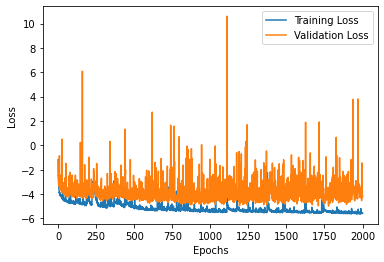

157/157 [==============================] - 7s 45ms/step - loss: -5.2029


157/157 [==============================] - 8s 45ms/step - loss: -5.1614


Epoch 1/2000
118/118 [==============================] - ETA: 0s - loss: -1.1066

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel5/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel5/assets


118/118 [==============================] - 34s 252ms/step - loss: -1.1066 - val_loss: 0.4978
Epoch 2/2000
118/118 [==============================] - ETA: 0s - loss: -1.2553

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel5/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel5/assets


118/118 [==============================] - 29s 244ms/step - loss: -1.2553 - val_loss: 0.4771
Epoch 3/2000
118/118 [==============================] - 22s 186ms/step - loss: -1.2568 - val_loss: 0.6930
Epoch 4/2000
118/118 [==============================] - 22s 189ms/step - loss: -1.3046 - val_loss: 1.1819
Epoch 5/2000
118/118 [==============================] - ETA: 0s - loss: -1.3522

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel5/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel5/assets


118/118 [==============================] - 30s 255ms/step - loss: -1.3522 - val_loss: -0.9625
Epoch 6/2000
118/118 [==============================] - ETA: 0s - loss: -2.0476

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel5/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel5/assets


118/118 [==============================] - 29s 247ms/step - loss: -2.0476 - val_loss: -1.1638
Epoch 7/2000
118/118 [==============================] - ETA: 0s - loss: -2.8280

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel5/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel5/assets


118/118 [==============================] - 29s 249ms/step - loss: -2.8280 - val_loss: -2.6601
Epoch 8/2000
118/118 [==============================] - ETA: 0s - loss: -3.2244

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel5/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel5/assets


118/118 [==============================] - 28s 240ms/step - loss: -3.2244 - val_loss: -3.0778
Epoch 9/2000
118/118 [==============================] - ETA: 0s - loss: -3.4992

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel5/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel5/assets


118/118 [==============================] - 30s 252ms/step - loss: -3.4992 - val_loss: -3.2612
Epoch 10/2000
118/118 [==============================] - ETA: 0s - loss: -3.6624

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel5/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel5/assets


118/118 [==============================] - 29s 248ms/step - loss: -3.6624 - val_loss: -3.3263
Epoch 11/2000
118/118 [==============================] - 22s 186ms/step - loss: -3.7728 - val_loss: -1.6886
Epoch 12/2000
118/118 [==============================] - ETA: 0s - loss: -3.8091

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel5/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel5/assets


118/118 [==============================] - 29s 249ms/step - loss: -3.8091 - val_loss: -3.3743
Epoch 13/2000
118/118 [==============================] - ETA: 0s - loss: -3.9448

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel5/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel5/assets


118/118 [==============================] - 29s 250ms/step - loss: -3.9448 - val_loss: -3.6514
Epoch 14/2000
118/118 [==============================] - 22s 184ms/step - loss: -3.8297 - val_loss: -2.4662
Epoch 15/2000
118/118 [==============================] - 22s 188ms/step - loss: -3.9719 - val_loss: -3.5119
Epoch 16/2000
118/118 [==============================] - 22s 187ms/step - loss: -3.9656 - val_loss: -3.3641
Epoch 17/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.0872 - val_loss: -3.1184
Epoch 18/2000
118/118 [==============================] - 22s 189ms/step - loss: -4.0873 - val_loss: -3.6084
Epoch 19/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.1033 - val_loss: -3.5042
Epoch 20/2000
118/118 [==============================] - 22s 189ms/step - loss: -3.6641 - val_loss: -2.4481
Epoch 21/2000
118/118 [==============================] - 22s 190ms/step - loss: -4.1067 - val_loss: -0.4868
Epoch 22/2000
118/118 [===================

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel5/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel5/assets


118/118 [==============================] - 28s 241ms/step - loss: -4.1211 - val_loss: -3.7097
Epoch 23/2000
118/118 [==============================] - 22s 190ms/step - loss: -4.2071 - val_loss: -3.1342
Epoch 24/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.1308 - val_loss: -3.5356
Epoch 25/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.2127 - val_loss: -2.0733
Epoch 26/2000
118/118 [==============================] - ETA: 0s - loss: -4.2131

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel5/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel5/assets


118/118 [==============================] - 30s 253ms/step - loss: -4.2131 - val_loss: -3.8512
Epoch 27/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.2452 - val_loss: -3.8321
Epoch 28/2000
118/118 [==============================] - 22s 189ms/step - loss: -4.2172 - val_loss: -3.7597
Epoch 29/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.1798 - val_loss: -3.4624
Epoch 30/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.2516 - val_loss: -3.0274
Epoch 31/2000
118/118 [==============================] - ETA: 0s - loss: -4.3408

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel5/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel5/assets


118/118 [==============================] - 29s 249ms/step - loss: -4.3408 - val_loss: -3.9411
Epoch 32/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.2132 - val_loss: -2.2119
Epoch 33/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.3555 - val_loss: -3.8132
Epoch 34/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.1523 - val_loss: -3.0592
Epoch 35/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.0282 - val_loss: -3.8863
Epoch 36/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.2910 - val_loss: -2.6679
Epoch 37/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.2484 - val_loss: -3.6917
Epoch 38/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.2743 - val_loss: -3.6690
Epoch 39/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.3872 - val_loss: -3.1510
Epoch 40/2000
118/118 [===================

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel5/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel5/assets


118/118 [==============================] - 29s 248ms/step - loss: -4.4342 - val_loss: -4.0591
Epoch 43/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.4103 - val_loss: -2.9814
Epoch 44/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.2034 - val_loss: -3.4549
Epoch 45/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.3623 - val_loss: -4.0257
Epoch 46/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.4157 - val_loss: -4.0031
Epoch 47/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.4400 - val_loss: -3.9776
Epoch 48/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.3789 - val_loss: -3.7617
Epoch 49/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.4834 - val_loss: -4.0342
Epoch 50/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.4181 - val_loss: -4.0198
Epoch 51/2000
118/118 [===================

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel5/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel5/assets


118/118 [==============================] - 29s 248ms/step - loss: -4.3992 - val_loss: -4.1468
Epoch 52/2000
118/118 [==============================] - 22s 189ms/step - loss: -4.4516 - val_loss: -4.0851
Epoch 53/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.3449 - val_loss: -3.4938
Epoch 54/2000
118/118 [==============================] - 22s 189ms/step - loss: -4.3951 - val_loss: -3.8855
Epoch 55/2000
118/118 [==============================] - 22s 189ms/step - loss: -4.3913 - val_loss: -3.7601
Epoch 56/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.4852 - val_loss: -3.9867
Epoch 57/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.4985 - val_loss: -4.0663
Epoch 58/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.4761 - val_loss: -3.8366
Epoch 59/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.3531 - val_loss: -3.7764
Epoch 60/2000
118/118 [===================

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel5/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel5/assets


118/118 [==============================] - 29s 242ms/step - loss: -4.6423 - val_loss: -4.1501
Epoch 90/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.6132 - val_loss: -3.7522
Epoch 91/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.6113 - val_loss: -4.1382
Epoch 92/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.5989 - val_loss: -3.8019
Epoch 93/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.4936 - val_loss: -2.3215
Epoch 94/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.5889 - val_loss: -4.1396
Epoch 95/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.6355 - val_loss: -3.9548
Epoch 96/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.6465 - val_loss: -3.9870
Epoch 97/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.7203 - val_loss: -4.0375
Epoch 98/2000
118/118 [===================

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel5/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel5/assets


118/118 [==============================] - 30s 255ms/step - loss: -4.7066 - val_loss: -4.2227
Epoch 101/2000
118/118 [==============================] - 22s 189ms/step - loss: -4.5495 - val_loss: -4.2071
Epoch 102/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.7094 - val_loss: -3.4710
Epoch 103/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.6394 - val_loss: -4.0579
Epoch 104/2000
118/118 [==============================] - ETA: 0s - loss: -4.2934

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel5/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel5/assets


118/118 [==============================] - 29s 250ms/step - loss: -4.2934 - val_loss: -4.2757
Epoch 105/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.4269 - val_loss: -3.9740
Epoch 106/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.7436 - val_loss: -4.1924
Epoch 107/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.6177 - val_loss: -4.1942
Epoch 108/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.6888 - val_loss: -4.1732
Epoch 109/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.1622 - val_loss: -1.1604
Epoch 110/2000
118/118 [==============================] - 22s 188ms/step - loss: -3.6111 - val_loss: -3.4599
Epoch 111/2000
118/118 [==============================] - 22s 190ms/step - loss: -4.1565 - val_loss: -2.2793
Epoch 112/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.2933 - val_loss: -3.9210
Epoch 113/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel5/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel5/assets


118/118 [==============================] - 30s 252ms/step - loss: -4.6256 - val_loss: -4.3029
Epoch 127/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.5927 - val_loss: -4.2343
Epoch 128/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.6034 - val_loss: -4.0712
Epoch 129/2000
118/118 [==============================] - 22s 189ms/step - loss: -4.5639 - val_loss: -3.4575
Epoch 130/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.7635 - val_loss: -3.7590
Epoch 131/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.5172 - val_loss: -4.2116
Epoch 132/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.7103 - val_loss: -3.4238
Epoch 133/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.6185 - val_loss: -4.2135
Epoch 134/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.6988 - val_loss: -4.1128
Epoch 135/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel5/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel5/assets


118/118 [==============================] - 28s 241ms/step - loss: -4.7131 - val_loss: -4.3443
Epoch 148/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.6508 - val_loss: -4.3076
Epoch 149/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.7511 - val_loss: -3.1680
Epoch 150/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.6528 - val_loss: -2.8543
Epoch 151/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.7489 - val_loss: -4.0272
Epoch 152/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.4761 - val_loss: -1.1143
Epoch 153/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.6866 - val_loss: -2.7937
Epoch 154/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.7470 - val_loss: -4.0306
Epoch 155/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.7487 - val_loss: -4.1972
Epoch 156/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel5/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel5/assets


118/118 [==============================] - 30s 254ms/step - loss: -4.7206 - val_loss: -4.3475
Epoch 187/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.8111 - val_loss: -2.9807
Epoch 188/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.5829 - val_loss: -4.2174
Epoch 189/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.7446 - val_loss: -4.0126
Epoch 190/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.8263 - val_loss: -4.2089
Epoch 191/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.8604 - val_loss: -3.5871
Epoch 192/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.8224 - val_loss: -4.0319
Epoch 193/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.1399 - val_loss: -4.1977
Epoch 194/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.7814 - val_loss: -3.4778
Epoch 195/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel5/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel5/assets


118/118 [==============================] - 29s 250ms/step - loss: -4.8574 - val_loss: -4.3479
Epoch 215/2000
118/118 [==============================] - 22s 189ms/step - loss: -4.7069 - val_loss: -4.2283
Epoch 216/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.9078 - val_loss: -3.7842
Epoch 217/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.7965 - val_loss: -3.7731
Epoch 218/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.7698 - val_loss: -3.9125
Epoch 219/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.9189 - val_loss: -4.1971
Epoch 220/2000
118/118 [==============================] - 22s 189ms/step - loss: -4.7730 - val_loss: -3.6650
Epoch 221/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.8016 - val_loss: -3.3255
Epoch 222/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.8853 - val_loss: -4.1775
Epoch 223/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel5/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel5/assets


118/118 [==============================] - 30s 250ms/step - loss: -4.8773 - val_loss: -4.3831
Epoch 238/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.7575 - val_loss: -3.9590
Epoch 239/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.7679 - val_loss: -4.1275
Epoch 240/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.5689 - val_loss: -3.8991
Epoch 241/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.8762 - val_loss: -4.3739
Epoch 242/2000
118/118 [==============================] - ETA: 0s - loss: -4.9218

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel5/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel5/assets


118/118 [==============================] - 29s 250ms/step - loss: -4.9218 - val_loss: -4.4319
Epoch 243/2000
118/118 [==============================] - ETA: 0s - loss: -4.9243

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel5/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel5/assets


118/118 [==============================] - 28s 240ms/step - loss: -4.9243 - val_loss: -4.4674
Epoch 244/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.7812 - val_loss: -4.2288
Epoch 245/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.9154 - val_loss: -4.0689
Epoch 246/2000
118/118 [==============================] - 22s 189ms/step - loss: -4.9834 - val_loss: -4.4309
Epoch 247/2000
118/118 [==============================] - 22s 190ms/step - loss: -4.8731 - val_loss: -3.7536
Epoch 248/2000
118/118 [==============================] - 22s 186ms/step - loss: -2.5716 - val_loss: -2.6200
Epoch 249/2000
118/118 [==============================] - 22s 185ms/step - loss: -2.8711 - val_loss: -3.4793
Epoch 250/2000
118/118 [==============================] - 22s 189ms/step - loss: -3.6006 - val_loss: -3.1689
Epoch 251/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.0517 - val_loss: -3.8160
Epoch 252/2000
118/118 [==========

118/118 [==============================] - 22s 188ms/step - loss: -4.8078 - val_loss: -3.7047
Epoch 394/2000
118/118 [==============================] - 22s 189ms/step - loss: -4.8938 - val_loss: -4.1428
Epoch 395/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.8805 - val_loss: -3.5279
Epoch 396/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.8497 - val_loss: -4.3774
Epoch 397/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.9630 - val_loss: -4.1018
Epoch 398/2000
118/118 [==============================] - 22s 188ms/step - loss: -3.3207 - val_loss: -3.4812
Epoch 399/2000
118/118 [==============================] - 22s 190ms/step - loss: -4.5380 - val_loss: -3.7407
Epoch 400/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.7963 - val_loss: -4.0097
Epoch 401/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.8034 - val_loss: -3.8483
Epoch 402/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel5/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel5/assets


118/118 [==============================] - 30s 252ms/step - loss: -4.9657 - val_loss: -4.5090
Epoch 463/2000
118/118 [==============================] - 22s 189ms/step - loss: -5.0555 - val_loss: -3.3120
Epoch 464/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.8765 - val_loss: -4.3343
Epoch 465/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.9053 - val_loss: -4.1563
Epoch 466/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.9130 - val_loss: -4.3197
Epoch 467/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.0454 - val_loss: -4.2669
Epoch 468/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.7943 - val_loss: -4.0588
Epoch 469/2000
118/118 [==============================] - 22s 189ms/step - loss: -4.9613 - val_loss: -4.3638
Epoch 470/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.0159 - val_loss: -3.6956
Epoch 471/2000
118/118 [==========

118/118 [==============================] - 22s 185ms/step - loss: -4.9409 - val_loss: -4.3063
Epoch 613/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.8943 - val_loss: -4.1665
Epoch 614/2000
118/118 [==============================] - 22s 189ms/step - loss: -4.9377 - val_loss: -4.2605
Epoch 615/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.9193 - val_loss: -3.6730
Epoch 616/2000
118/118 [==============================] - 22s 189ms/step - loss: -4.8684 - val_loss: -4.2861
Epoch 617/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.9887 - val_loss: -4.1977
Epoch 618/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.9426 - val_loss: -4.3989
Epoch 619/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.9350 - val_loss: -4.3607
Epoch 620/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.9569 - val_loss: -4.3985
Epoch 621/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel5/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel5/assets


118/118 [==============================] - 29s 249ms/step - loss: -4.9533 - val_loss: -4.5249
Epoch 645/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.9852 - val_loss: -3.6881
Epoch 646/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.9587 - val_loss: -3.3897
Epoch 647/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.9087 - val_loss: -3.9986
Epoch 648/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.9892 - val_loss: -3.3602
Epoch 649/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.0028 - val_loss: -2.7998
Epoch 650/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.8504 - val_loss: -4.2548
Epoch 651/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.9307 - val_loss: -3.6455
Epoch 652/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.9919 - val_loss: -4.2028
Epoch 653/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel5/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel5/assets


118/118 [==============================] - 30s 251ms/step - loss: -5.0442 - val_loss: -4.5266
Epoch 694/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.9953 - val_loss: -3.4842
Epoch 695/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.0728 - val_loss: -1.6794
Epoch 696/2000
118/118 [==============================] - 22s 189ms/step - loss: -3.4510 - val_loss: -3.9338
Epoch 697/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.3698 - val_loss: -2.6558
Epoch 698/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.4444 - val_loss: -4.0912
Epoch 699/2000
118/118 [==============================] - 22s 189ms/step - loss: -4.0126 - val_loss: -4.4706
Epoch 700/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.3774 - val_loss: -4.2709
Epoch 701/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.5732 - val_loss: -1.4581
Epoch 702/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel5/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel5/assets


118/118 [==============================] - 28s 242ms/step - loss: -4.4015 - val_loss: -4.5714
Epoch 703/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.6818 - val_loss: -4.2239
Epoch 704/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.5435 - val_loss: -3.8287
Epoch 705/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.7465 - val_loss: -3.7302
Epoch 706/2000
118/118 [==============================] - 22s 189ms/step - loss: -4.6965 - val_loss: -4.2658
Epoch 707/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.7452 - val_loss: -4.3630
Epoch 708/2000
118/118 [==============================] - ETA: 0s - loss: -4.8104

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel5/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel5/assets


118/118 [==============================] - 30s 255ms/step - loss: -4.8104 - val_loss: -4.6367
Epoch 709/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.6870 - val_loss: -3.4061
Epoch 710/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.7221 - val_loss: -3.6287
Epoch 711/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.8106 - val_loss: -4.2808
Epoch 712/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.7931 - val_loss: -2.6278
Epoch 713/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.7463 - val_loss: -3.9367
Epoch 714/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.7648 - val_loss: -4.3487
Epoch 715/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.8674 - val_loss: -3.9008
Epoch 716/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.7086 - val_loss: -4.4341
Epoch 717/2000
118/118 [==========

118/118 [==============================] - 22s 187ms/step - loss: -4.9701 - val_loss: -4.3135
Epoch 859/2000
118/118 [==============================] - 22s 189ms/step - loss: -4.9612 - val_loss: -3.6038
Epoch 860/2000
118/118 [==============================] - 22s 189ms/step - loss: -4.9385 - val_loss: -4.4212
Epoch 861/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.9363 - val_loss: -3.9664
Epoch 862/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.9773 - val_loss: -3.5212
Epoch 863/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.0347 - val_loss: -2.8025
Epoch 864/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.0369 - val_loss: -2.6803
Epoch 865/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.9893 - val_loss: -3.6738
Epoch 866/2000
118/118 [==============================] - 22s 190ms/step - loss: -4.9705 - val_loss: -2.8301
Epoch 867/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel5/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel5/assets


118/118 [==============================] - 30s 253ms/step - loss: -4.9766 - val_loss: -4.6856
Epoch 876/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.0599 - val_loss: -4.1982
Epoch 877/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.0161 - val_loss: -4.2478
Epoch 878/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.1145 - val_loss: -4.4339
Epoch 879/2000
118/118 [==============================] - 22s 190ms/step - loss: -4.8911 - val_loss: -4.0713
Epoch 880/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.0753 - val_loss: -3.4427
Epoch 881/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.0664 - val_loss: -4.0333
Epoch 882/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.0990 - val_loss: -4.5588
Epoch 883/2000
118/118 [==============================] - 22s 188ms/step - loss: -5.1391 - val_loss: -4.4297
Epoch 884/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel5/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel5/assets


118/118 [==============================] - 30s 252ms/step - loss: -5.0386 - val_loss: -4.7222
Epoch 946/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.1383 - val_loss: -2.0466
Epoch 947/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.0983 - val_loss: -3.3796
Epoch 948/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.0797 - val_loss: -4.3012
Epoch 949/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.9590 - val_loss: -4.4508
Epoch 950/2000
118/118 [==============================] - 22s 190ms/step - loss: -5.0712 - val_loss: -4.2461
Epoch 951/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.9329 - val_loss: -4.4908
Epoch 952/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.1301 - val_loss: -1.3124
Epoch 953/2000
118/118 [==============================] - 22s 189ms/step - loss: -5.0113 - val_loss: -2.0650
Epoch 954/2000
118/118 [==========

118/118 [==============================] - 22s 188ms/step - loss: -5.2429 - val_loss: -3.2252
Epoch 1021/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.1739 - val_loss: -4.5555
Epoch 1022/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.2446 - val_loss: -3.9232
Epoch 1023/2000
118/118 [==============================] - 22s 188ms/step - loss: -5.0046 - val_loss: -4.5844
Epoch 1024/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.2634 - val_loss: -4.3084
Epoch 1025/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.3149 - val_loss: -3.8126
Epoch 1026/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.9232 - val_loss: -1.2709
Epoch 1027/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.1947 - val_loss: -4.5099
Epoch 1028/2000
118/118 [==============================] - 22s 188ms/step - loss: -5.2444 - val_loss: -4.1911
Epoch 1029/2000
118/118 [=

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel5/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel5/assets


118/118 [==============================] - 28s 240ms/step - loss: -5.2826 - val_loss: -4.7390
Epoch 1104/2000
118/118 [==============================] - 22s 189ms/step - loss: -5.2733 - val_loss: -4.6384
Epoch 1105/2000
118/118 [==============================] - 22s 191ms/step - loss: -5.2973 - val_loss: -4.2422
Epoch 1106/2000
118/118 [==============================] - 22s 189ms/step - loss: -5.1760 - val_loss: -4.0213
Epoch 1107/2000
118/118 [==============================] - 22s 189ms/step - loss: -5.2069 - val_loss: -4.4780
Epoch 1108/2000
118/118 [==============================] - 22s 190ms/step - loss: -5.1800 - val_loss: -4.5315
Epoch 1109/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.2835 - val_loss: -4.3556
Epoch 1110/2000
118/118 [==============================] - 22s 189ms/step - loss: -5.2788 - val_loss: -3.8457
Epoch 1111/2000
118/118 [==============================] - 22s 188ms/step - loss: -5.1981 - val_loss: -4.2315
Epoch 1112/2000
118/118 [=

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel5/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel5/assets


118/118 [==============================] - 30s 255ms/step - loss: -5.3083 - val_loss: -4.7923
Epoch 1129/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.2605 - val_loss: -4.5811
Epoch 1130/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.0894 - val_loss: -4.6126
Epoch 1131/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.2291 - val_loss: -4.4881
Epoch 1132/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.2296 - val_loss: -4.2124
Epoch 1133/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.2582 - val_loss: -3.9878
Epoch 1134/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.3201 - val_loss: -4.6410
Epoch 1135/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.2753 - val_loss: -4.3719
Epoch 1136/2000
118/118 [==============================] - 22s 189ms/step - loss: -5.3076 - val_loss: -3.3443
Epoch 1137/2000
118/118 [=

118/118 [==============================] - 22s 189ms/step - loss: -5.4055 - val_loss: -3.4107
Epoch 1277/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.3586 - val_loss: -4.6099
Epoch 1278/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.3090 - val_loss: -4.6146
Epoch 1279/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.3076 - val_loss: -3.6902
Epoch 1280/2000
118/118 [==============================] - 23s 191ms/step - loss: -5.3911 - val_loss: -4.0705
Epoch 1281/2000
118/118 [==============================] - 22s 189ms/step - loss: -5.2623 - val_loss: -4.4243
Epoch 1282/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.3462 - val_loss: -4.3971
Epoch 1283/2000
118/118 [==============================] - 22s 190ms/step - loss: -5.3350 - val_loss: -2.9504
Epoch 1284/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.2977 - val_loss: -4.5722
Epoch 1285/2000
118/118 [=

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel5/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel5/assets


118/118 [==============================] - 29s 250ms/step - loss: -5.0602 - val_loss: -4.8077
Epoch 1297/2000
118/118 [==============================] - 22s 188ms/step - loss: -5.2247 - val_loss: -4.6937
Epoch 1298/2000
118/118 [==============================] - 22s 188ms/step - loss: -5.3756 - val_loss: -4.5587
Epoch 1299/2000
118/118 [==============================] - 22s 188ms/step - loss: -5.3288 - val_loss: -4.4084
Epoch 1300/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.2672 - val_loss: -4.6896
Epoch 1301/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.3805 - val_loss: -4.5415
Epoch 1302/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.3210 - val_loss: -3.7868
Epoch 1303/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.3555 - val_loss: -4.4818
Epoch 1304/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.3276 - val_loss: -4.2718
Epoch 1305/2000
118/118 [=

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel5/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel5/assets


118/118 [==============================] - 30s 254ms/step - loss: -5.4144 - val_loss: -4.8388
Epoch 1325/2000
118/118 [==============================] - 22s 188ms/step - loss: -5.2104 - val_loss: -4.2505
Epoch 1326/2000
118/118 [==============================] - 22s 189ms/step - loss: -5.3574 - val_loss: -4.1356
Epoch 1327/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.4201 - val_loss: -4.8105
Epoch 1328/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.4127 - val_loss: -4.5789
Epoch 1329/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.8454 - val_loss: -3.5585
Epoch 1330/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.2794 - val_loss: -3.5888
Epoch 1331/2000
118/118 [==============================] - 22s 188ms/step - loss: -5.3041 - val_loss: -4.4424
Epoch 1332/2000
118/118 [==============================] - 22s 189ms/step - loss: -5.1702 - val_loss: -4.5307
Epoch 1333/2000
118/118 [=

118/118 [==============================] - 22s 185ms/step - loss: -5.4156 - val_loss: -4.3376
Epoch 1473/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.2935 - val_loss: -4.5807
Epoch 1474/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.4194 - val_loss: -4.3582
Epoch 1475/2000
118/118 [==============================] - 22s 189ms/step - loss: -5.2848 - val_loss: -4.3442
Epoch 1476/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.4165 - val_loss: -2.4203
Epoch 1477/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.4065 - val_loss: -3.6431
Epoch 1478/2000
118/118 [==============================] - 22s 190ms/step - loss: -5.4078 - val_loss: -4.7877
Epoch 1479/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.3919 - val_loss: -4.8217
Epoch 1480/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.4151 - val_loss: -3.8687
Epoch 1481/2000
118/118 [=

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel5/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel5/assets


118/118 [==============================] - 29s 243ms/step - loss: -5.4098 - val_loss: -4.8688
Epoch 1549/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.3312 - val_loss: -4.3845
Epoch 1550/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.2531 - val_loss: -4.5627
Epoch 1551/2000
118/118 [==============================] - 22s 190ms/step - loss: -5.4078 - val_loss: -3.1421
Epoch 1552/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.2973 - val_loss: -4.6836
Epoch 1553/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.4269 - val_loss: -3.3639
Epoch 1554/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.3825 - val_loss: -4.1962
Epoch 1555/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.3974 - val_loss: -4.1758
Epoch 1556/2000
118/118 [==============================] - 22s 189ms/step - loss: -5.3123 - val_loss: -4.1590
Epoch 1557/2000
118/118 [=

118/118 [==============================] - 22s 188ms/step - loss: -5.3922 - val_loss: -4.1698
Epoch 1697/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.4487 - val_loss: -4.0795
Epoch 1698/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.3919 - val_loss: -4.3491
Epoch 1699/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.4713 - val_loss: -4.4427
Epoch 1700/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.3898 - val_loss: -4.3519
Epoch 1701/2000
118/118 [==============================] - 22s 188ms/step - loss: -5.4524 - val_loss: -4.1822
Epoch 1702/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.4714 - val_loss: -4.3196
Epoch 1703/2000
118/118 [==============================] - 22s 188ms/step - loss: -5.4713 - val_loss: -2.9571
Epoch 1704/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.2899 - val_loss: -4.4424
Epoch 1705/2000
118/118 [=

118/118 [==============================] - 22s 188ms/step - loss: -5.3830 - val_loss: -3.8926
Epoch 1845/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.0360 - val_loss: -3.9237
Epoch 1846/2000
118/118 [==============================] - 22s 188ms/step - loss: -5.2575 - val_loss: -4.2180
Epoch 1847/2000
118/118 [==============================] - 22s 188ms/step - loss: -5.4268 - val_loss: -3.7825
Epoch 1848/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.4517 - val_loss: -4.1733
Epoch 1849/2000
118/118 [==============================] - 22s 188ms/step - loss: -5.4046 - val_loss: -2.5774
Epoch 1850/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.4478 - val_loss: -3.8952
Epoch 1851/2000
118/118 [==============================] - 22s 189ms/step - loss: -5.3505 - val_loss: -3.7328
Epoch 1852/2000
118/118 [==============================] - 22s 188ms/step - loss: -5.5355 - val_loss: -3.8441
Epoch 1853/2000
118/118 [=

118/118 [==============================] - 22s 188ms/step - loss: -5.4748 - val_loss: -0.5236
Epoch 1993/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.5688 - val_loss: -4.0669
Epoch 1994/2000
118/118 [==============================] - 22s 189ms/step - loss: -5.5656 - val_loss: -3.5999
Epoch 1995/2000
118/118 [==============================] - 22s 188ms/step - loss: -5.5391 - val_loss: -1.3085
Epoch 1996/2000
118/118 [==============================] - 22s 188ms/step - loss: -5.4056 - val_loss: -3.3012
Epoch 1997/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.4117 - val_loss: 4.0893
Epoch 1998/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.2193 - val_loss: -2.9401
Epoch 1999/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.4975 - val_loss: -3.5375
Epoch 2000/2000
118/118 [==============================] - 22s 188ms/step - loss: -5.3389 - val_loss: -4.2529


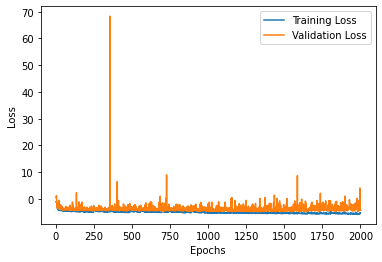

157/157 [==============================] - 7s 44ms/step - loss: -4.8215


157/157 [==============================] - 8s 44ms/step - loss: -5.2562


Epoch 1/2000
118/118 [==============================] - ETA: 0s - loss: -1.0080

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel6/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel6/assets


118/118 [==============================] - 34s 251ms/step - loss: -1.0080 - val_loss: 0.3810
Epoch 2/2000
118/118 [==============================] - 22s 188ms/step - loss: -1.2541 - val_loss: 0.4393
Epoch 3/2000
118/118 [==============================] - 22s 185ms/step - loss: -1.2564 - val_loss: 0.5682
Epoch 4/2000
118/118 [==============================] - 22s 187ms/step - loss: -1.2579 - val_loss: 0.5759
Epoch 5/2000
118/118 [==============================] - 22s 187ms/step - loss: -1.2590 - val_loss: 0.4826
Epoch 6/2000
118/118 [==============================] - 22s 187ms/step - loss: -1.2604 - val_loss: 0.5303
Epoch 7/2000
118/118 [==============================] - ETA: 0s - loss: -1.2600

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel6/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel6/assets


118/118 [==============================] - 29s 248ms/step - loss: -1.2600 - val_loss: 0.3286
Epoch 8/2000
118/118 [==============================] - 22s 187ms/step - loss: -1.2609 - val_loss: 0.5049
Epoch 9/2000
118/118 [==============================] - 22s 185ms/step - loss: -1.2607 - val_loss: 0.6761
Epoch 10/2000
118/118 [==============================] - 22s 188ms/step - loss: -1.2647 - val_loss: 0.4618
Epoch 11/2000
118/118 [==============================] - ETA: 0s - loss: -1.7370

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel6/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel6/assets


118/118 [==============================] - 29s 250ms/step - loss: -1.7370 - val_loss: -1.4211
Epoch 12/2000
118/118 [==============================] - ETA: 0s - loss: -2.7591

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel6/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel6/assets


118/118 [==============================] - 29s 249ms/step - loss: -2.7591 - val_loss: -1.6828
Epoch 13/2000
118/118 [==============================] - ETA: 0s - loss: -3.2283

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel6/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel6/assets


118/118 [==============================] - 29s 243ms/step - loss: -3.2283 - val_loss: -3.1452
Epoch 14/2000
118/118 [==============================] - 22s 187ms/step - loss: -3.5669 - val_loss: -2.3180
Epoch 15/2000
118/118 [==============================] - 22s 186ms/step - loss: -3.6219 - val_loss: -2.8606
Epoch 16/2000
118/118 [==============================] - ETA: 0s - loss: -3.7450

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel6/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel6/assets


118/118 [==============================] - 30s 252ms/step - loss: -3.7450 - val_loss: -3.4692
Epoch 17/2000
118/118 [==============================] - 22s 187ms/step - loss: -3.8886 - val_loss: -3.0646
Epoch 18/2000
118/118 [==============================] - ETA: 0s - loss: -3.9564

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel6/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel6/assets


118/118 [==============================] - 29s 249ms/step - loss: -3.9564 - val_loss: -3.5699
Epoch 19/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.0231 - val_loss: -1.3203
Epoch 20/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.0048 - val_loss: -3.4410
Epoch 21/2000
118/118 [==============================] - ETA: 0s - loss: -4.1167

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel6/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel6/assets


118/118 [==============================] - 28s 242ms/step - loss: -4.1167 - val_loss: -3.6078
Epoch 22/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.1121 - val_loss: -3.5515
Epoch 23/2000
118/118 [==============================] - 22s 189ms/step - loss: -3.9857 - val_loss: -2.0916
Epoch 24/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.0571 - val_loss: -3.1959
Epoch 25/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.1911 - val_loss: -2.5624
Epoch 26/2000
118/118 [==============================] - ETA: 0s - loss: -4.1782

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel6/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel6/assets


118/118 [==============================] - 30s 251ms/step - loss: -4.1782 - val_loss: -3.7690
Epoch 27/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.2749 - val_loss: -3.5725
Epoch 28/2000
118/118 [==============================] - ETA: 0s - loss: -4.1751

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel6/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel6/assets


118/118 [==============================] - 29s 248ms/step - loss: -4.1751 - val_loss: -3.7803
Epoch 29/2000
118/118 [==============================] - 22s 189ms/step - loss: -4.2870 - val_loss: -2.5497
Epoch 30/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.2567 - val_loss: -2.9088
Epoch 31/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.3346 - val_loss: -3.7465
Epoch 32/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.3850 - val_loss: -3.4501
Epoch 33/2000
118/118 [==============================] - ETA: 0s - loss: -4.3305

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel6/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel6/assets


118/118 [==============================] - 29s 250ms/step - loss: -4.3305 - val_loss: -3.9183
Epoch 34/2000
118/118 [==============================] - 22s 189ms/step - loss: -4.1186 - val_loss: -3.0904
Epoch 35/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.1547 - val_loss: -3.7006
Epoch 36/2000
118/118 [==============================] - ETA: 0s - loss: -4.3498

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel6/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel6/assets


118/118 [==============================] - 28s 241ms/step - loss: -4.3498 - val_loss: -3.9803
Epoch 37/2000
118/118 [==============================] - ETA: 0s - loss: -4.3988

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel6/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel6/assets


118/118 [==============================] - 30s 254ms/step - loss: -4.3988 - val_loss: -4.0127
Epoch 38/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.4099 - val_loss: -3.6294
Epoch 39/2000
118/118 [==============================] - ETA: 0s - loss: -4.4002

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel6/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel6/assets


118/118 [==============================] - 29s 249ms/step - loss: -4.4002 - val_loss: -4.1623
Epoch 40/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.4381 - val_loss: -4.0855
Epoch 41/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.4070 - val_loss: -3.7994
Epoch 42/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.3775 - val_loss: 5.2892
Epoch 43/2000
118/118 [==============================] - 22s 184ms/step - loss: -3.5431 - val_loss: -3.7204
Epoch 44/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.2775 - val_loss: -3.9143
Epoch 45/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.4164 - val_loss: -3.8996
Epoch 46/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.4134 - val_loss: -3.5658
Epoch 47/2000
118/118 [==============================] - ETA: 0s - loss: -4.4631

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel6/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel6/assets


118/118 [==============================] - 28s 241ms/step - loss: -4.4631 - val_loss: -4.1740
Epoch 48/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.4042 - val_loss: -3.9858
Epoch 49/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.4927 - val_loss: -4.0300
Epoch 50/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.2790 - val_loss: -3.8922
Epoch 51/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.5385 - val_loss: -4.1556
Epoch 52/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.4829 - val_loss: -3.9384
Epoch 53/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.4680 - val_loss: -3.4091
Epoch 54/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.1569 - val_loss: -3.6509
Epoch 55/2000
118/118 [==============================] - 22s 190ms/step - loss: -4.3357 - val_loss: -3.7268
Epoch 56/2000
118/118 [===================

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel6/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel6/assets


118/118 [==============================] - 30s 253ms/step - loss: -4.5120 - val_loss: -4.1948
Epoch 58/2000
118/118 [==============================] - 22s 189ms/step - loss: -4.5079 - val_loss: -3.7368
Epoch 59/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.5705 - val_loss: -3.8106
Epoch 60/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.5350 - val_loss: -3.9825
Epoch 61/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.5047 - val_loss: -3.8860
Epoch 62/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.5172 - val_loss: -3.6781
Epoch 63/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.5153 - val_loss: -3.9629
Epoch 64/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.5707 - val_loss: -4.1695
Epoch 65/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.5132 - val_loss: -3.8353
Epoch 66/2000
118/118 [===================

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel6/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel6/assets


118/118 [==============================] - 29s 250ms/step - loss: -4.6678 - val_loss: -4.2501
Epoch 77/2000
118/118 [==============================] - 22s 191ms/step - loss: -4.5135 - val_loss: -3.9922
Epoch 78/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.6854 - val_loss: -4.1350
Epoch 79/2000
118/118 [==============================] - 22s 189ms/step - loss: -4.6287 - val_loss: -4.0711
Epoch 80/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.5916 - val_loss: -2.0849
Epoch 81/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.6788 - val_loss: -3.6117
Epoch 82/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.5675 - val_loss: -3.6015
Epoch 83/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.5720 - val_loss: -4.1403
Epoch 84/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.6334 - val_loss: -4.2470
Epoch 85/2000
118/118 [===================

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel6/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel6/assets


118/118 [==============================] - 28s 241ms/step - loss: -4.6206 - val_loss: -4.3269
Epoch 111/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.5768 - val_loss: -3.5927
Epoch 112/2000
118/118 [==============================] - 22s 189ms/step - loss: -4.5619 - val_loss: -4.1164
Epoch 113/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.5881 - val_loss: -3.7430
Epoch 114/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.7165 - val_loss: -4.0256
Epoch 115/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.6655 - val_loss: -3.0069
Epoch 116/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.6765 - val_loss: -4.1812
Epoch 117/2000
118/118 [==============================] - 22s 189ms/step - loss: -4.6264 - val_loss: -3.9670
Epoch 118/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.6616 - val_loss: -4.1329
Epoch 119/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel6/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel6/assets


118/118 [==============================] - 30s 255ms/step - loss: -4.6612 - val_loss: -4.3315
Epoch 149/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.7237 - val_loss: -3.9622
Epoch 150/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.7473 - val_loss: -4.1009
Epoch 151/2000
118/118 [==============================] - 22s 189ms/step - loss: -4.7655 - val_loss: -2.6880
Epoch 152/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.7077 - val_loss: -3.8827
Epoch 153/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.7880 - val_loss: -3.7363
Epoch 154/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.7909 - val_loss: -4.2336
Epoch 155/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.7292 - val_loss: -3.9057
Epoch 156/2000
118/118 [==============================] - 22s 187ms/step - loss: -3.6679 - val_loss: -3.7799
Epoch 157/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel6/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel6/assets


118/118 [==============================] - 29s 250ms/step - loss: -4.7338 - val_loss: -4.3479
Epoch 194/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.7441 - val_loss: -4.1001
Epoch 195/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.7544 - val_loss: -4.0148
Epoch 196/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.6000 - val_loss: -4.0233
Epoch 197/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.7137 - val_loss: -4.1267
Epoch 198/2000
118/118 [==============================] - 22s 189ms/step - loss: -4.7764 - val_loss: -2.3783
Epoch 199/2000
118/118 [==============================] - ETA: 0s - loss: -4.7300

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel6/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel6/assets


118/118 [==============================] - 28s 242ms/step - loss: -4.7300 - val_loss: -4.4445
Epoch 200/2000
118/118 [==============================] - 22s 190ms/step - loss: -4.4886 - val_loss: -3.7132
Epoch 201/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.8363 - val_loss: -4.2545
Epoch 202/2000
118/118 [==============================] - 22s 189ms/step - loss: -4.7535 - val_loss: -3.7062
Epoch 203/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.8027 - val_loss: -4.0613
Epoch 204/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.8922 - val_loss: -3.6746
Epoch 205/2000
118/118 [==============================] - 22s 187ms/step - loss: -3.4566 - val_loss: -3.8397
Epoch 206/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.4427 - val_loss: -3.9120
Epoch 207/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.6187 - val_loss: -4.1395
Epoch 208/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel6/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel6/assets


118/118 [==============================] - 30s 253ms/step - loss: -4.8030 - val_loss: -4.5141
Epoch 252/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.7512 - val_loss: -2.8647
Epoch 253/2000
118/118 [==============================] - 22s 189ms/step - loss: -4.9172 - val_loss: -4.4413
Epoch 254/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.6585 - val_loss: -3.7318
Epoch 255/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.9957 - val_loss: -4.0280
Epoch 256/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.9113 - val_loss: -4.5030
Epoch 257/2000
118/118 [==============================] - 22s 189ms/step - loss: -4.8633 - val_loss: -0.5585
Epoch 258/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.8456 - val_loss: -4.3788
Epoch 259/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.9018 - val_loss: -3.5706
Epoch 260/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel6/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel6/assets


118/118 [==============================] - 29s 249ms/step - loss: -4.9693 - val_loss: -4.5212
Epoch 330/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.0633 - val_loss: -4.3309
Epoch 331/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.8921 - val_loss: -3.8053
Epoch 332/2000
118/118 [==============================] - 22s 190ms/step - loss: -5.0538 - val_loss: -4.2957
Epoch 333/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.4951 - val_loss: -4.0133
Epoch 334/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.9760 - val_loss: -4.1207
Epoch 335/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.9592 - val_loss: -4.0446
Epoch 336/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.9402 - val_loss: -3.6493
Epoch 337/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.9126 - val_loss: -3.0427
Epoch 338/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel6/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel6/assets


118/118 [==============================] - 30s 252ms/step - loss: -4.7639 - val_loss: -4.6011
Epoch 369/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.9981 - val_loss: -4.5303
Epoch 370/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.8692 - val_loss: -2.3600
Epoch 371/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.9511 - val_loss: -4.0632
Epoch 372/2000
118/118 [==============================] - 22s 188ms/step - loss: -5.0578 - val_loss: -2.6447
Epoch 373/2000
118/118 [==============================] - 22s 189ms/step - loss: -5.0041 - val_loss: -4.0686
Epoch 374/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.9947 - val_loss: -3.4033
Epoch 375/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.9944 - val_loss: -3.8479
Epoch 376/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.6581 - val_loss: -4.0886
Epoch 377/2000
118/118 [==========

118/118 [==============================] - 22s 183ms/step - loss: -5.1135 - val_loss: -4.2524
Epoch 519/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.0578 - val_loss: -4.2458
Epoch 520/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.9506 - val_loss: -4.4864
Epoch 521/2000
118/118 [==============================] - 22s 188ms/step - loss: -5.1330 - val_loss: -4.3696
Epoch 522/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.9891 - val_loss: -4.3999
Epoch 523/2000
118/118 [==============================] - 22s 189ms/step - loss: -5.1159 - val_loss: -4.3107
Epoch 524/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.1049 - val_loss: -3.1367
Epoch 525/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.1093 - val_loss: -3.6381
Epoch 526/2000
118/118 [==============================] - 22s 188ms/step - loss: -5.0503 - val_loss: -3.8811
Epoch 527/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel6/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel6/assets


118/118 [==============================] - 28s 241ms/step - loss: -5.1574 - val_loss: -4.6324
Epoch 533/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.0702 - val_loss: -3.1746
Epoch 534/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.1197 - val_loss: -3.0972
Epoch 535/2000
118/118 [==============================] - 22s 189ms/step - loss: -5.0725 - val_loss: -4.1799
Epoch 536/2000
118/118 [==============================] - 22s 188ms/step - loss: -5.1018 - val_loss: -4.3329
Epoch 537/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.4897 - val_loss: -3.7151
Epoch 538/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.0192 - val_loss: -3.4885
Epoch 539/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.0576 - val_loss: -3.6774
Epoch 540/2000
118/118 [==============================] - 22s 188ms/step - loss: -5.0943 - val_loss: -4.4554
Epoch 541/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel6/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel6/assets


118/118 [==============================] - 30s 251ms/step - loss: -5.2075 - val_loss: -4.6581
Epoch 652/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.1717 - val_loss: -4.0065
Epoch 653/2000
118/118 [==============================] - 22s 189ms/step - loss: -5.0565 - val_loss: -3.8661
Epoch 654/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.0669 - val_loss: -3.8671
Epoch 655/2000
118/118 [==============================] - 22s 188ms/step - loss: -5.1569 - val_loss: -4.1168
Epoch 656/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.0944 - val_loss: -3.8323
Epoch 657/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.1897 - val_loss: -4.4931
Epoch 658/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.1415 - val_loss: -3.7666
Epoch 659/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.1819 - val_loss: -4.2559
Epoch 660/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel6/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel6/assets


118/118 [==============================] - 29s 249ms/step - loss: -5.2904 - val_loss: -4.6666
Epoch 714/2000
118/118 [==============================] - 22s 189ms/step - loss: -4.4574 - val_loss: -3.4403
Epoch 715/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.7532 - val_loss: -4.2035
Epoch 716/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.9412 - val_loss: -4.5183
Epoch 717/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.0602 - val_loss: -4.2464
Epoch 718/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.0221 - val_loss: -4.0197
Epoch 719/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.1688 - val_loss: -3.9742
Epoch 720/2000
118/118 [==============================] - 22s 189ms/step - loss: -5.0379 - val_loss: -4.4575
Epoch 721/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.1720 - val_loss: -4.0911
Epoch 722/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel6/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel6/assets


118/118 [==============================] - 28s 240ms/step - loss: -5.1671 - val_loss: -4.7043
Epoch 848/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.3047 - val_loss: -3.1446
Epoch 849/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.2428 - val_loss: -3.2602
Epoch 850/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.3192 - val_loss: -3.4392
Epoch 851/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.3468 - val_loss: -3.6668
Epoch 852/2000
118/118 [==============================] - 22s 188ms/step - loss: -5.2467 - val_loss: -4.4010
Epoch 853/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.3946 - val_loss: -2.7247
Epoch 854/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.3512 - val_loss: -4.1847
Epoch 855/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.0957 - val_loss: -4.0619
Epoch 856/2000
118/118 [==========

118/118 [==============================] - 22s 187ms/step - loss: -5.0606 - val_loss: -4.6768
Epoch 998/2000
118/118 [==============================] - 22s 189ms/step - loss: -5.1366 - val_loss: -3.3879
Epoch 999/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.1056 - val_loss: -4.6426
Epoch 1000/2000
118/118 [==============================] - 22s 188ms/step - loss: -5.1545 - val_loss: -3.0058
Epoch 1001/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.1825 - val_loss: -4.4350
Epoch 1002/2000
118/118 [==============================] - 22s 188ms/step - loss: -5.2195 - val_loss: -4.5043
Epoch 1003/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.0716 - val_loss: -3.9587
Epoch 1004/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.1563 - val_loss: -0.1329
Epoch 1005/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.2185 - val_loss: -4.4102
Epoch 1006/2000
118/118 [===

118/118 [==============================] - 22s 186ms/step - loss: -5.3544 - val_loss: -3.8935
Epoch 1146/2000
118/118 [==============================] - 22s 188ms/step - loss: -5.4205 - val_loss: -3.7707
Epoch 1147/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.3262 - val_loss: -4.2031
Epoch 1148/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.2632 - val_loss: -3.1647
Epoch 1149/2000
118/118 [==============================] - 22s 188ms/step - loss: -5.3541 - val_loss: -4.3256
Epoch 1150/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.4510 - val_loss: -4.0153
Epoch 1151/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.3268 - val_loss: -4.1766
Epoch 1152/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.3365 - val_loss: -3.9809
Epoch 1153/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.2944 - val_loss: -4.4457
Epoch 1154/2000
118/118 [=

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel6/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel6/assets


118/118 [==============================] - 30s 255ms/step - loss: -5.4198 - val_loss: -4.8066
Epoch 1261/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.3281 - val_loss: -4.4294
Epoch 1262/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.4843 - val_loss: -3.9399
Epoch 1263/2000
118/118 [==============================] - 22s 188ms/step - loss: -5.4542 - val_loss: -3.0220
Epoch 1264/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.4103 - val_loss: -1.9830
Epoch 1265/2000
118/118 [==============================] - 22s 188ms/step - loss: -5.3735 - val_loss: -3.6919
Epoch 1266/2000
118/118 [==============================] - 22s 190ms/step - loss: -5.4528 - val_loss: -4.3683
Epoch 1267/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.3758 - val_loss: -4.2650
Epoch 1268/2000
118/118 [==============================] - 22s 189ms/step - loss: -5.4290 - val_loss: -4.1761
Epoch 1269/2000
118/118 [=

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel6/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel6/assets


118/118 [==============================] - 29s 247ms/step - loss: -5.3132 - val_loss: -4.8252
Epoch 1333/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.2256 - val_loss: -3.8243
Epoch 1334/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.3282 - val_loss: -4.2855
Epoch 1335/2000
118/118 [==============================] - 22s 188ms/step - loss: -5.3492 - val_loss: -4.3295
Epoch 1336/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.0333 - val_loss: -4.5354
Epoch 1337/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.3498 - val_loss: -3.9565
Epoch 1338/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.3409 - val_loss: -4.5606
Epoch 1339/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.3097 - val_loss: -3.7865
Epoch 1340/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.3305 - val_loss: 1.6853
Epoch 1341/2000
118/118 [==

118/118 [==============================] - 22s 186ms/step - loss: -5.3950 - val_loss: -4.4256
Epoch 1481/2000
118/118 [==============================] - 22s 190ms/step - loss: -5.4132 - val_loss: -4.1342
Epoch 1482/2000
118/118 [==============================] - 22s 189ms/step - loss: -5.4115 - val_loss: -4.0456
Epoch 1483/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.1967 - val_loss: -4.2679
Epoch 1484/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.4303 - val_loss: -4.2556
Epoch 1485/2000
118/118 [==============================] - 22s 189ms/step - loss: -5.4597 - val_loss: -4.0103
Epoch 1486/2000
118/118 [==============================] - 22s 189ms/step - loss: -5.3290 - val_loss: -4.2828
Epoch 1487/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.3823 - val_loss: -4.5690
Epoch 1488/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.2440 - val_loss: -4.2523
Epoch 1489/2000
118/118 [=

118/118 [==============================] - 22s 187ms/step - loss: -5.5336 - val_loss: -4.1736
Epoch 1629/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.4567 - val_loss: -4.3983
Epoch 1630/2000
118/118 [==============================] - 22s 188ms/step - loss: -5.4405 - val_loss: -4.2625
Epoch 1631/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.5022 - val_loss: -4.2223
Epoch 1632/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.3517 - val_loss: -4.1517
Epoch 1633/2000
118/118 [==============================] - 22s 191ms/step - loss: -5.5342 - val_loss: -4.4418
Epoch 1634/2000
118/118 [==============================] - 22s 188ms/step - loss: -5.4113 - val_loss: -3.8513
Epoch 1635/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.4910 - val_loss: 3.0638
Epoch 1636/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.3299 - val_loss: -4.6843
Epoch 1637/2000
118/118 [==

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel6/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel6/assets


118/118 [==============================] - 30s 252ms/step - loss: -5.4716 - val_loss: -4.9180
Epoch 1689/2000
118/118 [==============================] - 22s 189ms/step - loss: -5.4934 - val_loss: -4.3299
Epoch 1690/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.4667 - val_loss: -3.6693
Epoch 1691/2000
118/118 [==============================] - 22s 188ms/step - loss: -5.5377 - val_loss: -4.5811
Epoch 1692/2000
118/118 [==============================] - 22s 188ms/step - loss: -5.4595 - val_loss: -4.4002
Epoch 1693/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.5228 - val_loss: -4.6366
Epoch 1694/2000
118/118 [==============================] - 22s 190ms/step - loss: -5.5198 - val_loss: -3.1832
Epoch 1695/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.5102 - val_loss: -3.2257
Epoch 1696/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.5124 - val_loss: -4.3064
Epoch 1697/2000
118/118 [=

118/118 [==============================] - 22s 187ms/step - loss: -5.4413 - val_loss: -4.1649
Epoch 1837/2000
118/118 [==============================] - 22s 188ms/step - loss: -3.7529 - val_loss: -4.5021
Epoch 1838/2000
118/118 [==============================] - 22s 189ms/step - loss: -4.8920 - val_loss: -3.5633
Epoch 1839/2000
118/118 [==============================] - 22s 188ms/step - loss: -5.2126 - val_loss: -4.5799
Epoch 1840/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.3022 - val_loss: -4.2722
Epoch 1841/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.3902 - val_loss: -4.5877
Epoch 1842/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.2816 - val_loss: -4.6468
Epoch 1843/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.3178 - val_loss: -4.1900
Epoch 1844/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.4166 - val_loss: -4.5038
Epoch 1845/2000
118/118 [=

118/118 [==============================] - 22s 186ms/step - loss: -5.5144 - val_loss: -4.4570
Epoch 1985/2000
118/118 [==============================] - 22s 188ms/step - loss: -5.5990 - val_loss: -3.7651
Epoch 1986/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.4394 - val_loss: -3.9353
Epoch 1987/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.5617 - val_loss: -4.1446
Epoch 1988/2000
118/118 [==============================] - 22s 191ms/step - loss: -5.5962 - val_loss: -4.2977
Epoch 1989/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.5254 - val_loss: -4.3484
Epoch 1990/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.5702 - val_loss: -4.5879
Epoch 1991/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.5624 - val_loss: -4.6773
Epoch 1992/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.4422 - val_loss: -4.1704
Epoch 1993/2000
118/118 [=

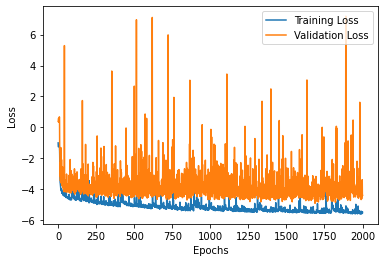

157/157 [==============================] - 7s 45ms/step - loss: -5.2499


157/157 [==============================] - 8s 45ms/step - loss: -5.3993


Epoch 1/2000
118/118 [==============================] - ETA: 0s - loss: -1.0667

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel7/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel7/assets


118/118 [==============================] - 35s 254ms/step - loss: -1.0667 - val_loss: 0.4095
Epoch 2/2000
118/118 [==============================] - 22s 188ms/step - loss: -1.2526 - val_loss: 0.4626
Epoch 3/2000
118/118 [==============================] - 22s 188ms/step - loss: -1.2559 - val_loss: 0.5750
Epoch 4/2000
118/118 [==============================] - 22s 187ms/step - loss: -1.2580 - val_loss: 0.4866
Epoch 5/2000
118/118 [==============================] - 22s 187ms/step - loss: -1.2593 - val_loss: 0.5548
Epoch 6/2000
118/118 [==============================] - 22s 188ms/step - loss: -1.2605 - val_loss: 0.5892
Epoch 7/2000
118/118 [==============================] - ETA: 0s - loss: -1.2607

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel7/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel7/assets


118/118 [==============================] - 29s 244ms/step - loss: -1.2607 - val_loss: 0.3824
Epoch 8/2000
118/118 [==============================] - 22s 190ms/step - loss: -1.2612 - val_loss: 0.5261
Epoch 9/2000
118/118 [==============================] - 22s 186ms/step - loss: -1.2612 - val_loss: 0.6899
Epoch 10/2000
118/118 [==============================] - 22s 190ms/step - loss: -1.2618 - val_loss: 0.3896
Epoch 11/2000
118/118 [==============================] - ETA: 0s - loss: -1.2618

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel7/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel7/assets


118/118 [==============================] - 30s 258ms/step - loss: -1.2618 - val_loss: 0.3245
Epoch 12/2000
118/118 [==============================] - 22s 186ms/step - loss: -1.2626 - val_loss: 0.4837
Epoch 13/2000
118/118 [==============================] - ETA: 0s - loss: -1.2618

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel7/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel7/assets


118/118 [==============================] - 29s 242ms/step - loss: -1.2618 - val_loss: 0.3110
Epoch 14/2000
118/118 [==============================] - 22s 188ms/step - loss: -1.2609 - val_loss: 0.7849
Epoch 15/2000
118/118 [==============================] - 22s 186ms/step - loss: -1.2607 - val_loss: 0.5521
Epoch 16/2000
118/118 [==============================] - 22s 187ms/step - loss: -1.2620 - val_loss: 0.7148
Epoch 17/2000
118/118 [==============================] - 22s 187ms/step - loss: -1.2618 - val_loss: 0.5734
Epoch 18/2000
118/118 [==============================] - 22s 190ms/step - loss: -1.2621 - val_loss: 0.7117
Epoch 19/2000
118/118 [==============================] - 22s 186ms/step - loss: -1.2615 - val_loss: 0.7297
Epoch 20/2000
118/118 [==============================] - 22s 186ms/step - loss: -1.2614 - val_loss: 0.3875
Epoch 21/2000
118/118 [==============================] - 22s 187ms/step - loss: -1.2616 - val_loss: 0.4117
Epoch 22/2000
118/118 [============================

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel7/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel7/assets


118/118 [==============================] - 30s 253ms/step - loss: -1.8419 - val_loss: -0.2093
Epoch 33/2000
118/118 [==============================] - ETA: 0s - loss: -2.4830

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel7/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel7/assets


118/118 [==============================] - 29s 250ms/step - loss: -2.4830 - val_loss: -2.4194
Epoch 34/2000
118/118 [==============================] - ETA: 0s - loss: -3.1961

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel7/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel7/assets


118/118 [==============================] - 29s 242ms/step - loss: -3.1961 - val_loss: -2.9353
Epoch 35/2000
118/118 [==============================] - ETA: 0s - loss: -3.5474

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel7/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel7/assets


118/118 [==============================] - 30s 253ms/step - loss: -3.5474 - val_loss: -3.0230
Epoch 36/2000
118/118 [==============================] - ETA: 0s - loss: -3.6765

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel7/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel7/assets


118/118 [==============================] - 30s 252ms/step - loss: -3.6765 - val_loss: -3.3520
Epoch 37/2000
118/118 [==============================] - 22s 188ms/step - loss: -3.7890 - val_loss: -3.2432
Epoch 38/2000
118/118 [==============================] - 22s 188ms/step - loss: -3.8630 - val_loss: -3.1572
Epoch 39/2000
118/118 [==============================] - 22s 186ms/step - loss: -3.9279 - val_loss: -2.7931
Epoch 40/2000
118/118 [==============================] - ETA: 0s - loss: -3.9741

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel7/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel7/assets


118/118 [==============================] - 30s 253ms/step - loss: -3.9741 - val_loss: -3.6397
Epoch 41/2000
118/118 [==============================] - 22s 189ms/step - loss: -3.9957 - val_loss: -3.3269
Epoch 42/2000
118/118 [==============================] - ETA: 0s - loss: -4.0170

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel7/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel7/assets


118/118 [==============================] - 28s 242ms/step - loss: -4.0170 - val_loss: -3.6991
Epoch 43/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.0116 - val_loss: -2.6179
Epoch 44/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.0749 - val_loss: -3.6827
Epoch 45/2000
118/118 [==============================] - ETA: 0s - loss: -4.0487

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel7/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel7/assets


118/118 [==============================] - 30s 256ms/step - loss: -4.0487 - val_loss: -3.8260
Epoch 46/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.0178 - val_loss: -3.3258
Epoch 47/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.0982 - val_loss: -3.7517
Epoch 48/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.1528 - val_loss: -2.0859
Epoch 49/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.1853 - val_loss: -3.7877
Epoch 50/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.2519 - val_loss: -3.5193
Epoch 51/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.1578 - val_loss: -3.0277
Epoch 52/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.1101 - val_loss: -3.4449
Epoch 53/2000
118/118 [==============================] - 22s 189ms/step - loss: -4.1435 - val_loss: -3.7234
Epoch 54/2000
118/118 [===================

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel7/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel7/assets


118/118 [==============================] - 29s 246ms/step - loss: -4.2640 - val_loss: -3.8924
Epoch 55/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.2926 - val_loss: -3.6499
Epoch 56/2000
118/118 [==============================] - ETA: 0s - loss: -4.3316

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel7/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel7/assets


118/118 [==============================] - 30s 252ms/step - loss: -4.3316 - val_loss: -3.9738
Epoch 57/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.2890 - val_loss: -3.7972
Epoch 58/2000
118/118 [==============================] - ETA: 0s - loss: -4.2530

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel7/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel7/assets


118/118 [==============================] - 30s 252ms/step - loss: -4.2530 - val_loss: -4.0217
Epoch 59/2000
118/118 [==============================] - 22s 190ms/step - loss: -4.2682 - val_loss: -3.9261
Epoch 60/2000
118/118 [==============================] - 22s 186ms/step - loss: -3.9983 - val_loss: -3.8259
Epoch 61/2000
118/118 [==============================] - 22s 190ms/step - loss: -4.3122 - val_loss: -3.7232
Epoch 62/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.3767 - val_loss: -3.9932
Epoch 63/2000
118/118 [==============================] - 22s 190ms/step - loss: -4.0777 - val_loss: -3.1531
Epoch 64/2000
118/118 [==============================] - 22s 186ms/step - loss: -3.7240 - val_loss: -3.6698
Epoch 65/2000
118/118 [==============================] - 22s 190ms/step - loss: -4.2628 - val_loss: -3.9363
Epoch 66/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.2381 - val_loss: -3.6709
Epoch 67/2000
118/118 [===================

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel7/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel7/assets


118/118 [==============================] - 29s 244ms/step - loss: -4.4783 - val_loss: -4.1284
Epoch 85/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.4373 - val_loss: -4.1245
Epoch 86/2000
118/118 [==============================] - 22s 188ms/step - loss: -3.5429 - val_loss: -3.9312
Epoch 87/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.2953 - val_loss: -2.7424
Epoch 88/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.4422 - val_loss: -4.0132
Epoch 89/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.4678 - val_loss: -3.5440
Epoch 90/2000
118/118 [==============================] - ETA: 0s - loss: -4.4341

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel7/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel7/assets


118/118 [==============================] - 30s 255ms/step - loss: -4.4341 - val_loss: -4.1890
Epoch 91/2000
118/118 [==============================] - ETA: 0s - loss: -4.4971

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel7/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel7/assets


118/118 [==============================] - 29s 250ms/step - loss: -4.4971 - val_loss: -4.1921
Epoch 92/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.4599 - val_loss: -3.9597
Epoch 93/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.5469 - val_loss: -4.0678
Epoch 94/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.4391 - val_loss: -3.8319
Epoch 95/2000
118/118 [==============================] - 22s 189ms/step - loss: -4.5044 - val_loss: -3.4316
Epoch 96/2000
118/118 [==============================] - 22s 190ms/step - loss: -4.5025 - val_loss: -3.6037
Epoch 97/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.5854 - val_loss: -4.0833
Epoch 98/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.6110 - val_loss: -3.6818
Epoch 99/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.5056 - val_loss: -3.6819
Epoch 100/2000
118/118 [==================

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel7/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel7/assets


118/118 [==============================] - 30s 254ms/step - loss: -4.5433 - val_loss: -4.2366
Epoch 107/2000
118/118 [==============================] - 22s 190ms/step - loss: -4.5284 - val_loss: -4.0983
Epoch 108/2000
118/118 [==============================] - 22s 189ms/step - loss: -4.3553 - val_loss: -4.2064
Epoch 109/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.5935 - val_loss: -3.8570
Epoch 110/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.5645 - val_loss: -3.6561
Epoch 111/2000
118/118 [==============================] - 22s 189ms/step - loss: -4.6404 - val_loss: -3.3535
Epoch 112/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.3885 - val_loss: -4.0908
Epoch 113/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.5458 - val_loss: -2.4516
Epoch 114/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.5886 - val_loss: -3.8912
Epoch 115/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel7/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel7/assets


118/118 [==============================] - 29s 242ms/step - loss: -4.6378 - val_loss: -4.3063
Epoch 121/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.5017 - val_loss: -4.1976
Epoch 122/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.6387 - val_loss: -2.3444
Epoch 123/2000
118/118 [==============================] - 22s 189ms/step - loss: -4.5756 - val_loss: -3.6642
Epoch 124/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.5792 - val_loss: -2.9281
Epoch 125/2000
118/118 [==============================] - 22s 189ms/step - loss: -4.6294 - val_loss: -3.5773
Epoch 126/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.5731 - val_loss: -4.1198
Epoch 127/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.6238 - val_loss: -3.3756
Epoch 128/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.6799 - val_loss: -3.7444
Epoch 129/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel7/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel7/assets


118/118 [==============================] - 30s 252ms/step - loss: -4.6350 - val_loss: -4.3069
Epoch 196/2000
118/118 [==============================] - 22s 189ms/step - loss: -4.6685 - val_loss: -3.8316
Epoch 197/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.6678 - val_loss: -4.1608
Epoch 198/2000
118/118 [==============================] - 22s 189ms/step - loss: -4.6509 - val_loss: -4.1554
Epoch 199/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.4639 - val_loss: -4.2070
Epoch 200/2000
118/118 [==============================] - ETA: 0s - loss: -4.7022

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel7/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel7/assets


118/118 [==============================] - 29s 243ms/step - loss: -4.7022 - val_loss: -4.3151
Epoch 201/2000
118/118 [==============================] - 22s 189ms/step - loss: -4.7201 - val_loss: -4.0010
Epoch 202/2000
118/118 [==============================] - 22s 189ms/step - loss: -4.6216 - val_loss: -3.2105
Epoch 203/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.6690 - val_loss: -4.2823
Epoch 204/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.7665 - val_loss: -1.4260
Epoch 205/2000
118/118 [==============================] - 22s 189ms/step - loss: -4.6008 - val_loss: -3.9452
Epoch 206/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.6762 - val_loss: -4.1586
Epoch 207/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.7035 - val_loss: -3.4382
Epoch 208/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.6760 - val_loss: -4.1030
Epoch 209/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel7/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel7/assets


118/118 [==============================] - 30s 255ms/step - loss: -4.7561 - val_loss: -4.3612
Epoch 227/2000
118/118 [==============================] - 22s 190ms/step - loss: -4.1241 - val_loss: -4.1558
Epoch 228/2000
118/118 [==============================] - 22s 190ms/step - loss: -4.7411 - val_loss: -3.7801
Epoch 229/2000
118/118 [==============================] - 22s 190ms/step - loss: -4.7005 - val_loss: -4.0497
Epoch 230/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.6433 - val_loss: -4.0913
Epoch 231/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.7474 - val_loss: -3.7598
Epoch 232/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.7035 - val_loss: -4.2482
Epoch 233/2000
118/118 [==============================] - 22s 189ms/step - loss: -4.7224 - val_loss: -1.0100
Epoch 234/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.1183 - val_loss: -3.9204
Epoch 235/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel7/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel7/assets


118/118 [==============================] - 30s 251ms/step - loss: -4.8051 - val_loss: -4.3642
Epoch 256/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.7824 - val_loss: -4.1180
Epoch 257/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.7654 - val_loss: -4.3020
Epoch 258/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.6785 - val_loss: -4.3418
Epoch 259/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.8283 - val_loss: -3.6862
Epoch 260/2000
118/118 [==============================] - 22s 189ms/step - loss: -4.7540 - val_loss: -4.2217
Epoch 261/2000
118/118 [==============================] - 22s 190ms/step - loss: -4.7166 - val_loss: -4.3198
Epoch 262/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.7943 - val_loss: -3.7636
Epoch 263/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.8175 - val_loss: -4.1062
Epoch 264/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel7/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel7/assets


118/118 [==============================] - 30s 255ms/step - loss: -4.7244 - val_loss: -4.4118
Epoch 280/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.8538 - val_loss: -4.1551
Epoch 281/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.5868 - val_loss: -3.9058
Epoch 282/2000
118/118 [==============================] - 22s 189ms/step - loss: -4.8314 - val_loss: -4.1234
Epoch 283/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.8815 - val_loss: -2.8854
Epoch 284/2000
118/118 [==============================] - 22s 189ms/step - loss: -4.6904 - val_loss: -3.8170
Epoch 285/2000
118/118 [==============================] - 22s 189ms/step - loss: -4.8576 - val_loss: -2.3984
Epoch 286/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.8393 - val_loss: -3.6526
Epoch 287/2000
118/118 [==============================] - 22s 189ms/step - loss: -4.8546 - val_loss: -3.8600
Epoch 288/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel7/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel7/assets


118/118 [==============================] - 29s 243ms/step - loss: -4.8529 - val_loss: -4.4772
Epoch 335/2000
118/118 [==============================] - 22s 189ms/step - loss: -4.7331 - val_loss: -4.1530
Epoch 336/2000
118/118 [==============================] - 22s 189ms/step - loss: -4.6757 - val_loss: -4.2695
Epoch 337/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.8577 - val_loss: -3.7058
Epoch 338/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.8482 - val_loss: -4.4159
Epoch 339/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.7661 - val_loss: -4.2919
Epoch 340/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.8212 - val_loss: -3.9323
Epoch 341/2000
118/118 [==============================] - 22s 190ms/step - loss: -4.8157 - val_loss: -3.2319
Epoch 342/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.9236 - val_loss: -3.8545
Epoch 343/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel7/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel7/assets


118/118 [==============================] - 30s 257ms/step - loss: -4.8177 - val_loss: -4.5513
Epoch 369/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.8258 - val_loss: -4.2384
Epoch 370/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.8856 - val_loss: -3.6233
Epoch 371/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.8234 - val_loss: -3.4927
Epoch 372/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.8583 - val_loss: -2.3765
Epoch 373/2000
118/118 [==============================] - 22s 190ms/step - loss: -4.8304 - val_loss: -2.7794
Epoch 374/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.8348 - val_loss: -4.0342
Epoch 375/2000
118/118 [==============================] - 22s 189ms/step - loss: -4.8260 - val_loss: -3.5276
Epoch 376/2000
118/118 [==============================] - 22s 190ms/step - loss: -4.9041 - val_loss: -3.6373
Epoch 377/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel7/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel7/assets


118/118 [==============================] - 29s 244ms/step - loss: -4.9674 - val_loss: -4.5831
Epoch 433/2000
118/118 [==============================] - 22s 190ms/step - loss: -4.8464 - val_loss: -3.9811
Epoch 434/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.9482 - val_loss: -3.9028
Epoch 435/2000
118/118 [==============================] - 22s 190ms/step - loss: -4.9169 - val_loss: -4.2005
Epoch 436/2000
118/118 [==============================] - 22s 189ms/step - loss: -4.7763 - val_loss: -3.8751
Epoch 437/2000
118/118 [==============================] - 22s 188ms/step - loss: -5.0198 - val_loss: -4.3610
Epoch 438/2000
118/118 [==============================] - 22s 190ms/step - loss: -4.8649 - val_loss: -4.3703
Epoch 439/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.9873 - val_loss: -3.9582
Epoch 440/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.9536 - val_loss: -4.4598
Epoch 441/2000
118/118 [==========

118/118 [==============================] - 22s 187ms/step - loss: -4.9847 - val_loss: -3.8221
Epoch 583/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.9089 - val_loss: -2.9363
Epoch 584/2000
118/118 [==============================] - 22s 190ms/step - loss: -4.9307 - val_loss: -3.6426
Epoch 585/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.9211 - val_loss: -4.0561
Epoch 586/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.8944 - val_loss: -4.3382
Epoch 587/2000
118/118 [==============================] - 22s 189ms/step - loss: -4.2018 - val_loss: -2.7911
Epoch 588/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.9304 - val_loss: -4.2326
Epoch 589/2000
118/118 [==============================] - 22s 189ms/step - loss: -4.7671 - val_loss: -3.9385
Epoch 590/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.5994 - val_loss: -4.2342
Epoch 591/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel7/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel7/assets


118/118 [==============================] - 30s 255ms/step - loss: -5.0164 - val_loss: -4.5889
Epoch 654/2000
118/118 [==============================] - 22s 188ms/step - loss: -5.0580 - val_loss: -4.2314
Epoch 655/2000
118/118 [==============================] - 22s 188ms/step - loss: -5.0280 - val_loss: -4.4283
Epoch 656/2000
118/118 [==============================] - 22s 190ms/step - loss: -4.9919 - val_loss: -3.7611
Epoch 657/2000
118/118 [==============================] - ETA: 0s - loss: -5.0834

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel7/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel7/assets


118/118 [==============================] - 30s 253ms/step - loss: -5.0834 - val_loss: -4.6201
Epoch 658/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.9786 - val_loss: -4.0220
Epoch 659/2000
118/118 [==============================] - 22s 188ms/step - loss: -5.0614 - val_loss: -3.6778
Epoch 660/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.0393 - val_loss: -3.8923
Epoch 661/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.9263 - val_loss: -4.0946
Epoch 662/2000
118/118 [==============================] - 22s 189ms/step - loss: -4.9716 - val_loss: -4.5313
Epoch 663/2000
118/118 [==============================] - 22s 188ms/step - loss: -5.0415 - val_loss: -4.2304
Epoch 664/2000
118/118 [==============================] - 22s 188ms/step - loss: -4.9913 - val_loss: -4.1851
Epoch 665/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.0626 - val_loss: -4.1102
Epoch 666/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel7/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel7/assets


118/118 [==============================] - 29s 244ms/step - loss: -5.0945 - val_loss: -4.6529
Epoch 767/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.0179 - val_loss: -4.4095
Epoch 768/2000
118/118 [==============================] - 22s 188ms/step - loss: -5.0732 - val_loss: -4.1947
Epoch 769/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.0505 - val_loss: -4.4443
Epoch 770/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.0439 - val_loss: -3.9955
Epoch 771/2000
118/118 [==============================] - 22s 189ms/step - loss: -5.1017 - val_loss: -3.9962
Epoch 772/2000
118/118 [==============================] - 22s 188ms/step - loss: -5.1379 - val_loss: -4.4399
Epoch 773/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.1156 - val_loss: -4.2913
Epoch 774/2000
118/118 [==============================] - ETA: 0s - loss: -5.1750

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel7/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel7/assets


118/118 [==============================] - 30s 257ms/step - loss: -5.1750 - val_loss: -4.6567
Epoch 775/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.0590 - val_loss: -4.3122
Epoch 776/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.0010 - val_loss: -4.3594
Epoch 777/2000
118/118 [==============================] - 22s 189ms/step - loss: -5.1426 - val_loss: -4.5335
Epoch 778/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.1209 - val_loss: -3.6184
Epoch 779/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.0950 - val_loss: -4.4649
Epoch 780/2000
118/118 [==============================] - 23s 191ms/step - loss: -5.0618 - val_loss: -4.3203
Epoch 781/2000
118/118 [==============================] - 22s 188ms/step - loss: -5.0909 - val_loss: -3.9928
Epoch 782/2000
118/118 [==============================] - 22s 188ms/step - loss: -5.1662 - val_loss: -4.1567
Epoch 783/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel7/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel7/assets


118/118 [==============================] - 30s 252ms/step - loss: -5.1160 - val_loss: -4.6745
Epoch 785/2000
118/118 [==============================] - 22s 188ms/step - loss: -5.1274 - val_loss: -3.2944
Epoch 786/2000
118/118 [==============================] - 22s 188ms/step - loss: -5.1209 - val_loss: -4.1803
Epoch 787/2000
118/118 [==============================] - 22s 190ms/step - loss: -5.1418 - val_loss: -3.9666
Epoch 788/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.0294 - val_loss: -3.8636
Epoch 789/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.0517 - val_loss: -4.4813
Epoch 790/2000
118/118 [==============================] - 22s 188ms/step - loss: -5.1283 - val_loss: -3.7206
Epoch 791/2000
118/118 [==============================] - 22s 190ms/step - loss: -5.0798 - val_loss: -3.3818
Epoch 792/2000
118/118 [==============================] - 22s 189ms/step - loss: -5.1231 - val_loss: -4.3613
Epoch 793/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel7/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel7/assets


118/118 [==============================] - 29s 244ms/step - loss: -5.1012 - val_loss: -4.7420
Epoch 934/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.1419 - val_loss: -4.3673
Epoch 935/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.1899 - val_loss: -4.4157
Epoch 936/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.1865 - val_loss: -4.5847
Epoch 937/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.1638 - val_loss: -4.5943
Epoch 938/2000
118/118 [==============================] - 22s 188ms/step - loss: -5.1552 - val_loss: -4.4912
Epoch 939/2000
118/118 [==============================] - 22s 188ms/step - loss: -5.1779 - val_loss: -3.6046
Epoch 940/2000
118/118 [==============================] - 22s 188ms/step - loss: -5.1131 - val_loss: -4.6843
Epoch 941/2000
118/118 [==============================] - 22s 188ms/step - loss: -5.1642 - val_loss: -4.5184
Epoch 942/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel7/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel7/assets


118/118 [==============================] - 30s 255ms/step - loss: -5.2209 - val_loss: -4.7924
Epoch 1002/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.1753 - val_loss: -3.5331
Epoch 1003/2000
118/118 [==============================] - 22s 189ms/step - loss: -5.1717 - val_loss: -4.1009
Epoch 1004/2000
118/118 [==============================] - 22s 190ms/step - loss: -5.1994 - val_loss: -4.0105
Epoch 1005/2000
118/118 [==============================] - 22s 188ms/step - loss: -5.2191 - val_loss: -4.0319
Epoch 1006/2000
118/118 [==============================] - 22s 189ms/step - loss: -5.2326 - val_loss: -4.4754
Epoch 1007/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.0778 - val_loss: -4.2884
Epoch 1008/2000
118/118 [==============================] - 22s 188ms/step - loss: -5.2400 - val_loss: -4.1712
Epoch 1009/2000
118/118 [==============================] - 22s 189ms/step - loss: -5.2182 - val_loss: -3.9318
Epoch 1010/2000
118/118 [=

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel7/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel7/assets


118/118 [==============================] - 29s 250ms/step - loss: -5.2424 - val_loss: -4.8160
Epoch 1041/2000
118/118 [==============================] - 22s 189ms/step - loss: -5.1805 - val_loss: -3.6854
Epoch 1042/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.4651 - val_loss: -3.6438
Epoch 1043/2000
118/118 [==============================] - 22s 188ms/step - loss: -5.1292 - val_loss: -3.8977
Epoch 1044/2000
118/118 [==============================] - 22s 190ms/step - loss: -5.2040 - val_loss: -4.5436
Epoch 1045/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.1539 - val_loss: -4.6054
Epoch 1046/2000
118/118 [==============================] - 22s 190ms/step - loss: -5.2385 - val_loss: -4.5169
Epoch 1047/2000
118/118 [==============================] - 22s 189ms/step - loss: -5.0910 - val_loss: -3.9487
Epoch 1048/2000
118/118 [==============================] - 22s 188ms/step - loss: -5.2057 - val_loss: -4.3617
Epoch 1049/2000
118/118 [=

118/118 [==============================] - 22s 188ms/step - loss: -5.0232 - val_loss: -4.6581
Epoch 1189/2000
118/118 [==============================] - 22s 189ms/step - loss: -5.1829 - val_loss: -3.9426
Epoch 1190/2000
118/118 [==============================] - 22s 190ms/step - loss: -5.0874 - val_loss: -4.2854
Epoch 1191/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.2542 - val_loss: -4.6152
Epoch 1192/2000
118/118 [==============================] - 22s 188ms/step - loss: -5.2003 - val_loss: -4.0988
Epoch 1193/2000
118/118 [==============================] - 22s 188ms/step - loss: -5.0956 - val_loss: -4.7324
Epoch 1194/2000
118/118 [==============================] - 22s 189ms/step - loss: -5.2185 - val_loss: -3.9641
Epoch 1195/2000
118/118 [==============================] - 22s 188ms/step - loss: -5.2802 - val_loss: -4.5327
Epoch 1196/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.1511 - val_loss: -4.7950
Epoch 1197/2000
118/118 [=

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel7/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel7/assets


118/118 [==============================] - 30s 255ms/step - loss: -5.3450 - val_loss: -4.8342
Epoch 1237/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.2570 - val_loss: -4.6424
Epoch 1238/2000
118/118 [==============================] - 22s 190ms/step - loss: -5.3475 - val_loss: -4.6041
Epoch 1239/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.9887 - val_loss: -4.1510
Epoch 1240/2000
118/118 [==============================] - 22s 188ms/step - loss: -5.1312 - val_loss: -4.5462
Epoch 1241/2000
118/118 [==============================] - ETA: 0s - loss: -5.3259

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel7/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel7/assets


118/118 [==============================] - 29s 244ms/step - loss: -5.3259 - val_loss: -4.9248
Epoch 1242/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.5122 - val_loss: -4.0642
Epoch 1243/2000
118/118 [==============================] - 22s 189ms/step - loss: -5.0703 - val_loss: -4.3481
Epoch 1244/2000
118/118 [==============================] - 22s 188ms/step - loss: -5.2188 - val_loss: -4.5917
Epoch 1245/2000
118/118 [==============================] - 22s 188ms/step - loss: -5.2545 - val_loss: -4.2882
Epoch 1246/2000
118/118 [==============================] - 22s 188ms/step - loss: -5.3125 - val_loss: -4.6477
Epoch 1247/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.2252 - val_loss: -4.6455
Epoch 1248/2000
118/118 [==============================] - 22s 189ms/step - loss: -5.2976 - val_loss: -4.3549
Epoch 1249/2000
118/118 [==============================] - 22s 189ms/step - loss: -5.2106 - val_loss: -4.1844
Epoch 1250/2000
118/118 [=

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel7/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel7/assets


118/118 [==============================] - 30s 256ms/step - loss: -5.3333 - val_loss: -4.9976
Epoch 1254/2000
118/118 [==============================] - 22s 190ms/step - loss: -5.2414 - val_loss: -4.2633
Epoch 1255/2000
118/118 [==============================] - 22s 188ms/step - loss: -5.3347 - val_loss: -3.3459
Epoch 1256/2000
118/118 [==============================] - 22s 188ms/step - loss: -5.1983 - val_loss: -3.7839
Epoch 1257/2000
118/118 [==============================] - 22s 189ms/step - loss: -5.3448 - val_loss: -4.7073
Epoch 1258/2000
118/118 [==============================] - 22s 189ms/step - loss: -5.2230 - val_loss: -3.9094
Epoch 1259/2000
118/118 [==============================] - 22s 189ms/step - loss: -5.2940 - val_loss: -4.8286
Epoch 1260/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.2198 - val_loss: -4.4977
Epoch 1261/2000
118/118 [==============================] - 22s 189ms/step - loss: -5.2289 - val_loss: -3.9076
Epoch 1262/2000
118/118 [=

118/118 [==============================] - 22s 187ms/step - loss: -5.4146 - val_loss: -4.1934
Epoch 1402/2000
118/118 [==============================] - 22s 188ms/step - loss: -5.4625 - val_loss: -4.5515
Epoch 1403/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.3299 - val_loss: -3.2047
Epoch 1404/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.3564 - val_loss: -4.4795
Epoch 1405/2000
118/118 [==============================] - 22s 190ms/step - loss: -5.3537 - val_loss: -4.6719
Epoch 1406/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.4251 - val_loss: -2.6029
Epoch 1407/2000
118/118 [==============================] - 22s 188ms/step - loss: -5.4548 - val_loss: -4.0580
Epoch 1408/2000
118/118 [==============================] - 23s 191ms/step - loss: -5.1710 - val_loss: -4.2457
Epoch 1409/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.4303 - val_loss: -4.2248
Epoch 1410/2000
118/118 [=

118/118 [==============================] - 22s 184ms/step - loss: -5.4081 - val_loss: -4.5629
Epoch 1550/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.9878 - val_loss: -4.3379
Epoch 1551/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.3318 - val_loss: -4.4879
Epoch 1552/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.3339 - val_loss: -4.0191
Epoch 1553/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.4156 - val_loss: -4.2097
Epoch 1554/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.4176 - val_loss: -4.6757
Epoch 1555/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.0956 - val_loss: -3.9112
Epoch 1556/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.0864 - val_loss: -3.3847
Epoch 1557/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.2924 - val_loss: -4.7973
Epoch 1558/2000
118/118 [=

118/118 [==============================] - 22s 185ms/step - loss: -5.4188 - val_loss: -4.4669
Epoch 1698/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.4624 - val_loss: -4.6680
Epoch 1699/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.2847 - val_loss: -3.3392
Epoch 1700/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.4868 - val_loss: -4.3585
Epoch 1701/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.4953 - val_loss: -3.3050
Epoch 1702/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.4619 - val_loss: -3.6332
Epoch 1703/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.4371 - val_loss: -4.2118
Epoch 1704/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.4033 - val_loss: -3.8426
Epoch 1705/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.4106 - val_loss: -4.6156
Epoch 1706/2000
118/118 [=

118/118 [==============================] - 22s 184ms/step - loss: -5.4952 - val_loss: -4.5213
Epoch 1846/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.2668 - val_loss: -4.6235
Epoch 1847/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.4894 - val_loss: -4.6936
Epoch 1848/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.4207 - val_loss: -4.1104
Epoch 1849/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.2899 - val_loss: -3.8933
Epoch 1850/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.4362 - val_loss: 0.3747
Epoch 1851/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.2085 - val_loss: -4.0387
Epoch 1852/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.5057 - val_loss: -3.6642
Epoch 1853/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.4768 - val_loss: -4.7822
Epoch 1854/2000
118/118 [==

118/118 [==============================] - 22s 186ms/step - loss: -5.3912 - val_loss: -3.6252
Epoch 1994/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.2927 - val_loss: -4.7583
Epoch 1995/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.3393 - val_loss: -3.9019
Epoch 1996/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.2532 - val_loss: -4.4105
Epoch 1997/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.3932 - val_loss: -3.2704
Epoch 1998/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.3767 - val_loss: -4.2698
Epoch 1999/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.3939 - val_loss: -4.2684
Epoch 2000/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.3257 - val_loss: -3.8072


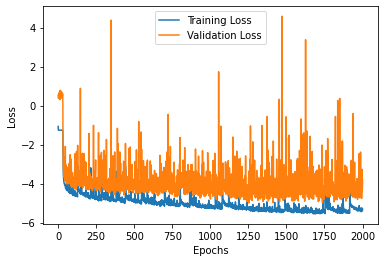

157/157 [==============================] - 6s 37ms/step - loss: -5.0791


157/157 [==============================] - 6s 36ms/step - loss: -5.3411


Epoch 1/2000
118/118 [==============================] - ETA: 0s - loss: -0.8881

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel8/assets


118/118 [==============================] - 33s 252ms/step - loss: -0.8881 - val_loss: 0.3461
Epoch 2/2000
118/118 [==============================] - 22s 183ms/step - loss: -1.2498 - val_loss: 0.4381
Epoch 3/2000
118/118 [==============================] - 22s 185ms/step - loss: -1.2533 - val_loss: 0.5666
Epoch 4/2000
118/118 [==============================] - 22s 187ms/step - loss: -1.2558 - val_loss: 0.6400
Epoch 5/2000
118/118 [==============================] - 22s 183ms/step - loss: -1.2581 - val_loss: 0.4645
Epoch 6/2000
118/118 [==============================] - 22s 185ms/step - loss: -1.2597 - val_loss: 0.4965
Epoch 7/2000
118/118 [==============================] - 22s 185ms/step - loss: -1.2555 - val_loss: 0.3937
Epoch 8/2000
118/118 [==============================] - 22s 184ms/step - loss: -1.2595 - val_loss: 0.4896
Epoch 9/2000
118/118 [==============================] - ETA: 0s - loss: -1.4331

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel8/assets


118/118 [==============================] - 28s 240ms/step - loss: -1.4331 - val_loss: -0.7150
Epoch 10/2000
118/118 [==============================] - ETA: 0s - loss: -2.4162

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel8/assets


118/118 [==============================] - 30s 254ms/step - loss: -2.4162 - val_loss: -2.1447
Epoch 11/2000
118/118 [==============================] - ETA: 0s - loss: -2.6287

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel8/assets


118/118 [==============================] - 28s 240ms/step - loss: -2.6287 - val_loss: -2.5469
Epoch 12/2000
118/118 [==============================] - ETA: 0s - loss: -3.1303

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel8/assets


118/118 [==============================] - 29s 250ms/step - loss: -3.1303 - val_loss: -3.0594
Epoch 13/2000
118/118 [==============================] - 22s 185ms/step - loss: -3.4293 - val_loss: -2.8069
Epoch 14/2000
118/118 [==============================] - ETA: 0s - loss: -3.5753

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel8/assets


118/118 [==============================] - 29s 247ms/step - loss: -3.5753 - val_loss: -3.4220
Epoch 15/2000
118/118 [==============================] - 22s 183ms/step - loss: -3.6599 - val_loss: -3.3913
Epoch 16/2000
118/118 [==============================] - 22s 184ms/step - loss: -3.7994 - val_loss: -2.9948
Epoch 17/2000
118/118 [==============================] - 22s 185ms/step - loss: -3.8860 - val_loss: -3.2149
Epoch 18/2000
118/118 [==============================] - ETA: 0s - loss: -3.8929

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel8/assets


118/118 [==============================] - 28s 239ms/step - loss: -3.8929 - val_loss: -3.5116
Epoch 19/2000
118/118 [==============================] - ETA: 0s - loss: -3.9937

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel8/assets


118/118 [==============================] - 29s 250ms/step - loss: -3.9937 - val_loss: -3.5948
Epoch 20/2000
118/118 [==============================] - ETA: 0s - loss: -3.8923

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel8/assets


118/118 [==============================] - 28s 238ms/step - loss: -3.8923 - val_loss: -3.6457
Epoch 21/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.0406 - val_loss: -3.1571
Epoch 22/2000
118/118 [==============================] - 21s 182ms/step - loss: -4.0391 - val_loss: -3.5917
Epoch 23/2000
118/118 [==============================] - 22s 184ms/step - loss: -3.9851 - val_loss: -3.6388
Epoch 24/2000
118/118 [==============================] - ETA: 0s - loss: -4.1200

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel8/assets


118/118 [==============================] - 29s 249ms/step - loss: -4.1200 - val_loss: -3.7799
Epoch 25/2000
118/118 [==============================] - 21s 181ms/step - loss: -4.1001 - val_loss: -3.1981
Epoch 26/2000
118/118 [==============================] - ETA: 0s - loss: -4.1276

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel8/assets


118/118 [==============================] - 29s 248ms/step - loss: -4.1276 - val_loss: -3.7933
Epoch 27/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.1195 - val_loss: -3.6074
Epoch 28/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.2168 - val_loss: -3.5005
Epoch 29/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.1114 - val_loss: -3.3615
Epoch 30/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.1748 - val_loss: -3.0357
Epoch 31/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.2674 - val_loss: -3.4940
Epoch 32/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.1131 - val_loss: -2.0807
Epoch 33/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.1917 - val_loss: -3.4478
Epoch 34/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.2816 - val_loss: -3.5449
Epoch 35/2000
118/118 [===================

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel8/assets


118/118 [==============================] - 28s 240ms/step - loss: -4.3114 - val_loss: -3.8958
Epoch 40/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.2808 - val_loss: -3.4855
Epoch 41/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.3061 - val_loss: -3.5283
Epoch 42/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.2918 - val_loss: -3.8819
Epoch 43/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.2864 - val_loss: -2.3923
Epoch 44/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.3465 - val_loss: -0.9658
Epoch 45/2000
118/118 [==============================] - ETA: 0s - loss: -4.2420

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel8/assets


118/118 [==============================] - 29s 250ms/step - loss: -4.2420 - val_loss: -3.9116
Epoch 46/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.3764 - val_loss: -3.2622
Epoch 47/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.2437 - val_loss: -3.5628
Epoch 48/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.3029 - val_loss: -3.6085
Epoch 49/2000
118/118 [==============================] - ETA: 0s - loss: -4.4494

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel8/assets


118/118 [==============================] - 29s 247ms/step - loss: -4.4494 - val_loss: -3.9389
Epoch 50/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.3080 - val_loss: -3.8547
Epoch 51/2000
118/118 [==============================] - ETA: 0s - loss: -4.4198

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel8/assets


118/118 [==============================] - 28s 238ms/step - loss: -4.4198 - val_loss: -3.9817
Epoch 52/2000
118/118 [==============================] - ETA: 0s - loss: -4.4332

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel8/assets


118/118 [==============================] - 30s 253ms/step - loss: -4.4332 - val_loss: -4.0477
Epoch 53/2000
118/118 [==============================] - 22s 184ms/step - loss: -3.8108 - val_loss: -3.1786
Epoch 54/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.1759 - val_loss: -3.6689
Epoch 55/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.2918 - val_loss: -3.5975
Epoch 56/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.3493 - val_loss: -3.3225
Epoch 57/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.3313 - val_loss: -3.7820
Epoch 58/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.3428 - val_loss: -3.8596
Epoch 59/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.3243 - val_loss: -3.7609
Epoch 60/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.4063 - val_loss: -3.7268
Epoch 61/2000
118/118 [===================

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel8/assets


118/118 [==============================] - 28s 239ms/step - loss: -4.5859 - val_loss: -4.0543
Epoch 102/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.6311 - val_loss: -3.7263
Epoch 103/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.5800 - val_loss: -3.5708
Epoch 104/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.6675 - val_loss: -3.6370
Epoch 105/2000
118/118 [==============================] - ETA: 0s - loss: -4.6155

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel8/assets


118/118 [==============================] - 29s 249ms/step - loss: -4.6155 - val_loss: -4.1150
Epoch 106/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.6626 - val_loss: -4.0025
Epoch 107/2000
118/118 [==============================] - ETA: 0s - loss: -4.6075

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel8/assets


118/118 [==============================] - 29s 249ms/step - loss: -4.6075 - val_loss: -4.1435
Epoch 108/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.5808 - val_loss: -3.8835
Epoch 109/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.6419 - val_loss: -4.0194
Epoch 110/2000
118/118 [==============================] - ETA: 0s - loss: -4.6144

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel8/assets


118/118 [==============================] - 28s 239ms/step - loss: -4.6144 - val_loss: -4.1930
Epoch 111/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.6844 - val_loss: -3.3931
Epoch 112/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.5411 - val_loss: -2.7004
Epoch 113/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.5591 - val_loss: -3.9374
Epoch 114/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.7396 - val_loss: -4.1007
Epoch 115/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.7411 - val_loss: -2.5581
Epoch 116/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.6329 - val_loss: -3.8282
Epoch 117/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.6845 - val_loss: -3.7638
Epoch 118/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.7235 - val_loss: -4.0156
Epoch 119/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel8/assets


118/118 [==============================] - 30s 251ms/step - loss: -4.6796 - val_loss: -4.2301
Epoch 127/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.2353 - val_loss: -3.8833
Epoch 128/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.6304 - val_loss: -4.0539
Epoch 129/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.5592 - val_loss: -3.4738
Epoch 130/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.7385 - val_loss: -4.1180
Epoch 131/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.6344 - val_loss: -4.1062
Epoch 132/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.6097 - val_loss: -4.0180
Epoch 133/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.7634 - val_loss: -1.6609
Epoch 134/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.6677 - val_loss: -3.8994
Epoch 135/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel8/assets


118/118 [==============================] - 29s 250ms/step - loss: -4.6002 - val_loss: -4.2564
Epoch 198/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.8339 - val_loss: -4.0359
Epoch 199/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.6506 - val_loss: -4.0227
Epoch 200/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.7468 - val_loss: -4.0112
Epoch 201/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.7843 - val_loss: -2.9585
Epoch 202/2000
118/118 [==============================] - ETA: 0s - loss: -4.7608

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel8/assets


118/118 [==============================] - 28s 242ms/step - loss: -4.7608 - val_loss: -4.2625
Epoch 203/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.5682 - val_loss: -4.1866
Epoch 204/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.8767 - val_loss: -3.8866
Epoch 205/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.5984 - val_loss: -4.1856
Epoch 206/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.8170 - val_loss: -3.7598
Epoch 207/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.7619 - val_loss: -4.0945
Epoch 208/2000
118/118 [==============================] - ETA: 0s - loss: -4.7664

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel8/assets


118/118 [==============================] - 30s 254ms/step - loss: -4.7664 - val_loss: -4.2829
Epoch 209/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.8335 - val_loss: -3.0679
Epoch 210/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.7448 - val_loss: -3.9004
Epoch 211/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.5015 - val_loss: -3.7100
Epoch 212/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.7593 - val_loss: -3.7994
Epoch 213/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.7355 - val_loss: -3.2090
Epoch 214/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.7157 - val_loss: -4.0902
Epoch 215/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.8157 - val_loss: -3.4663
Epoch 216/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.8205 - val_loss: -2.7665
Epoch 217/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel8/assets


118/118 [==============================] - 28s 240ms/step - loss: -4.8429 - val_loss: -4.3050
Epoch 223/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.8364 - val_loss: -3.6190
Epoch 224/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.7471 - val_loss: -4.0136
Epoch 225/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.7203 - val_loss: -3.9669
Epoch 226/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.8525 - val_loss: -4.0955
Epoch 227/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.8592 - val_loss: -3.7127
Epoch 228/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.6100 - val_loss: -4.1136
Epoch 229/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.8509 - val_loss: -4.1489
Epoch 230/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.8919 - val_loss: -4.1870
Epoch 231/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel8/assets


118/118 [==============================] - 30s 252ms/step - loss: -4.7781 - val_loss: -4.3465
Epoch 257/2000
118/118 [==============================] - 22s 184ms/step - loss: -3.9559 - val_loss: -2.5735
Epoch 258/2000
118/118 [==============================] - 22s 184ms/step - loss: -3.8365 - val_loss: -3.5802
Epoch 259/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.3932 - val_loss: -3.7014
Epoch 260/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.6023 - val_loss: -3.9940
Epoch 261/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.6345 - val_loss: -3.9985
Epoch 262/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.6738 - val_loss: -3.9799
Epoch 263/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.7527 - val_loss: -3.0250
Epoch 264/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.6277 - val_loss: -3.7154
Epoch 265/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel8/assets


118/118 [==============================] - 29s 248ms/step - loss: -3.8454 - val_loss: -4.4146
Epoch 369/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.3516 - val_loss: -3.7462
Epoch 370/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.5899 - val_loss: -3.1767
Epoch 371/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.7016 - val_loss: -1.2521
Epoch 372/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.7131 - val_loss: -1.8139
Epoch 373/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.7068 - val_loss: -2.1549
Epoch 374/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.5174 - val_loss: -2.0263
Epoch 375/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.7745 - val_loss: -4.0838
Epoch 376/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.8086 - val_loss: -2.0769
Epoch 377/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel8/assets


118/118 [==============================] - 28s 240ms/step - loss: -4.8800 - val_loss: -4.4314
Epoch 503/2000
118/118 [==============================] - ETA: 0s - loss: -4.9467

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel8/assets


118/118 [==============================] - 30s 253ms/step - loss: -4.9467 - val_loss: -4.4387
Epoch 504/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.8832 - val_loss: -4.0773
Epoch 505/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.9393 - val_loss: -3.4040
Epoch 506/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.8554 - val_loss: -3.7200
Epoch 507/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.9827 - val_loss: -3.9310
Epoch 508/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.0469 - val_loss: -4.2368
Epoch 509/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.9162 - val_loss: -3.5352
Epoch 510/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.0020 - val_loss: -4.2045
Epoch 511/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.9415 - val_loss: -4.2723
Epoch 512/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel8/assets


118/118 [==============================] - 28s 239ms/step - loss: -5.1022 - val_loss: -4.4478
Epoch 552/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.6908 - val_loss: -4.2065
Epoch 553/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.9635 - val_loss: -3.7953
Epoch 554/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.9980 - val_loss: -4.1816
Epoch 555/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.0827 - val_loss: -3.8836
Epoch 556/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.4995 - val_loss: -3.7661
Epoch 557/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.9103 - val_loss: -3.9217
Epoch 558/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.9755 - val_loss: -4.2976
Epoch 559/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.0961 - val_loss: -3.9922
Epoch 560/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel8/assets


118/118 [==============================] - 30s 252ms/step - loss: -5.0843 - val_loss: -4.4995
Epoch 655/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.1376 - val_loss: -3.6139
Epoch 656/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.0767 - val_loss: -4.3136
Epoch 657/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.9610 - val_loss: -4.4139
Epoch 658/2000
118/118 [==============================] - 22s 182ms/step - loss: -5.1477 - val_loss: -3.6777
Epoch 659/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.1637 - val_loss: -4.3899
Epoch 660/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.0964 - val_loss: -3.8313
Epoch 661/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.1163 - val_loss: -2.5201
Epoch 662/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.1518 - val_loss: -4.2176
Epoch 663/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel8/assets


118/118 [==============================] - 30s 251ms/step - loss: -5.1770 - val_loss: -4.5091
Epoch 685/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.1876 - val_loss: -4.3279
Epoch 686/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.2220 - val_loss: -3.5912
Epoch 687/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.2491 - val_loss: -3.8341
Epoch 688/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.8147 - val_loss: -1.6072
Epoch 689/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.1528 - val_loss: -3.8556
Epoch 690/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.1981 - val_loss: -2.8073
Epoch 691/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.1933 - val_loss: -3.5954
Epoch 692/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.2074 - val_loss: -4.1912
Epoch 693/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel8/assets


118/118 [==============================] - 28s 240ms/step - loss: -5.1562 - val_loss: -4.5227
Epoch 709/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.2105 - val_loss: -1.7894
Epoch 710/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.2197 - val_loss: -4.3488
Epoch 711/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.1823 - val_loss: -4.1699
Epoch 712/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.2373 - val_loss: -2.1556
Epoch 713/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.0860 - val_loss: -3.8758
Epoch 714/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.2594 - val_loss: -4.3556
Epoch 715/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.0545 - val_loss: -4.1168
Epoch 716/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.2769 - val_loss: -4.3730
Epoch 717/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel8/assets


118/118 [==============================] - 30s 256ms/step - loss: -5.0926 - val_loss: -4.6828
Epoch 729/2000
118/118 [==============================] - 21s 182ms/step - loss: -5.0840 - val_loss: -3.3433
Epoch 730/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.1704 - val_loss: -3.9291
Epoch 731/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.1644 - val_loss: -4.1835
Epoch 732/2000
118/118 [==============================] - 21s 182ms/step - loss: -5.1686 - val_loss: -4.2428
Epoch 733/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.2098 - val_loss: -3.8779
Epoch 734/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.1864 - val_loss: -3.5653
Epoch 735/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.2021 - val_loss: -3.8332
Epoch 736/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.2347 - val_loss: -3.8864
Epoch 737/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel8/assets


118/118 [==============================] - 28s 240ms/step - loss: -5.0895 - val_loss: -4.6892
Epoch 798/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.2390 - val_loss: -4.4548
Epoch 799/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.9553 - val_loss: -3.9211
Epoch 800/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.1381 - val_loss: -3.9440
Epoch 801/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.1616 - val_loss: -4.3724
Epoch 802/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.1592 - val_loss: -3.8160
Epoch 803/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.2915 - val_loss: -4.3925
Epoch 804/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.2831 - val_loss: -3.4887
Epoch 805/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.2434 - val_loss: -2.7689
Epoch 806/2000
118/118 [==========

118/118 [==============================] - 22s 185ms/step - loss: -4.9939 - val_loss: -3.8863
Epoch 948/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.9926 - val_loss: -3.9830
Epoch 949/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.0672 - val_loss: -3.7658
Epoch 950/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.1169 - val_loss: -2.8086
Epoch 951/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.1052 - val_loss: -4.0261
Epoch 952/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.0772 - val_loss: -3.3511
Epoch 953/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.0826 - val_loss: -3.6197
Epoch 954/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.0508 - val_loss: -3.9122
Epoch 955/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.1463 - val_loss: -3.7373
Epoch 956/2000
118/118 [==========

118/118 [==============================] - 22s 183ms/step - loss: -5.1863 - val_loss: -3.9928
Epoch 1023/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.6697 - val_loss: -3.2033
Epoch 1024/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.9150 - val_loss: -4.1865
Epoch 1025/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.1706 - val_loss: -3.8800
Epoch 1026/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.0817 - val_loss: -4.3214
Epoch 1027/2000
118/118 [==============================] - 21s 182ms/step - loss: -5.1184 - val_loss: -3.9550
Epoch 1028/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.1846 - val_loss: -3.2106
Epoch 1029/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.2355 - val_loss: -4.3395
Epoch 1030/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.1253 - val_loss: -4.1325
Epoch 1031/2000
118/118 [=

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel8/assets


118/118 [==============================] - 30s 254ms/step - loss: -5.2124 - val_loss: -4.7069
Epoch 1105/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.1642 - val_loss: -2.8769
Epoch 1106/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.2857 - val_loss: -4.2427
Epoch 1107/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.2477 - val_loss: -3.1605
Epoch 1108/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.2526 - val_loss: -4.3641
Epoch 1109/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.0909 - val_loss: -3.9097
Epoch 1110/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.2315 - val_loss: -3.1771
Epoch 1111/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.1964 - val_loss: -4.0554
Epoch 1112/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.2060 - val_loss: -4.0355
Epoch 1113/2000
118/118 [=

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel8/assets


118/118 [==============================] - 29s 250ms/step - loss: -5.2573 - val_loss: -4.7560
Epoch 1131/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.9321 - val_loss: -3.9578
Epoch 1132/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.1535 - val_loss: -4.3475
Epoch 1133/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.1874 - val_loss: -4.5599
Epoch 1134/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.2499 - val_loss: -4.4332
Epoch 1135/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.2136 - val_loss: -4.4465
Epoch 1136/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.3099 - val_loss: -1.4903
Epoch 1137/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.2335 - val_loss: -3.9490
Epoch 1138/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.2330 - val_loss: -4.0917
Epoch 1139/2000
118/118 [=

118/118 [==============================] - 22s 183ms/step - loss: -5.2199 - val_loss: -4.1274
Epoch 1279/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.1938 - val_loss: -4.0834
Epoch 1280/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.2843 - val_loss: -4.2431
Epoch 1281/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.2418 - val_loss: -4.0199
Epoch 1282/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.0277 - val_loss: -4.4792
Epoch 1283/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.3466 - val_loss: -4.1800
Epoch 1284/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.1032 - val_loss: -3.7328
Epoch 1285/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.1876 - val_loss: -4.4134
Epoch 1286/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.2948 - val_loss: -3.7378
Epoch 1287/2000
118/118 [=

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel8/assets


118/118 [==============================] - 28s 240ms/step - loss: -5.3424 - val_loss: -4.8014
Epoch 1383/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.3307 - val_loss: -4.4504
Epoch 1384/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.3808 - val_loss: -4.0312
Epoch 1385/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.2161 - val_loss: -4.1530
Epoch 1386/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.3372 - val_loss: -2.1303
Epoch 1387/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.3849 - val_loss: -2.4226
Epoch 1388/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.3226 - val_loss: -4.5958
Epoch 1389/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.3877 - val_loss: -3.5269
Epoch 1390/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.4169 - val_loss: -4.2535
Epoch 1391/2000
118/118 [=

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel8/assets


118/118 [==============================] - 30s 255ms/step - loss: -5.4053 - val_loss: -4.8369
Epoch 1413/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.3269 - val_loss: -4.4678
Epoch 1414/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.3511 - val_loss: -3.9022
Epoch 1415/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.4062 - val_loss: -3.9772
Epoch 1416/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.2788 - val_loss: -4.4635
Epoch 1417/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.3597 - val_loss: -3.8295
Epoch 1418/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.3138 - val_loss: -4.3735
Epoch 1419/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.3100 - val_loss: -4.1426
Epoch 1420/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.3829 - val_loss: -4.5540
Epoch 1421/2000
118/118 [=

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel8/assets


118/118 [==============================] - 28s 240ms/step - loss: -5.3968 - val_loss: -4.8581
Epoch 1456/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.3633 - val_loss: -3.8779
Epoch 1457/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.3893 - val_loss: -4.3859
Epoch 1458/2000
118/118 [==============================] - 22s 185ms/step - loss: -3.2653 - val_loss: -2.0191
Epoch 1459/2000
118/118 [==============================] - 22s 185ms/step - loss: -3.2073 - val_loss: -3.4887
Epoch 1460/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.0674 - val_loss: -3.9540
Epoch 1461/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.3227 - val_loss: -4.0924
Epoch 1462/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.5129 - val_loss: -3.9946
Epoch 1463/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.5951 - val_loss: -3.5122
Epoch 1464/2000
118/118 [=

118/118 [==============================] - 22s 185ms/step - loss: -5.1120 - val_loss: -1.4440
Epoch 1604/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.0744 - val_loss: -3.7662
Epoch 1605/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.2032 - val_loss: -3.1054
Epoch 1606/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.3464 - val_loss: -3.8051
Epoch 1607/2000
118/118 [==============================] - 22s 187ms/step - loss: -5.2612 - val_loss: -4.6460
Epoch 1608/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.2044 - val_loss: -4.2605
Epoch 1609/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.1928 - val_loss: -3.6581
Epoch 1610/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.3356 - val_loss: -4.4456
Epoch 1611/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.3091 - val_loss: -3.8094
Epoch 1612/2000
118/118 [=

118/118 [==============================] - 22s 185ms/step - loss: -5.4306 - val_loss: -4.5961
Epoch 1752/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.1026 - val_loss: -4.6549
Epoch 1753/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.4336 - val_loss: -3.6744
Epoch 1754/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.2405 - val_loss: -3.4633
Epoch 1755/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.3817 - val_loss: -3.7694
Epoch 1756/2000
118/118 [==============================] - 21s 181ms/step - loss: -5.4350 - val_loss: -3.8440
Epoch 1757/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.4138 - val_loss: -3.8468
Epoch 1758/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.5037 - val_loss: -4.4062
Epoch 1759/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.1178 - val_loss: -3.8231
Epoch 1760/2000
118/118 [=

118/118 [==============================] - 22s 185ms/step - loss: -5.4896 - val_loss: -1.3450
Epoch 1900/2000
118/118 [==============================] - 22s 182ms/step - loss: -5.3508 - val_loss: -4.4217
Epoch 1901/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.3634 - val_loss: -3.7736
Epoch 1902/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.2910 - val_loss: -3.2324
Epoch 1903/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.3228 - val_loss: -4.4515
Epoch 1904/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.4276 - val_loss: -4.3337
Epoch 1905/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.3955 - val_loss: -3.9076
Epoch 1906/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.5039 - val_loss: -4.7023
Epoch 1907/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.4402 - val_loss: -3.9193
Epoch 1908/2000
118/118 [=

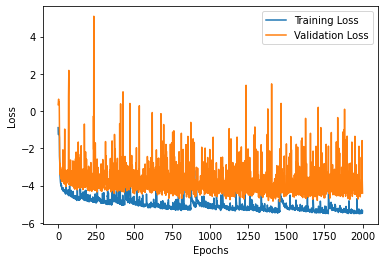

157/157 [==============================] - 6s 36ms/step - loss: -5.0330


157/157 [==============================] - 6s 36ms/step - loss: -5.0714


Epoch 1/2000
118/118 [==============================] - ETA: 0s - loss: 177293.7656

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 33s 258ms/step - loss: 177293.7656 - val_loss: 0.6907
Epoch 2/2000
118/118 [==============================] - ETA: 0s - loss: 0.6598

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 29s 249ms/step - loss: 0.6598 - val_loss: 0.6904
Epoch 3/2000
118/118 [==============================] - ETA: 0s - loss: 0.6561

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 28s 240ms/step - loss: 0.6561 - val_loss: 0.6891
Epoch 4/2000
118/118 [==============================] - 22s 184ms/step - loss: 0.6469 - val_loss: 0.6894
Epoch 5/2000
118/118 [==============================] - ETA: 0s - loss: 0.6503

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 30s 254ms/step - loss: 0.6503 - val_loss: 0.6836
Epoch 6/2000
118/118 [==============================] - ETA: 0s - loss: 0.6018

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 28s 240ms/step - loss: 0.6018 - val_loss: 0.6809
Epoch 7/2000
118/118 [==============================] - 21s 182ms/step - loss: 0.6369 - val_loss: 0.6913
Epoch 8/2000
118/118 [==============================] - 22s 184ms/step - loss: 0.6578 - val_loss: 0.6854
Epoch 9/2000
118/118 [==============================] - 22s 184ms/step - loss: 0.6347 - val_loss: 0.6858
Epoch 10/2000
118/118 [==============================] - 22s 184ms/step - loss: 0.6320 - val_loss: 0.6854
Epoch 11/2000
118/118 [==============================] - ETA: 0s - loss: 0.6130

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 30s 252ms/step - loss: 0.6130 - val_loss: 0.6803
Epoch 12/2000
118/118 [==============================] - ETA: 0s - loss: 0.5982

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 28s 240ms/step - loss: 0.5982 - val_loss: 0.6801
Epoch 13/2000
118/118 [==============================] - ETA: 0s - loss: 0.5938

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 30s 251ms/step - loss: 0.5938 - val_loss: 0.6778
Epoch 14/2000
118/118 [==============================] - 22s 185ms/step - loss: 0.5908 - val_loss: 0.6800
Epoch 15/2000
118/118 [==============================] - 21s 181ms/step - loss: 0.6322 - val_loss: 0.6962
Epoch 16/2000
118/118 [==============================] - 22s 183ms/step - loss: 0.7978 - val_loss: 0.7077
Epoch 17/2000
118/118 [==============================] - 22s 184ms/step - loss: 0.8008 - val_loss: 0.7028
Epoch 18/2000
118/118 [==============================] - 22s 186ms/step - loss: 0.8048 - val_loss: 0.7046
Epoch 19/2000
118/118 [==============================] - 22s 185ms/step - loss: 0.8000 - val_loss: 0.7047
Epoch 20/2000
118/118 [==============================] - 22s 183ms/step - loss: 0.8038 - val_loss: 0.7030
Epoch 21/2000
118/118 [==============================] - 21s 182ms/step - loss: 0.8057 - val_loss: 0.7030
Epoch 22/2000
118/118 [==============================] - 22s

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 29s 250ms/step - loss: 0.7073 - val_loss: 0.4768
Epoch 35/2000
118/118 [==============================] - ETA: 0s - loss: 0.2193

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 28s 240ms/step - loss: 0.2193 - val_loss: 0.3625
Epoch 36/2000
118/118 [==============================] - ETA: 0s - loss: 0.2081

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 30s 256ms/step - loss: 0.2081 - val_loss: 0.3508
Epoch 37/2000
118/118 [==============================] - ETA: 0s - loss: 0.2044

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 28s 238ms/step - loss: 0.2044 - val_loss: 0.3380
Epoch 38/2000
118/118 [==============================] - ETA: 0s - loss: 0.1991

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 30s 252ms/step - loss: 0.1991 - val_loss: 0.3189
Epoch 39/2000
118/118 [==============================] - ETA: 0s - loss: 0.1934

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 28s 239ms/step - loss: 0.1934 - val_loss: 0.2963
Epoch 40/2000
118/118 [==============================] - ETA: 0s - loss: 0.1859

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 29s 251ms/step - loss: 0.1859 - val_loss: 0.2598
Epoch 41/2000
118/118 [==============================] - ETA: 0s - loss: 0.1783

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 29s 250ms/step - loss: 0.1783 - val_loss: 0.2136
Epoch 42/2000
118/118 [==============================] - ETA: 0s - loss: 0.1722

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 28s 240ms/step - loss: 0.1722 - val_loss: 0.1723
Epoch 43/2000
118/118 [==============================] - ETA: 0s - loss: 0.1684

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 30s 253ms/step - loss: 0.1684 - val_loss: 0.1449
Epoch 44/2000
118/118 [==============================] - ETA: 0s - loss: 0.1657

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 28s 238ms/step - loss: 0.1657 - val_loss: 0.1264
Epoch 45/2000
118/118 [==============================] - ETA: 0s - loss: 0.1638

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 30s 252ms/step - loss: 0.1638 - val_loss: 0.1143
Epoch 46/2000
118/118 [==============================] - ETA: 0s - loss: 0.1622

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 28s 240ms/step - loss: 0.1622 - val_loss: 0.1062
Epoch 47/2000
118/118 [==============================] - ETA: 0s - loss: 0.1609

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 30s 251ms/step - loss: 0.1609 - val_loss: 0.0997
Epoch 48/2000
118/118 [==============================] - ETA: 0s - loss: 0.1598

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 29s 250ms/step - loss: 0.1598 - val_loss: 0.0946
Epoch 49/2000
118/118 [==============================] - ETA: 0s - loss: 0.1588

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 28s 239ms/step - loss: 0.1588 - val_loss: 0.0898
Epoch 50/2000
118/118 [==============================] - ETA: 0s - loss: 0.1578

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 30s 254ms/step - loss: 0.1578 - val_loss: 0.0856
Epoch 51/2000
118/118 [==============================] - ETA: 0s - loss: 0.1568

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 28s 237ms/step - loss: 0.1568 - val_loss: 0.0818
Epoch 52/2000
118/118 [==============================] - ETA: 0s - loss: 0.1560

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 30s 253ms/step - loss: 0.1560 - val_loss: 0.0782
Epoch 53/2000
118/118 [==============================] - ETA: 0s - loss: 0.1551

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 28s 239ms/step - loss: 0.1551 - val_loss: 0.0748
Epoch 54/2000
118/118 [==============================] - ETA: 0s - loss: 0.1542

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 30s 251ms/step - loss: 0.1542 - val_loss: 0.0714
Epoch 55/2000
118/118 [==============================] - ETA: 0s - loss: 0.1532

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 28s 240ms/step - loss: 0.1532 - val_loss: 0.0682
Epoch 56/2000
118/118 [==============================] - ETA: 0s - loss: 0.1524

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 29s 250ms/step - loss: 0.1524 - val_loss: 0.0652
Epoch 57/2000
118/118 [==============================] - ETA: 0s - loss: 0.1514

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 29s 247ms/step - loss: 0.1514 - val_loss: 0.0621
Epoch 58/2000
118/118 [==============================] - ETA: 0s - loss: 0.1505

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 28s 240ms/step - loss: 0.1505 - val_loss: 0.0590
Epoch 59/2000
118/118 [==============================] - ETA: 0s - loss: 0.1496

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 30s 253ms/step - loss: 0.1496 - val_loss: 0.0559
Epoch 60/2000
118/118 [==============================] - ETA: 0s - loss: 0.1487

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 28s 239ms/step - loss: 0.1487 - val_loss: 0.0530
Epoch 61/2000
118/118 [==============================] - ETA: 0s - loss: 0.1477

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 29s 250ms/step - loss: 0.1477 - val_loss: 0.0502
Epoch 62/2000
118/118 [==============================] - ETA: 0s - loss: 0.1468

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 29s 248ms/step - loss: 0.1468 - val_loss: 0.0473
Epoch 63/2000
118/118 [==============================] - ETA: 0s - loss: 0.1459

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 28s 238ms/step - loss: 0.1459 - val_loss: 0.0444
Epoch 64/2000
118/118 [==============================] - ETA: 0s - loss: 0.1449

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 30s 251ms/step - loss: 0.1449 - val_loss: 0.0414
Epoch 65/2000
118/118 [==============================] - ETA: 0s - loss: 0.1439

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 28s 240ms/step - loss: 0.1439 - val_loss: 0.0385
Epoch 66/2000
118/118 [==============================] - ETA: 0s - loss: 0.1429

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 29s 249ms/step - loss: 0.1429 - val_loss: 0.0356
Epoch 67/2000
118/118 [==============================] - ETA: 0s - loss: 0.1419

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 28s 240ms/step - loss: 0.1419 - val_loss: 0.0326
Epoch 68/2000
118/118 [==============================] - ETA: 0s - loss: 0.1408

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 30s 253ms/step - loss: 0.1408 - val_loss: 0.0296
Epoch 69/2000
118/118 [==============================] - ETA: 0s - loss: 0.1397

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 29s 249ms/step - loss: 0.1397 - val_loss: 0.0266
Epoch 70/2000
118/118 [==============================] - ETA: 0s - loss: 0.1386

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 28s 240ms/step - loss: 0.1386 - val_loss: 0.0235
Epoch 71/2000
118/118 [==============================] - ETA: 0s - loss: 0.1375

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 30s 254ms/step - loss: 0.1375 - val_loss: 0.0205
Epoch 72/2000
118/118 [==============================] - ETA: 0s - loss: 0.1363

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 28s 238ms/step - loss: 0.1363 - val_loss: 0.0173
Epoch 73/2000
118/118 [==============================] - ETA: 0s - loss: 0.1352

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 29s 250ms/step - loss: 0.1352 - val_loss: 0.0142
Epoch 74/2000
118/118 [==============================] - ETA: 0s - loss: 0.1340

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 29s 250ms/step - loss: 0.1340 - val_loss: 0.0109
Epoch 75/2000
118/118 [==============================] - ETA: 0s - loss: 0.1327

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 28s 239ms/step - loss: 0.1327 - val_loss: 0.0076
Epoch 76/2000
118/118 [==============================] - ETA: 0s - loss: 0.1314

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 30s 253ms/step - loss: 0.1314 - val_loss: 0.0042
Epoch 77/2000
118/118 [==============================] - ETA: 0s - loss: 0.1301

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 28s 239ms/step - loss: 0.1301 - val_loss: 7.2501e-04
Epoch 78/2000
118/118 [==============================] - ETA: 0s - loss: 0.1288

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 30s 252ms/step - loss: 0.1288 - val_loss: -0.0028
Epoch 79/2000
118/118 [==============================] - ETA: 0s - loss: 0.1273

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 28s 239ms/step - loss: 0.1273 - val_loss: -0.0065
Epoch 80/2000
118/118 [==============================] - ETA: 0s - loss: 0.1259

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 30s 251ms/step - loss: 0.1259 - val_loss: -0.0103
Epoch 81/2000
118/118 [==============================] - ETA: 0s - loss: 0.1244

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 29s 248ms/step - loss: 0.1244 - val_loss: -0.0141
Epoch 82/2000
118/118 [==============================] - ETA: 0s - loss: 0.1228

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 28s 240ms/step - loss: 0.1228 - val_loss: -0.0182
Epoch 83/2000
118/118 [==============================] - ETA: 0s - loss: 0.1212

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 30s 252ms/step - loss: 0.1212 - val_loss: -0.0221
Epoch 84/2000
118/118 [==============================] - ETA: 0s - loss: 0.1196

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 28s 238ms/step - loss: 0.1196 - val_loss: -0.0264
Epoch 85/2000
118/118 [==============================] - ETA: 0s - loss: 0.1178

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 30s 253ms/step - loss: 0.1178 - val_loss: -0.0308
Epoch 86/2000
118/118 [==============================] - ETA: 0s - loss: 0.1161

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 28s 239ms/step - loss: 0.1161 - val_loss: -0.0352
Epoch 87/2000
118/118 [==============================] - ETA: 0s - loss: 0.1142

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 29s 249ms/step - loss: 0.1142 - val_loss: -0.0399
Epoch 88/2000
118/118 [==============================] - ETA: 0s - loss: 0.1122

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 28s 238ms/step - loss: 0.1122 - val_loss: -0.0447
Epoch 89/2000
118/118 [==============================] - ETA: 0s - loss: 0.1102

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 30s 251ms/step - loss: 0.1102 - val_loss: -0.0498
Epoch 90/2000
118/118 [==============================] - ETA: 0s - loss: 0.1081

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 29s 248ms/step - loss: 0.1081 - val_loss: -0.0551
Epoch 91/2000
118/118 [==============================] - ETA: 0s - loss: 0.1059

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 28s 239ms/step - loss: 0.1059 - val_loss: -0.0606
Epoch 92/2000
118/118 [==============================] - ETA: 0s - loss: 0.1035

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 30s 253ms/step - loss: 0.1035 - val_loss: -0.0664
Epoch 93/2000
118/118 [==============================] - ETA: 0s - loss: 0.1011

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 28s 240ms/step - loss: 0.1011 - val_loss: -0.0725
Epoch 94/2000
118/118 [==============================] - ETA: 0s - loss: 0.0985

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 30s 251ms/step - loss: 0.0985 - val_loss: -0.0790
Epoch 95/2000
118/118 [==============================] - ETA: 0s - loss: 0.0957

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 29s 249ms/step - loss: 0.0957 - val_loss: -0.0861
Epoch 96/2000
118/118 [==============================] - ETA: 0s - loss: 0.0927

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 28s 237ms/step - loss: 0.0927 - val_loss: -0.0937
Epoch 97/2000
118/118 [==============================] - ETA: 0s - loss: 0.0895

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 30s 252ms/step - loss: 0.0895 - val_loss: -0.1021
Epoch 98/2000
118/118 [==============================] - ETA: 0s - loss: 0.0859

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 28s 238ms/step - loss: 0.0859 - val_loss: -0.1114
Epoch 99/2000
118/118 [==============================] - ETA: 0s - loss: 0.0820

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 29s 250ms/step - loss: 0.0820 - val_loss: -0.1221
Epoch 100/2000
118/118 [==============================] - ETA: 0s - loss: 0.0775

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 30s 251ms/step - loss: 0.0775 - val_loss: -0.1349
Epoch 101/2000
118/118 [==============================] - ETA: 0s - loss: 0.0722

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 28s 240ms/step - loss: 0.0722 - val_loss: -0.1511
Epoch 102/2000
118/118 [==============================] - ETA: 0s - loss: 0.0656

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 30s 255ms/step - loss: 0.0656 - val_loss: -0.1747
Epoch 103/2000
118/118 [==============================] - ETA: 0s - loss: 0.0557

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 28s 239ms/step - loss: 0.0557 - val_loss: -0.2202
Epoch 104/2000
118/118 [==============================] - ETA: 0s - loss: 0.0330

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 29s 250ms/step - loss: 0.0330 - val_loss: -0.3204
Epoch 105/2000
118/118 [==============================] - ETA: 0s - loss: -0.0287

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 28s 239ms/step - loss: -0.0287 - val_loss: -0.3890
Epoch 106/2000
118/118 [==============================] - ETA: 0s - loss: -0.1450

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 30s 253ms/step - loss: -0.1450 - val_loss: -0.4587
Epoch 107/2000
118/118 [==============================] - ETA: 0s - loss: -0.2785

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 28s 240ms/step - loss: -0.2785 - val_loss: -0.4906
Epoch 108/2000
118/118 [==============================] - ETA: 0s - loss: -0.3416

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 30s 252ms/step - loss: -0.3416 - val_loss: -0.4968
Epoch 109/2000
118/118 [==============================] - ETA: 0s - loss: -0.3915

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 29s 249ms/step - loss: -0.3915 - val_loss: -0.5057
Epoch 110/2000
118/118 [==============================] - ETA: 0s - loss: -0.4291

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 28s 240ms/step - loss: -0.4291 - val_loss: -0.5268
Epoch 111/2000
118/118 [==============================] - ETA: 0s - loss: -0.4603

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 30s 253ms/step - loss: -0.4603 - val_loss: -0.5408
Epoch 112/2000
118/118 [==============================] - ETA: 0s - loss: -0.4848

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 28s 238ms/step - loss: -0.4848 - val_loss: -0.5492
Epoch 113/2000
118/118 [==============================] - ETA: 0s - loss: -0.5043

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 30s 252ms/step - loss: -0.5043 - val_loss: -0.5560
Epoch 114/2000
118/118 [==============================] - ETA: 0s - loss: -0.5207

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 29s 250ms/step - loss: -0.5207 - val_loss: -0.5618
Epoch 115/2000
118/118 [==============================] - ETA: 0s - loss: -0.5348

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 28s 239ms/step - loss: -0.5348 - val_loss: -0.5664
Epoch 116/2000
118/118 [==============================] - ETA: 0s - loss: -0.5470

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 30s 254ms/step - loss: -0.5470 - val_loss: -0.5705
Epoch 117/2000
118/118 [==============================] - ETA: 0s - loss: -0.5578

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 28s 237ms/step - loss: -0.5578 - val_loss: -0.5743
Epoch 118/2000
118/118 [==============================] - ETA: 0s - loss: -0.5675

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 30s 252ms/step - loss: -0.5675 - val_loss: -0.5777
Epoch 119/2000
118/118 [==============================] - ETA: 0s - loss: -0.5764

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 28s 238ms/step - loss: -0.5764 - val_loss: -0.5815
Epoch 120/2000
118/118 [==============================] - ETA: 0s - loss: -0.5847

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 30s 252ms/step - loss: -0.5847 - val_loss: -0.5863
Epoch 121/2000
118/118 [==============================] - ETA: 0s - loss: -0.5927

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 29s 249ms/step - loss: -0.5927 - val_loss: -0.5933
Epoch 122/2000
118/118 [==============================] - ETA: 0s - loss: -0.6005

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 28s 240ms/step - loss: -0.6005 - val_loss: -0.6015
Epoch 123/2000
118/118 [==============================] - ETA: 0s - loss: -0.6082

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 30s 254ms/step - loss: -0.6082 - val_loss: -0.6101
Epoch 124/2000
118/118 [==============================] - ETA: 0s - loss: -0.6158

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 28s 240ms/step - loss: -0.6158 - val_loss: -0.6195
Epoch 125/2000
118/118 [==============================] - ETA: 0s - loss: -0.6234

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 30s 254ms/step - loss: -0.6234 - val_loss: -0.6287
Epoch 126/2000
118/118 [==============================] - ETA: 0s - loss: -0.6308

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 28s 238ms/step - loss: -0.6308 - val_loss: -0.6383
Epoch 127/2000
118/118 [==============================] - ETA: 0s - loss: -0.6382

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 30s 252ms/step - loss: -0.6382 - val_loss: -0.6474
Epoch 128/2000
118/118 [==============================] - ETA: 0s - loss: -0.6453

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 28s 240ms/step - loss: -0.6453 - val_loss: -0.6563
Epoch 129/2000
118/118 [==============================] - ETA: 0s - loss: -0.6522

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 30s 252ms/step - loss: -0.6522 - val_loss: -0.6651
Epoch 130/2000
118/118 [==============================] - ETA: 0s - loss: -0.6590

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 29s 248ms/step - loss: -0.6590 - val_loss: -0.6750
Epoch 131/2000
118/118 [==============================] - ETA: 0s - loss: -0.6661

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 28s 239ms/step - loss: -0.6661 - val_loss: -0.6845
Epoch 132/2000
118/118 [==============================] - ETA: 0s - loss: -0.6730

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 30s 255ms/step - loss: -0.6730 - val_loss: -0.6953
Epoch 133/2000
118/118 [==============================] - ETA: 0s - loss: -0.6801

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 28s 237ms/step - loss: -0.6801 - val_loss: -0.7060
Epoch 134/2000
118/118 [==============================] - ETA: 0s - loss: -0.6877

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 30s 252ms/step - loss: -0.6877 - val_loss: -0.7184
Epoch 135/2000
118/118 [==============================] - ETA: 0s - loss: -0.6967

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 29s 249ms/step - loss: -0.6967 - val_loss: -0.7328
Epoch 136/2000
118/118 [==============================] - ETA: 0s - loss: -0.7066

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 28s 240ms/step - loss: -0.7066 - val_loss: -0.7430
Epoch 137/2000
118/118 [==============================] - 22s 184ms/step - loss: -0.7164 - val_loss: -0.7421
Epoch 138/2000
118/118 [==============================] - ETA: 0s - loss: -0.7376

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 30s 254ms/step - loss: -0.7376 - val_loss: -0.7984
Epoch 139/2000
118/118 [==============================] - ETA: 0s - loss: -0.7657

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 28s 239ms/step - loss: -0.7657 - val_loss: -0.8490
Epoch 140/2000
118/118 [==============================] - ETA: 0s - loss: -0.7804

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 30s 252ms/step - loss: -0.7804 - val_loss: -0.8826
Epoch 141/2000
118/118 [==============================] - ETA: 0s - loss: -0.7946

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 30s 251ms/step - loss: -0.7946 - val_loss: -0.9081
Epoch 142/2000
118/118 [==============================] - ETA: 0s - loss: -0.8052

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 28s 239ms/step - loss: -0.8052 - val_loss: -0.9279
Epoch 143/2000
118/118 [==============================] - ETA: 0s - loss: -0.8144

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 30s 253ms/step - loss: -0.8144 - val_loss: -0.9436
Epoch 144/2000
118/118 [==============================] - ETA: 0s - loss: -0.8226

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 28s 239ms/step - loss: -0.8226 - val_loss: -0.9551
Epoch 145/2000
118/118 [==============================] - ETA: 0s - loss: -0.8304

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 30s 251ms/step - loss: -0.8304 - val_loss: -0.9670
Epoch 146/2000
118/118 [==============================] - ETA: 0s - loss: -0.8378

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 28s 239ms/step - loss: -0.8378 - val_loss: -0.9774
Epoch 147/2000
118/118 [==============================] - ETA: 0s - loss: -0.8448

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 30s 252ms/step - loss: -0.8448 - val_loss: -0.9868
Epoch 148/2000
118/118 [==============================] - ETA: 0s - loss: -0.8516

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 28s 239ms/step - loss: -0.8516 - val_loss: -0.9946
Epoch 149/2000
118/118 [==============================] - ETA: 0s - loss: -0.8579

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 30s 252ms/step - loss: -0.8579 - val_loss: -1.0032
Epoch 150/2000
118/118 [==============================] - ETA: 0s - loss: -0.8651

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 29s 250ms/step - loss: -0.8651 - val_loss: -1.0132
Epoch 151/2000
118/118 [==============================] - ETA: 0s - loss: -0.8721

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 28s 240ms/step - loss: -0.8721 - val_loss: -1.0318
Epoch 152/2000
118/118 [==============================] - ETA: 0s - loss: -0.8804

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 30s 255ms/step - loss: -0.8804 - val_loss: -1.0690
Epoch 153/2000
118/118 [==============================] - ETA: 0s - loss: -0.8903

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 28s 239ms/step - loss: -0.8903 - val_loss: -1.1158
Epoch 154/2000
118/118 [==============================] - ETA: 0s - loss: -0.8992

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 30s 254ms/step - loss: -0.8992 - val_loss: -1.1345
Epoch 155/2000
118/118 [==============================] - ETA: 0s - loss: -0.9076

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 29s 250ms/step - loss: -0.9076 - val_loss: -1.1438
Epoch 156/2000
118/118 [==============================] - ETA: 0s - loss: -0.9155

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 28s 240ms/step - loss: -0.9155 - val_loss: -1.1489
Epoch 157/2000
118/118 [==============================] - ETA: 0s - loss: -0.9246

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 30s 253ms/step - loss: -0.9246 - val_loss: -1.1593
Epoch 158/2000
118/118 [==============================] - ETA: 0s - loss: -0.9331

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 28s 241ms/step - loss: -0.9331 - val_loss: -1.1671
Epoch 159/2000
118/118 [==============================] - ETA: 0s - loss: -0.9428

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 30s 253ms/step - loss: -0.9428 - val_loss: -1.1710
Epoch 160/2000
118/118 [==============================] - ETA: 0s - loss: -0.9524

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 28s 239ms/step - loss: -0.9524 - val_loss: -1.1809
Epoch 161/2000
118/118 [==============================] - ETA: 0s - loss: -0.9629

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 30s 252ms/step - loss: -0.9629 - val_loss: -1.1973
Epoch 162/2000
118/118 [==============================] - ETA: 0s - loss: -0.9743

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 29s 249ms/step - loss: -0.9743 - val_loss: -1.2025
Epoch 163/2000
118/118 [==============================] - 22s 184ms/step - loss: -0.9849 - val_loss: -1.0874
Epoch 164/2000
118/118 [==============================] - ETA: 0s - loss: -0.9951

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 28s 238ms/step - loss: -0.9951 - val_loss: -1.2286
Epoch 165/2000
118/118 [==============================] - ETA: 0s - loss: -1.0109

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 30s 255ms/step - loss: -1.0109 - val_loss: -1.2378
Epoch 166/2000
118/118 [==============================] - ETA: 0s - loss: -1.0248

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 28s 238ms/step - loss: -1.0248 - val_loss: -1.2552
Epoch 167/2000
118/118 [==============================] - ETA: 0s - loss: -1.0396

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 30s 252ms/step - loss: -1.0396 - val_loss: -1.2693
Epoch 168/2000
118/118 [==============================] - ETA: 0s - loss: -1.0552

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 29s 249ms/step - loss: -1.0552 - val_loss: -1.2788
Epoch 169/2000
118/118 [==============================] - ETA: 0s - loss: -1.0716

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 28s 239ms/step - loss: -1.0716 - val_loss: -1.3038
Epoch 170/2000
118/118 [==============================] - ETA: 0s - loss: -1.0892

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 30s 255ms/step - loss: -1.0892 - val_loss: -1.3164
Epoch 171/2000
118/118 [==============================] - ETA: 0s - loss: -1.1080

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 28s 241ms/step - loss: -1.1080 - val_loss: -1.3407
Epoch 172/2000
118/118 [==============================] - ETA: 0s - loss: -1.1280

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 30s 252ms/step - loss: -1.1280 - val_loss: -1.3608
Epoch 173/2000
118/118 [==============================] - ETA: 0s - loss: -1.1495

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 28s 240ms/step - loss: -1.1495 - val_loss: -1.3780
Epoch 174/2000
118/118 [==============================] - ETA: 0s - loss: -1.1722

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 30s 252ms/step - loss: -1.1722 - val_loss: -1.3986
Epoch 175/2000
118/118 [==============================] - ETA: 0s - loss: -1.1965

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 28s 239ms/step - loss: -1.1965 - val_loss: -1.4145
Epoch 176/2000
118/118 [==============================] - ETA: 0s - loss: -1.2226

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 30s 252ms/step - loss: -1.2226 - val_loss: -1.4385
Epoch 177/2000
118/118 [==============================] - ETA: 0s - loss: -1.2510

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 29s 250ms/step - loss: -1.2510 - val_loss: -1.4644
Epoch 178/2000
118/118 [==============================] - ETA: 0s - loss: -1.2840

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 28s 238ms/step - loss: -1.2840 - val_loss: -1.4828
Epoch 179/2000
118/118 [==============================] - 22s 184ms/step - loss: -1.2824 - val_loss: -0.3120
Epoch 180/2000
118/118 [==============================] - 22s 185ms/step - loss: -1.1776 - val_loss: -0.2724
Epoch 181/2000
118/118 [==============================] - 22s 182ms/step - loss: -1.1995 - val_loss: -0.3996
Epoch 182/2000
118/118 [==============================] - 22s 185ms/step - loss: -1.3132 - val_loss: -1.4259
Epoch 183/2000
118/118 [==============================] - ETA: 0s - loss: -1.4176

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 30s 252ms/step - loss: -1.4176 - val_loss: -1.5298
Epoch 184/2000
118/118 [==============================] - ETA: 0s - loss: -1.4757

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 28s 239ms/step - loss: -1.4757 - val_loss: -1.5964
Epoch 185/2000
118/118 [==============================] - ETA: 0s - loss: -1.5322

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 30s 251ms/step - loss: -1.5322 - val_loss: -1.6389
Epoch 186/2000
118/118 [==============================] - ETA: 0s - loss: -1.5927

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 30s 251ms/step - loss: -1.5927 - val_loss: -1.6912
Epoch 187/2000
118/118 [==============================] - ETA: 0s - loss: -1.6553

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 28s 238ms/step - loss: -1.6553 - val_loss: -1.7184
Epoch 188/2000
118/118 [==============================] - ETA: 0s - loss: -1.7182

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 30s 253ms/step - loss: -1.7182 - val_loss: -1.7722
Epoch 189/2000
118/118 [==============================] - 22s 183ms/step - loss: -1.7936 - val_loss: -1.7661
Epoch 190/2000
118/118 [==============================] - ETA: 0s - loss: -1.8672

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 28s 240ms/step - loss: -1.8672 - val_loss: -1.9333
Epoch 191/2000
118/118 [==============================] - 22s 183ms/step - loss: -1.9429 - val_loss: -1.9124
Epoch 192/2000
118/118 [==============================] - ETA: 0s - loss: -2.0292

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 30s 252ms/step - loss: -2.0292 - val_loss: -2.0714
Epoch 193/2000
118/118 [==============================] - ETA: 0s - loss: -2.1131

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 28s 240ms/step - loss: -2.1131 - val_loss: -2.1511
Epoch 194/2000
118/118 [==============================] - ETA: 0s - loss: -2.2029

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 30s 252ms/step - loss: -2.2029 - val_loss: -2.1588
Epoch 195/2000
118/118 [==============================] - ETA: 0s - loss: -2.3017

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 29s 251ms/step - loss: -2.3017 - val_loss: -2.1759
Epoch 196/2000
118/118 [==============================] - ETA: 0s - loss: -2.3908

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 28s 239ms/step - loss: -2.3908 - val_loss: -2.2960
Epoch 197/2000
118/118 [==============================] - ETA: 0s - loss: -2.4646

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 30s 253ms/step - loss: -2.4646 - val_loss: -2.4220
Epoch 198/2000
118/118 [==============================] - 22s 185ms/step - loss: -2.5925 - val_loss: -2.4213
Epoch 199/2000
118/118 [==============================] - ETA: 0s - loss: -2.6949

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 28s 240ms/step - loss: -2.6949 - val_loss: -2.6154
Epoch 200/2000
118/118 [==============================] - 21s 182ms/step - loss: -2.7566 - val_loss: -2.5031
Epoch 201/2000
118/118 [==============================] - ETA: 0s - loss: -2.8884

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 30s 252ms/step - loss: -2.8884 - val_loss: -2.8517
Epoch 202/2000
118/118 [==============================] - ETA: 0s - loss: -2.9807

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 29s 250ms/step - loss: -2.9807 - val_loss: -2.8688
Epoch 203/2000
118/118 [==============================] - ETA: 0s - loss: -3.0836

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 28s 239ms/step - loss: -3.0836 - val_loss: -2.9717
Epoch 204/2000
118/118 [==============================] - 22s 184ms/step - loss: -3.1705 - val_loss: -2.9521
Epoch 205/2000
118/118 [==============================] - ETA: 0s - loss: -3.2598

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 30s 253ms/step - loss: -3.2598 - val_loss: -3.0001
Epoch 206/2000
118/118 [==============================] - 22s 183ms/step - loss: -3.3545 - val_loss: -2.8662
Epoch 207/2000
118/118 [==============================] - ETA: 0s - loss: -3.4330

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 28s 238ms/step - loss: -3.4330 - val_loss: -3.2572
Epoch 208/2000
118/118 [==============================] - ETA: 0s - loss: -3.4677

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 30s 251ms/step - loss: -3.4677 - val_loss: -3.3538
Epoch 209/2000
118/118 [==============================] - 22s 183ms/step - loss: -3.5247 - val_loss: -3.0320
Epoch 210/2000
118/118 [==============================] - 22s 184ms/step - loss: -3.6013 - val_loss: -3.3169
Epoch 211/2000
118/118 [==============================] - ETA: 0s - loss: -3.6841

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 28s 240ms/step - loss: -3.6841 - val_loss: -3.4978
Epoch 212/2000
118/118 [==============================] - 22s 182ms/step - loss: -3.6973 - val_loss: -3.0000
Epoch 213/2000
118/118 [==============================] - 22s 183ms/step - loss: -3.7145 - val_loss: -3.1171
Epoch 214/2000
118/118 [==============================] - ETA: 0s - loss: -3.7742

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 30s 252ms/step - loss: -3.7742 - val_loss: -3.5439
Epoch 215/2000
118/118 [==============================] - 22s 184ms/step - loss: -3.8526 - val_loss: -3.0866
Epoch 216/2000
118/118 [==============================] - 22s 184ms/step - loss: -3.7976 - val_loss: -3.3147
Epoch 217/2000
118/118 [==============================] - 21s 182ms/step - loss: -3.8771 - val_loss: -2.9639
Epoch 218/2000
118/118 [==============================] - 22s 183ms/step - loss: -3.9890 - val_loss: -3.3221
Epoch 219/2000
118/118 [==============================] - 22s 185ms/step - loss: -3.9115 - val_loss: -3.3829
Epoch 220/2000
118/118 [==============================] - 22s 183ms/step - loss: -3.9897 - val_loss: -3.1564
Epoch 221/2000
118/118 [==============================] - ETA: 0s - loss: -4.0511

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 30s 252ms/step - loss: -4.0511 - val_loss: -3.6568
Epoch 222/2000
118/118 [==============================] - ETA: 0s - loss: -3.9332

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 28s 239ms/step - loss: -3.9332 - val_loss: -3.6804
Epoch 223/2000
118/118 [==============================] - 22s 183ms/step - loss: -3.9962 - val_loss: -1.8154
Epoch 224/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.0406 - val_loss: -3.6361
Epoch 225/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.1740 - val_loss: -3.5558
Epoch 226/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.1234 - val_loss: -3.2667
Epoch 227/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.0095 - val_loss: -3.4919
Epoch 228/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.1643 - val_loss: -3.6071
Epoch 229/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.1471 - val_loss: -1.1460
Epoch 230/2000
118/118 [==============================] - ETA: 0s - loss: -4.1473

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 30s 255ms/step - loss: -4.1473 - val_loss: -3.7642
Epoch 231/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.1485 - val_loss: -2.6674
Epoch 232/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.2299 - val_loss: -3.6563
Epoch 233/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.1996 - val_loss: -2.7237
Epoch 234/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.3121 - val_loss: -3.6387
Epoch 235/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.2687 - val_loss: -3.3183
Epoch 236/2000
118/118 [==============================] - 21s 182ms/step - loss: -4.2769 - val_loss: -3.7179
Epoch 237/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.2707 - val_loss: -3.7390
Epoch 238/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.2260 - val_loss: -2.7469
Epoch 239/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 28s 241ms/step - loss: -4.3718 - val_loss: -3.8230
Epoch 244/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.2869 - val_loss: -3.1452
Epoch 245/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.4248 - val_loss: -2.8306
Epoch 246/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.3888 - val_loss: -2.0610
Epoch 247/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.3965 - val_loss: -3.7507
Epoch 248/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.4098 - val_loss: -3.5864
Epoch 249/2000
118/118 [==============================] - ETA: 0s - loss: -4.4917

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 30s 252ms/step - loss: -4.4917 - val_loss: -3.9469
Epoch 250/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.4825 - val_loss: -3.5264
Epoch 251/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.4494 - val_loss: -3.4749
Epoch 252/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.3325 - val_loss: -3.3351
Epoch 253/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.4750 - val_loss: -0.6376
Epoch 254/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.4460 - val_loss: -3.1256
Epoch 255/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.5083 - val_loss: -3.9450
Epoch 256/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.5089 - val_loss: -3.7442
Epoch 257/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.4520 - val_loss: -3.4727
Epoch 258/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 28s 238ms/step - loss: -4.5176 - val_loss: -4.0491
Epoch 261/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.5094 - val_loss: -2.9912
Epoch 262/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.5211 - val_loss: -3.8231
Epoch 263/2000
118/118 [==============================] - ETA: 0s - loss: -4.5947

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 30s 254ms/step - loss: -4.5947 - val_loss: -4.1813
Epoch 264/2000
118/118 [==============================] - 22s 182ms/step - loss: -4.5962 - val_loss: -4.0501
Epoch 265/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.4110 - val_loss: -4.0514
Epoch 266/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.5566 - val_loss: -3.9959
Epoch 267/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.5352 - val_loss: -4.0474
Epoch 268/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.6052 - val_loss: -4.1752
Epoch 269/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.5285 - val_loss: -3.6307
Epoch 270/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.5019 - val_loss: -4.0619
Epoch 271/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.6256 - val_loss: -3.7707
Epoch 272/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 30s 253ms/step - loss: -4.6546 - val_loss: -4.2086
Epoch 278/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.4703 - val_loss: -4.0731
Epoch 279/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.6722 - val_loss: -3.1585
Epoch 280/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.6747 - val_loss: -3.8387
Epoch 281/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.7344 - val_loss: -1.9964
Epoch 282/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.6103 - val_loss: -3.9166
Epoch 283/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.6307 - val_loss: -4.0409
Epoch 284/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.7166 - val_loss: -2.3016
Epoch 285/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.6752 - val_loss: -3.5944
Epoch 286/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 28s 240ms/step - loss: -4.7217 - val_loss: -4.2191
Epoch 298/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.7494 - val_loss: -4.1250
Epoch 299/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.7248 - val_loss: -4.2077
Epoch 300/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.7126 - val_loss: -4.1185
Epoch 301/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.7435 - val_loss: -3.6146
Epoch 302/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.6222 - val_loss: -3.5867
Epoch 303/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.6226 - val_loss: -3.5234
Epoch 304/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.7666 - val_loss: -3.7199
Epoch 305/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.7928 - val_loss: -3.9035
Epoch 306/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 30s 254ms/step - loss: -4.6991 - val_loss: -4.2360
Epoch 313/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.6548 - val_loss: -4.0500
Epoch 314/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.7418 - val_loss: -4.1840
Epoch 315/2000
118/118 [==============================] - ETA: 0s - loss: -4.7790

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 28s 240ms/step - loss: -4.7790 - val_loss: -4.3720
Epoch 316/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.7355 - val_loss: -3.4973
Epoch 317/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.7330 - val_loss: -4.1556
Epoch 318/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.3423 - val_loss: -3.4258
Epoch 319/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.6715 - val_loss: -3.3200
Epoch 320/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.7202 - val_loss: -4.0191
Epoch 321/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.7333 - val_loss: -4.2974
Epoch 322/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.8332 - val_loss: -4.2654
Epoch 323/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.8484 - val_loss: -4.1276
Epoch 324/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 30s 254ms/step - loss: -4.8489 - val_loss: -4.3857
Epoch 326/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.6648 - val_loss: -3.8879
Epoch 327/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.8587 - val_loss: -4.2985
Epoch 328/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.7472 - val_loss: -3.8899
Epoch 329/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.9222 - val_loss: -3.6199
Epoch 330/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.8183 - val_loss: -3.4288
Epoch 331/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.6885 - val_loss: -3.7474
Epoch 332/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.8177 - val_loss: -3.8922
Epoch 333/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.7764 - val_loss: -4.2050
Epoch 334/2000
118/118 [==========

118/118 [==============================] - 21s 181ms/step - loss: -4.0412 - val_loss: -2.7066
Epoch 476/2000
118/118 [==============================] - 21s 182ms/step - loss: -4.1513 - val_loss: -3.7917
Epoch 477/2000
118/118 [==============================] - 22s 183ms/step - loss: -3.8959 - val_loss: -2.9430
Epoch 478/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.1331 - val_loss: -3.7965
Epoch 479/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.1872 - val_loss: -3.9501
Epoch 480/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.1099 - val_loss: -3.3606
Epoch 481/2000
118/118 [==============================] - 22s 185ms/step - loss: -3.9147 - val_loss: -3.8701
Epoch 482/2000
118/118 [==============================] - 22s 182ms/step - loss: -4.2041 - val_loss: -3.8677
Epoch 483/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.2281 - val_loss: -3.4198
Epoch 484/2000
118/118 [==========

118/118 [==============================] - 22s 184ms/step - loss: -4.7583 - val_loss: -4.2065
Epoch 626/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.0738 - val_loss: -3.4541
Epoch 627/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.6880 - val_loss: -4.0244
Epoch 628/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.6365 - val_loss: -2.2999
Epoch 629/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.4057 - val_loss: -4.0497
Epoch 630/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.7192 - val_loss: -4.1372
Epoch 631/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.7494 - val_loss: -3.5651
Epoch 632/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.3756 - val_loss: -3.4781
Epoch 633/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.4912 - val_loss: -3.8236
Epoch 634/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 28s 239ms/step - loss: -4.8538 - val_loss: -4.4206
Epoch 667/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.8760 - val_loss: -4.0878
Epoch 668/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.8507 - val_loss: -3.9251
Epoch 669/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.7004 - val_loss: -4.1777
Epoch 670/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.6319 - val_loss: -4.3858
Epoch 671/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.7439 - val_loss: -4.2242
Epoch 672/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.9057 - val_loss: -2.8914
Epoch 673/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.8294 - val_loss: -4.2689
Epoch 674/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.6412 - val_loss: -3.6938
Epoch 675/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 30s 254ms/step - loss: -4.8215 - val_loss: -4.4408
Epoch 691/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.8894 - val_loss: -4.2889
Epoch 692/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.6759 - val_loss: -3.9802
Epoch 693/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.9224 - val_loss: -4.3132
Epoch 694/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.7641 - val_loss: -4.4299
Epoch 695/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.9573 - val_loss: -3.2793
Epoch 696/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.0742 - val_loss: -3.4319
Epoch 697/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.4168 - val_loss: -4.4276
Epoch 698/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.8251 - val_loss: -4.0949
Epoch 699/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 30s 252ms/step - loss: -4.7702 - val_loss: -4.4835
Epoch 703/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.7898 - val_loss: -4.3890
Epoch 704/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.8760 - val_loss: -4.0991
Epoch 705/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.4449 - val_loss: 0.1791
Epoch 706/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.2533 - val_loss: -4.3444
Epoch 707/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.8567 - val_loss: -4.2318
Epoch 708/2000
118/118 [==============================] - ETA: 0s - loss: -4.8839

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 29s 242ms/step - loss: -4.8839 - val_loss: -4.5687
Epoch 709/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.8904 - val_loss: -2.7053
Epoch 710/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.8791 - val_loss: -3.9330
Epoch 711/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.7413 - val_loss: -4.2715
Epoch 712/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.8044 - val_loss: -4.4409
Epoch 713/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.8687 - val_loss: -4.2885
Epoch 714/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.9673 - val_loss: -4.2850
Epoch 715/2000
118/118 [==============================] - 22s 185ms/step - loss: -3.8269 - val_loss: -3.9441
Epoch 716/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.7024 - val_loss: -4.3825
Epoch 717/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 30s 256ms/step - loss: -4.5485 - val_loss: -4.6529
Epoch 804/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.5598 - val_loss: -3.9370
Epoch 805/2000
118/118 [==============================] - 22s 182ms/step - loss: -4.8327 - val_loss: -4.2592
Epoch 806/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.8721 - val_loss: -3.8442
Epoch 807/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.8108 - val_loss: -3.6870
Epoch 808/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.8916 - val_loss: -4.4499
Epoch 809/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.8037 - val_loss: -3.9205
Epoch 810/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.8965 - val_loss: -2.1657
Epoch 811/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.9375 - val_loss: -4.0149
Epoch 812/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 28s 239ms/step - loss: -5.1226 - val_loss: -4.6879
Epoch 879/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.9910 - val_loss: -4.2863
Epoch 880/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.9969 - val_loss: -4.2959
Epoch 881/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.1555 - val_loss: -3.7019
Epoch 882/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.8219 - val_loss: -3.8954
Epoch 883/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.0565 - val_loss: -4.4545
Epoch 884/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.0519 - val_loss: -3.6242
Epoch 885/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.0912 - val_loss: -4.3403
Epoch 886/2000
118/118 [==============================] - 21s 182ms/step - loss: -5.0833 - val_loss: -4.1496
Epoch 887/2000
118/118 [==========

118/118 [==============================] - 22s 184ms/step - loss: -3.8767 - val_loss: -2.7086
Epoch 1029/2000
118/118 [==============================] - 22s 184ms/step - loss: -3.6056 - val_loss: -3.2180
Epoch 1030/2000
118/118 [==============================] - 22s 183ms/step - loss: -3.9789 - val_loss: -3.3269
Epoch 1031/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.1851 - val_loss: -3.2207
Epoch 1032/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.2783 - val_loss: -3.5002
Epoch 1033/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.4872 - val_loss: -3.5049
Epoch 1034/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.5676 - val_loss: -3.6304
Epoch 1035/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.5848 - val_loss: -3.7070
Epoch 1036/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.6753 - val_loss: -3.5382
Epoch 1037/2000
118/118 [=

118/118 [==============================] - 22s 185ms/step - loss: -4.9834 - val_loss: -4.3429
Epoch 1177/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.0301 - val_loss: -3.6732
Epoch 1178/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.0538 - val_loss: -4.2270
Epoch 1179/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.0194 - val_loss: -4.4403
Epoch 1180/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.0516 - val_loss: -4.4484
Epoch 1181/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.0310 - val_loss: -4.2214
Epoch 1182/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.0445 - val_loss: -4.2653
Epoch 1183/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.1454 - val_loss: -4.2784
Epoch 1184/2000
118/118 [==============================] - 22s 184ms/step - loss: -3.8701 - val_loss: -3.3970
Epoch 1185/2000
118/118 [=

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 30s 255ms/step - loss: -5.2241 - val_loss: -4.6899
Epoch 1206/2000
118/118 [==============================] - 21s 182ms/step - loss: -5.0402 - val_loss: -4.4292
Epoch 1207/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.1428 - val_loss: -3.9538
Epoch 1208/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.0417 - val_loss: -4.6153
Epoch 1209/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.8989 - val_loss: -3.1368
Epoch 1210/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.5823 - val_loss: -4.3562
Epoch 1211/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.0988 - val_loss: -4.0976
Epoch 1212/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.1737 - val_loss: -4.1047
Epoch 1213/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.1201 - val_loss: -4.4830
Epoch 1214/2000
118/118 [=

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 28s 237ms/step - loss: -4.8342 - val_loss: -4.7505
Epoch 1301/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.6123 - val_loss: -4.1219
Epoch 1302/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.8733 - val_loss: -4.1990
Epoch 1303/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.0258 - val_loss: -4.0916
Epoch 1304/2000
118/118 [==============================] - ETA: 0s - loss: -4.9119

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 30s 254ms/step - loss: -4.9119 - val_loss: -4.7723
Epoch 1305/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.8723 - val_loss: -4.6608
Epoch 1306/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.0918 - val_loss: -4.5279
Epoch 1307/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.0947 - val_loss: -3.8090
Epoch 1308/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.0267 - val_loss: -4.5090
Epoch 1309/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.9467 - val_loss: -4.4722
Epoch 1310/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.1357 - val_loss: -4.0052
Epoch 1311/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.0613 - val_loss: -4.7355
Epoch 1312/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.0647 - val_loss: -4.2880
Epoch 1313/2000
118/118 [=

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 30s 252ms/step - loss: -5.3000 - val_loss: -4.9253
Epoch 1433/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.2408 - val_loss: -4.4186
Epoch 1434/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.8421 - val_loss: -4.1992
Epoch 1435/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.9874 - val_loss: -4.2786
Epoch 1436/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.2509 - val_loss: -2.6716
Epoch 1437/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.1737 - val_loss: -4.1782
Epoch 1438/2000
118/118 [==============================] - 21s 182ms/step - loss: -5.2531 - val_loss: -3.8276
Epoch 1439/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.3505 - val_loss: -4.5530
Epoch 1440/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.2871 - val_loss: -4.4261
Epoch 1441/2000
118/118 [=

118/118 [==============================] - 22s 183ms/step - loss: -5.4390 - val_loss: -4.7786
Epoch 1581/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.2413 - val_loss: -4.0079
Epoch 1582/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.3497 - val_loss: -4.1742
Epoch 1583/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.4320 - val_loss: -4.2494
Epoch 1584/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.3855 - val_loss: -3.5466
Epoch 1585/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.1639 - val_loss: -4.3854
Epoch 1586/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.3350 - val_loss: -2.4776
Epoch 1587/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.3411 - val_loss: -3.6664
Epoch 1588/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.4620 - val_loss: -1.0937
Epoch 1589/2000
118/118 [=

118/118 [==============================] - 22s 185ms/step - loss: -5.4600 - val_loss: -4.1852
Epoch 1729/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.5086 - val_loss: -2.6572
Epoch 1730/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.4654 - val_loss: -4.1604
Epoch 1731/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.3343 - val_loss: -4.5727
Epoch 1732/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.4644 - val_loss: -4.0719
Epoch 1733/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.2928 - val_loss: -3.5545
Epoch 1734/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.4678 - val_loss: -1.3961
Epoch 1735/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.3846 - val_loss: -4.4197
Epoch 1736/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.5054 - val_loss: -2.7751
Epoch 1737/2000
118/118 [=

118/118 [==============================] - 21s 181ms/step - loss: -4.4358 - val_loss: -3.7071
Epoch 1877/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.8319 - val_loss: -3.5101
Epoch 1878/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.1228 - val_loss: -3.7899
Epoch 1879/2000
118/118 [==============================] - 22s 182ms/step - loss: -5.2468 - val_loss: -4.2449
Epoch 1880/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.3429 - val_loss: -3.8283
Epoch 1881/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.2746 - val_loss: -4.6955
Epoch 1882/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.3539 - val_loss: -3.4911
Epoch 1883/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.4193 - val_loss: -3.6639
Epoch 1884/2000
118/118 [==============================] - 21s 182ms/step - loss: -5.3462 - val_loss: -4.5356
Epoch 1885/2000
118/118 [=

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel9/assets


118/118 [==============================] - 28s 242ms/step - loss: -5.3807 - val_loss: -4.9258
Epoch 1901/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.5002 - val_loss: -4.1331
Epoch 1902/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.4136 - val_loss: -3.8914
Epoch 1903/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.5215 - val_loss: -4.4536
Epoch 1904/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.4871 - val_loss: -4.7210
Epoch 1905/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.4253 - val_loss: -4.4285
Epoch 1906/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.4706 - val_loss: -3.0409
Epoch 1907/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.4816 - val_loss: -3.6758
Epoch 1908/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.4887 - val_loss: -3.7534
Epoch 1909/2000
118/118 [=

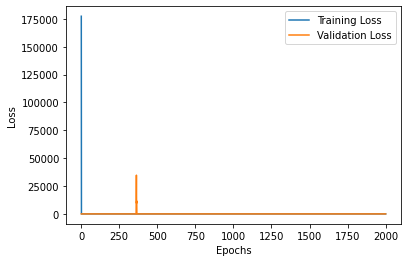

157/157 [==============================] - 6s 36ms/step - loss: -5.0747


157/157 [==============================] - 6s 37ms/step - loss: -5.3994


Epoch 1/2000
118/118 [==============================] - ETA: 0s - loss: -1.0012

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel10/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel10/assets


118/118 [==============================] - 34s 261ms/step - loss: -1.0012 - val_loss: 0.3250
Epoch 2/2000
118/118 [==============================] - 22s 183ms/step - loss: -1.2534 - val_loss: 0.4871
Epoch 3/2000
118/118 [==============================] - 22s 184ms/step - loss: -1.2557 - val_loss: 0.5731
Epoch 4/2000
118/118 [==============================] - 22s 183ms/step - loss: -1.2578 - val_loss: 0.5764
Epoch 5/2000
118/118 [==============================] - 22s 183ms/step - loss: -1.2591 - val_loss: 0.4818
Epoch 6/2000
118/118 [==============================] - 22s 183ms/step - loss: -1.2605 - val_loss: 0.5085
Epoch 7/2000
118/118 [==============================] - ETA: 0s - loss: -1.2598

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel10/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel10/assets


118/118 [==============================] - 28s 240ms/step - loss: -1.2598 - val_loss: 0.3030
Epoch 8/2000
118/118 [==============================] - 22s 183ms/step - loss: -1.2609 - val_loss: 0.5086
Epoch 9/2000
118/118 [==============================] - 22s 183ms/step - loss: -1.2608 - val_loss: 0.6784
Epoch 10/2000
118/118 [==============================] - 22s 184ms/step - loss: -1.2615 - val_loss: 0.4185
Epoch 11/2000
118/118 [==============================] - ETA: 0s - loss: -1.2613

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel10/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel10/assets


118/118 [==============================] - 30s 256ms/step - loss: -1.2613 - val_loss: 0.2706
Epoch 12/2000
118/118 [==============================] - 22s 183ms/step - loss: -1.2619 - val_loss: 0.5401
Epoch 13/2000
118/118 [==============================] - ETA: 0s - loss: -1.2617

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel10/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel10/assets


118/118 [==============================] - 28s 241ms/step - loss: -1.2617 - val_loss: 0.2686
Epoch 14/2000
118/118 [==============================] - 22s 183ms/step - loss: -1.2606 - val_loss: 0.7627
Epoch 15/2000
118/118 [==============================] - 22s 183ms/step - loss: -1.2599 - val_loss: 0.5222
Epoch 16/2000
118/118 [==============================] - 22s 183ms/step - loss: -1.2618 - val_loss: 0.6802
Epoch 17/2000
118/118 [==============================] - 22s 184ms/step - loss: -1.2616 - val_loss: 0.6253
Epoch 18/2000
118/118 [==============================] - 22s 183ms/step - loss: -1.2647 - val_loss: 0.8049
Epoch 19/2000
118/118 [==============================] - ETA: 0s - loss: -1.9913

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel10/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel10/assets


118/118 [==============================] - 30s 254ms/step - loss: -1.9913 - val_loss: -0.5364
Epoch 20/2000
118/118 [==============================] - ETA: 0s - loss: -2.8177

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel10/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel10/assets


118/118 [==============================] - 28s 239ms/step - loss: -2.8177 - val_loss: -2.6009
Epoch 21/2000
118/118 [==============================] - 22s 183ms/step - loss: -3.0416 - val_loss: -2.1706
Epoch 22/2000
118/118 [==============================] - ETA: 0s - loss: -3.2800

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel10/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel10/assets


118/118 [==============================] - 30s 255ms/step - loss: -3.2800 - val_loss: -3.0837
Epoch 23/2000
118/118 [==============================] - ETA: 0s - loss: -3.4861

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel10/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel10/assets


118/118 [==============================] - 28s 240ms/step - loss: -3.4861 - val_loss: -3.1362
Epoch 24/2000
118/118 [==============================] - 22s 185ms/step - loss: -3.6822 - val_loss: -3.0851
Epoch 25/2000
118/118 [==============================] - 22s 184ms/step - loss: -3.8052 - val_loss: -2.6710
Epoch 26/2000
118/118 [==============================] - ETA: 0s - loss: -3.8382

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel10/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel10/assets


118/118 [==============================] - 30s 256ms/step - loss: -3.8382 - val_loss: -3.5514
Epoch 27/2000
118/118 [==============================] - 21s 181ms/step - loss: -3.8214 - val_loss: -3.4100
Epoch 28/2000
118/118 [==============================] - 21s 182ms/step - loss: -3.9527 - val_loss: -3.5014
Epoch 29/2000
118/118 [==============================] - 22s 184ms/step - loss: -3.9566 - val_loss: -3.4703
Epoch 30/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.0254 - val_loss: -2.3339
Epoch 31/2000
118/118 [==============================] - ETA: 0s - loss: -4.0612

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel10/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel10/assets


118/118 [==============================] - 28s 238ms/step - loss: -4.0612 - val_loss: -3.6599
Epoch 32/2000
118/118 [==============================] - 22s 182ms/step - loss: -4.0642 - val_loss: -3.0830
Epoch 33/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.1522 - val_loss: -3.6225
Epoch 34/2000
118/118 [==============================] - ETA: 0s - loss: -4.1401

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel10/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel10/assets


118/118 [==============================] - 30s 255ms/step - loss: -4.1401 - val_loss: -3.7183
Epoch 35/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.1891 - val_loss: -3.2372
Epoch 36/2000
118/118 [==============================] - ETA: 0s - loss: -4.2230

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel10/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel10/assets


118/118 [==============================] - 28s 239ms/step - loss: -4.2230 - val_loss: -3.7220
Epoch 37/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.1881 - val_loss: -3.1074
Epoch 38/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.2155 - val_loss: -2.9540
Epoch 39/2000
118/118 [==============================] - ETA: 0s - loss: -4.2694

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel10/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel10/assets


118/118 [==============================] - 30s 254ms/step - loss: -4.2694 - val_loss: -3.8743
Epoch 40/2000
118/118 [==============================] - 22s 182ms/step - loss: -4.2749 - val_loss: -3.8454
Epoch 41/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.1311 - val_loss: -2.2899
Epoch 42/2000
118/118 [==============================] - 21s 182ms/step - loss: -4.3372 - val_loss: -3.8225
Epoch 43/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.2959 - val_loss: -3.6915
Epoch 44/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.3008 - val_loss: -3.7442
Epoch 45/2000
118/118 [==============================] - ETA: 0s - loss: -4.3817

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel10/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel10/assets


118/118 [==============================] - 28s 240ms/step - loss: -4.3817 - val_loss: -3.9182
Epoch 46/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.3007 - val_loss: -3.6665
Epoch 47/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.3866 - val_loss: -3.8931
Epoch 48/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.3947 - val_loss: -3.5491
Epoch 49/2000
118/118 [==============================] - ETA: 0s - loss: -4.4082

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel10/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel10/assets


118/118 [==============================] - 30s 255ms/step - loss: -4.4082 - val_loss: -3.9701
Epoch 50/2000
118/118 [==============================] - ETA: 0s - loss: -4.3763

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel10/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel10/assets


118/118 [==============================] - 30s 252ms/step - loss: -4.3763 - val_loss: -3.9905
Epoch 51/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.3741 - val_loss: -3.8918
Epoch 52/2000
118/118 [==============================] - 22s 182ms/step - loss: -4.4643 - val_loss: -3.9445
Epoch 53/2000
118/118 [==============================] - 22s 182ms/step - loss: -4.4633 - val_loss: -3.4230
Epoch 54/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.2724 - val_loss: -3.8796
Epoch 55/2000
118/118 [==============================] - ETA: 0s - loss: -4.4796

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel10/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel10/assets


118/118 [==============================] - 28s 240ms/step - loss: -4.4796 - val_loss: -4.0122
Epoch 56/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.4657 - val_loss: -3.9076
Epoch 57/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.4803 - val_loss: -3.9601
Epoch 58/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.5221 - val_loss: -3.8785
Epoch 59/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.4722 - val_loss: -3.9022
Epoch 60/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.4402 - val_loss: -3.6693
Epoch 61/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.4154 - val_loss: -3.8245
Epoch 62/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.5253 - val_loss: -3.9768
Epoch 63/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.4943 - val_loss: -3.4979
Epoch 64/2000
118/118 [===================

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel10/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel10/assets


118/118 [==============================] - 30s 256ms/step - loss: -4.6003 - val_loss: -4.0198
Epoch 69/2000
118/118 [==============================] - 22s 182ms/step - loss: -4.4469 - val_loss: -3.3242
Epoch 70/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.5609 - val_loss: -1.9379
Epoch 71/2000
118/118 [==============================] - ETA: 0s - loss: -4.4366

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel10/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel10/assets


118/118 [==============================] - 28s 240ms/step - loss: -4.4366 - val_loss: -4.0376
Epoch 72/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.5325 - val_loss: -3.6156
Epoch 73/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.5292 - val_loss: -3.8782
Epoch 74/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.5613 - val_loss: -3.3467
Epoch 75/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.4003 - val_loss: -3.7026
Epoch 76/2000
118/118 [==============================] - ETA: 0s - loss: -4.6128

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel10/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel10/assets


118/118 [==============================] - 30s 254ms/step - loss: -4.6128 - val_loss: -4.0808
Epoch 77/2000
118/118 [==============================] - 22s 182ms/step - loss: -4.4791 - val_loss: -3.8920
Epoch 78/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.4784 - val_loss: -2.1141
Epoch 79/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.4873 - val_loss: -4.0592
Epoch 80/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.5511 - val_loss: -2.9416
Epoch 81/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.4866 - val_loss: -3.4326
Epoch 82/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.5578 - val_loss: -3.1044
Epoch 83/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.6054 - val_loss: -4.0091
Epoch 84/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.6242 - val_loss: -3.9870
Epoch 85/2000
118/118 [===================

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel10/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel10/assets


118/118 [==============================] - 28s 239ms/step - loss: -4.6117 - val_loss: -4.0810
Epoch 97/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.5330 - val_loss: -3.9104
Epoch 98/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.6314 - val_loss: -3.5348
Epoch 99/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.4102 - val_loss: -3.4207
Epoch 100/2000
118/118 [==============================] - 22s 182ms/step - loss: -4.6369 - val_loss: -3.1424
Epoch 101/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.3570 - val_loss: -4.0801
Epoch 102/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.6404 - val_loss: -3.0871
Epoch 103/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.4425 - val_loss: -3.4355
Epoch 104/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.6663 - val_loss: -3.1218
Epoch 105/2000
118/118 [=============

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel10/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel10/assets


118/118 [==============================] - 30s 256ms/step - loss: -4.6706 - val_loss: -4.1437
Epoch 107/2000
118/118 [==============================] - ETA: 0s - loss: -4.6299

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel10/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel10/assets


118/118 [==============================] - 28s 241ms/step - loss: -4.6299 - val_loss: -4.1759
Epoch 108/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.6224 - val_loss: -3.7411
Epoch 109/2000
118/118 [==============================] - 21s 182ms/step - loss: -4.6861 - val_loss: -3.8323
Epoch 110/2000
118/118 [==============================] - 22s 182ms/step - loss: -4.6398 - val_loss: -3.6735
Epoch 111/2000
118/118 [==============================] - 21s 182ms/step - loss: -4.6813 - val_loss: -2.2163
Epoch 112/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.5332 - val_loss: -2.8570
Epoch 113/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.6491 - val_loss: -3.6475
Epoch 114/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.7347 - val_loss: -4.0635
Epoch 115/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.6554 - val_loss: -3.3019
Epoch 116/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel10/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel10/assets


118/118 [==============================] - 30s 254ms/step - loss: -4.6836 - val_loss: -4.2004
Epoch 119/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.6740 - val_loss: -1.0071
Epoch 120/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.7148 - val_loss: -4.1602
Epoch 121/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.6069 - val_loss: -3.9784
Epoch 122/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.6724 - val_loss: -3.5254
Epoch 123/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.6883 - val_loss: -3.8405
Epoch 124/2000
118/118 [==============================] - 21s 182ms/step - loss: -4.6999 - val_loss: -2.3558
Epoch 125/2000
118/118 [==============================] - 21s 182ms/step - loss: -4.6998 - val_loss: -4.1276
Epoch 126/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.6796 - val_loss: -3.7655
Epoch 127/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel10/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel10/assets


118/118 [==============================] - 28s 241ms/step - loss: -4.7738 - val_loss: -4.2404
Epoch 155/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.6371 - val_loss: -3.9085
Epoch 156/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.7399 - val_loss: -2.9003
Epoch 157/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.7085 - val_loss: -3.8248
Epoch 158/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.7911 - val_loss: -4.1195
Epoch 159/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.7359 - val_loss: -2.6938
Epoch 160/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.7017 - val_loss: 1.2678
Epoch 161/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.6884 - val_loss: -3.6123
Epoch 162/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.7766 - val_loss: -3.6683
Epoch 163/2000
118/118 [===========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel10/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel10/assets


118/118 [==============================] - 30s 254ms/step - loss: -4.5660 - val_loss: -4.2872
Epoch 206/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.7645 - val_loss: -3.9413
Epoch 207/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.7539 - val_loss: -4.1456
Epoch 208/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.7759 - val_loss: -4.0436
Epoch 209/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.8750 - val_loss: -3.0070
Epoch 210/2000
118/118 [==============================] - 21s 182ms/step - loss: -4.8037 - val_loss: -3.1899
Epoch 211/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.8624 - val_loss: -2.6478
Epoch 212/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.5764 - val_loss: -4.2515
Epoch 213/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.8834 - val_loss: -3.7731
Epoch 214/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel10/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel10/assets


118/118 [==============================] - 28s 239ms/step - loss: -4.8493 - val_loss: -4.3231
Epoch 227/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.7963 - val_loss: -4.0298
Epoch 228/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.8343 - val_loss: -4.1251
Epoch 229/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.8640 - val_loss: -2.9640
Epoch 230/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.3457 - val_loss: -4.0983
Epoch 231/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.7623 - val_loss: -4.2031
Epoch 232/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.8410 - val_loss: -4.0123
Epoch 233/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.7864 - val_loss: -4.0791
Epoch 234/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.8528 - val_loss: -3.9504
Epoch 235/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel10/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel10/assets


118/118 [==============================] - 30s 255ms/step - loss: -4.9402 - val_loss: -4.3348
Epoch 273/2000
118/118 [==============================] - 21s 182ms/step - loss: -4.8867 - val_loss: -4.0858
Epoch 274/2000
118/118 [==============================] - 21s 181ms/step - loss: -4.8603 - val_loss: -4.1515
Epoch 275/2000
118/118 [==============================] - 22s 183ms/step - loss: -3.7602 - val_loss: -3.1151
Epoch 276/2000
118/118 [==============================] - 21s 181ms/step - loss: -4.5966 - val_loss: -3.2151
Epoch 277/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.7549 - val_loss: -3.4978
Epoch 278/2000
118/118 [==============================] - 21s 181ms/step - loss: -4.7464 - val_loss: -4.0838
Epoch 279/2000
118/118 [==============================] - 21s 182ms/step - loss: -4.8250 - val_loss: -4.1257
Epoch 280/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.8295 - val_loss: -3.8181
Epoch 281/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel10/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel10/assets


118/118 [==============================] - 30s 253ms/step - loss: -4.7237 - val_loss: -4.3550
Epoch 289/2000
118/118 [==============================] - ETA: 0s - loss: -4.9392

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel10/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel10/assets


118/118 [==============================] - 28s 238ms/step - loss: -4.9392 - val_loss: -4.3839
Epoch 290/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.9329 - val_loss: -3.3886
Epoch 291/2000
118/118 [==============================] - 22s 182ms/step - loss: -4.8576 - val_loss: -3.9341
Epoch 292/2000
118/118 [==============================] - 22s 182ms/step - loss: -4.8270 - val_loss: -3.9236
Epoch 293/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.9858 - val_loss: -3.9433
Epoch 294/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.8966 - val_loss: -3.7300
Epoch 295/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.8974 - val_loss: -4.1928
Epoch 296/2000
118/118 [==============================] - 21s 182ms/step - loss: -4.8288 - val_loss: -3.3528
Epoch 297/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.9371 - val_loss: -3.4475
Epoch 298/2000
118/118 [==========

118/118 [==============================] - 22s 184ms/step - loss: -4.7786 - val_loss: -4.2859
Epoch 440/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.9598 - val_loss: -4.3033
Epoch 441/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.9218 - val_loss: -3.6584
Epoch 442/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.8111 - val_loss: -4.3041
Epoch 443/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.9795 - val_loss: -2.6296
Epoch 444/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.9196 - val_loss: -4.1532
Epoch 445/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.9184 - val_loss: -4.3451
Epoch 446/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.9872 - val_loss: -4.2858
Epoch 447/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.9060 - val_loss: -4.1369
Epoch 448/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel10/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel10/assets


118/118 [==============================] - 30s 258ms/step - loss: -5.0372 - val_loss: -4.5472
Epoch 457/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.9222 - val_loss: -3.5701
Epoch 458/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.0765 - val_loss: -3.6508
Epoch 459/2000
118/118 [==============================] - 22s 182ms/step - loss: -4.7504 - val_loss: -2.7938
Epoch 460/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.0308 - val_loss: -3.9866
Epoch 461/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.9632 - val_loss: -3.9991
Epoch 462/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.0337 - val_loss: -4.3342
Epoch 463/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.0220 - val_loss: -3.5921
Epoch 464/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.9307 - val_loss: -4.0829
Epoch 465/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel10/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel10/assets


118/118 [==============================] - 28s 240ms/step - loss: -5.1019 - val_loss: -4.6011
Epoch 572/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.1397 - val_loss: -2.0235
Epoch 573/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.0498 - val_loss: -4.4870
Epoch 574/2000
118/118 [==============================] - 22s 187ms/step - loss: -4.9819 - val_loss: -3.3698
Epoch 575/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.0747 - val_loss: -4.4444
Epoch 576/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.0664 - val_loss: -4.1827
Epoch 577/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.1223 - val_loss: -3.0322
Epoch 578/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.0976 - val_loss: -3.8980
Epoch 579/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.1086 - val_loss: -3.9266
Epoch 580/2000
118/118 [==========

118/118 [==============================] - 22s 184ms/step - loss: -5.1501 - val_loss: -4.1726
Epoch 722/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.2415 - val_loss: -2.9393
Epoch 723/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.0385 - val_loss: -3.0027
Epoch 724/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.1928 - val_loss: -2.9730
Epoch 725/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.0216 - val_loss: -4.3895
Epoch 726/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.1911 - val_loss: -3.9236
Epoch 727/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.1806 - val_loss: -4.1150
Epoch 728/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.2114 - val_loss: -4.1284
Epoch 729/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.1345 - val_loss: -4.2762
Epoch 730/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel10/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel10/assets


118/118 [==============================] - 30s 255ms/step - loss: -5.1695 - val_loss: -4.6054
Epoch 791/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.2699 - val_loss: -4.5223
Epoch 792/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.2119 - val_loss: -4.2661
Epoch 793/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.2056 - val_loss: -4.1982
Epoch 794/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.0615 - val_loss: -4.3527
Epoch 795/2000
118/118 [==============================] - 21s 182ms/step - loss: -5.1782 - val_loss: -4.1372
Epoch 796/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.2096 - val_loss: -4.0448
Epoch 797/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.1544 - val_loss: -4.2467
Epoch 798/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.7240 - val_loss: -4.3016
Epoch 799/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel10/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel10/assets


118/118 [==============================] - 28s 239ms/step - loss: -5.3237 - val_loss: -4.7183
Epoch 889/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.8305 - val_loss: -4.3384
Epoch 890/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.2339 - val_loss: -4.0622
Epoch 891/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.2668 - val_loss: -3.3743
Epoch 892/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.2817 - val_loss: -2.5706
Epoch 893/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.2357 - val_loss: -4.0994
Epoch 894/2000
118/118 [==============================] - 21s 182ms/step - loss: -5.2652 - val_loss: -3.9573
Epoch 895/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.2195 - val_loss: -3.4234
Epoch 896/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.0965 - val_loss: -4.6284
Epoch 897/2000
118/118 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel10/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel10/assets


118/118 [==============================] - 30s 256ms/step - loss: -5.3521 - val_loss: -4.8641
Epoch 941/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.2023 - val_loss: -4.4105
Epoch 942/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.2925 - val_loss: -3.2011
Epoch 943/2000
118/118 [==============================] - 22s 182ms/step - loss: -5.3157 - val_loss: -3.5118
Epoch 944/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.3244 - val_loss: -2.9679
Epoch 945/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.6084 - val_loss: -4.3565
Epoch 946/2000
118/118 [==============================] - 21s 181ms/step - loss: -5.2146 - val_loss: -4.0334
Epoch 947/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.2052 - val_loss: -2.9732
Epoch 948/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.1988 - val_loss: -3.9856
Epoch 949/2000
118/118 [==========

118/118 [==============================] - 22s 183ms/step - loss: -5.3631 - val_loss: -3.6197
Epoch 1090/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.3299 - val_loss: -3.7876
Epoch 1091/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.2881 - val_loss: -4.6221
Epoch 1092/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.3794 - val_loss: -3.2598
Epoch 1093/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.2709 - val_loss: -2.9894
Epoch 1094/2000
118/118 [==============================] - 22s 185ms/step - loss: -5.2877 - val_loss: -3.7365
Epoch 1095/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.3538 - val_loss: -3.4236
Epoch 1096/2000
118/118 [==============================] - 22s 183ms/step - loss: -5.3006 - val_loss: -3.9865
Epoch 1097/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.3064 - val_loss: -4.0285
Epoch 1098/2000
118/118 [=

118/118 [==============================] - 22s 185ms/step - loss: -4.9672 - val_loss: -4.0164
Epoch 1238/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.7737 - val_loss: -4.3745
Epoch 1239/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.7844 - val_loss: -4.2746
Epoch 1240/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.9465 - val_loss: -2.8277
Epoch 1241/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.8238 - val_loss: -4.0964
Epoch 1242/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.8984 - val_loss: -4.1645
Epoch 1243/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.7886 - val_loss: -3.9999
Epoch 1244/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.3330 - val_loss: -4.3382
Epoch 1245/2000
118/118 [==============================] - 22s 184ms/step - loss: -2.8830 - val_loss: -2.2883
Epoch 1246/2000
118/118 [=

118/118 [==============================] - 22s 183ms/step - loss: -4.3518 - val_loss: -3.6889
Epoch 1386/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.5364 - val_loss: -4.1077
Epoch 1387/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.6276 - val_loss: -3.3414
Epoch 1388/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.4825 - val_loss: -4.0017
Epoch 1389/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.6084 - val_loss: -3.1384
Epoch 1390/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.6150 - val_loss: -3.0056
Epoch 1391/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.4598 - val_loss: -3.8593
Epoch 1392/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.5124 - val_loss: -3.9155
Epoch 1393/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.5777 - val_loss: -4.0408
Epoch 1394/2000
118/118 [=

118/118 [==============================] - 22s 184ms/step - loss: -4.7575 - val_loss: -4.0183
Epoch 1534/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.0493 - val_loss: -3.9583
Epoch 1535/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.8428 - val_loss: -3.8815
Epoch 1536/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.7546 - val_loss: -4.1555
Epoch 1537/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.7606 - val_loss: -4.1878
Epoch 1538/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.7384 - val_loss: -4.1965
Epoch 1539/2000
118/118 [==============================] - 22s 186ms/step - loss: -4.7551 - val_loss: -4.0360
Epoch 1540/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.6034 - val_loss: -3.4707
Epoch 1541/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.7299 - val_loss: -4.3563
Epoch 1542/2000
118/118 [=

118/118 [==============================] - 22s 184ms/step - loss: -3.8596 - val_loss: -3.6493
Epoch 1682/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.6023 - val_loss: -3.6386
Epoch 1683/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.7628 - val_loss: -3.9376
Epoch 1684/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.7024 - val_loss: -3.2431
Epoch 1685/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.8687 - val_loss: -3.8322
Epoch 1686/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.8696 - val_loss: -4.1777
Epoch 1687/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.7866 - val_loss: -4.1839
Epoch 1688/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.8631 - val_loss: -4.1608
Epoch 1689/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.8743 - val_loss: -3.2460
Epoch 1690/2000
118/118 [=

118/118 [==============================] - 22s 183ms/step - loss: -4.7711 - val_loss: -3.6150
Epoch 1830/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.9012 - val_loss: -1.4042
Epoch 1831/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.9720 - val_loss: -4.1706
Epoch 1832/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.9764 - val_loss: -4.4896
Epoch 1833/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.8100 - val_loss: -3.6547
Epoch 1834/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.9904 - val_loss: -4.3471
Epoch 1835/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.7628 - val_loss: -4.3060
Epoch 1836/2000
118/118 [==============================] - 22s 186ms/step - loss: -5.0247 - val_loss: -4.1175
Epoch 1837/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.8991 - val_loss: -4.2087
Epoch 1838/2000
118/118 [=

118/118 [==============================] - 22s 184ms/step - loss: -4.9651 - val_loss: -4.1273
Epoch 1978/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.9873 - val_loss: -4.2279
Epoch 1979/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.9689 - val_loss: -4.2291
Epoch 1980/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.9929 - val_loss: -2.4581
Epoch 1981/2000
118/118 [==============================] - 22s 185ms/step - loss: -4.9092 - val_loss: -4.3029
Epoch 1982/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.0238 - val_loss: -1.3395
Epoch 1983/2000
118/118 [==============================] - 22s 184ms/step - loss: -4.9641 - val_loss: -4.1155
Epoch 1984/2000
118/118 [==============================] - 22s 184ms/step - loss: -5.0205 - val_loss: -4.2449
Epoch 1985/2000
118/118 [==============================] - 22s 183ms/step - loss: -4.9909 - val_loss: -3.6896
Epoch 1986/2000
118/118 [=

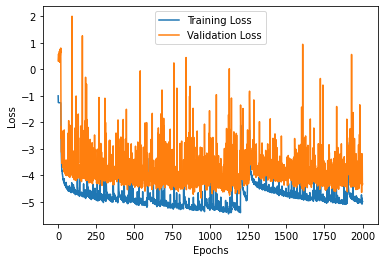

157/157 [==============================] - 6s 37ms/step - loss: -4.8975


157/157 [==============================] - 6s 36ms/step - loss: -5.3082


In [2]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import math
from LSTMutils import MeanVarianceLogLikelyhoodLoss
from sklearn.model_selection import train_test_split

np.random.seed(42)
tf.random.set_seed(42)

NumEnsemble = 10
SequenceLength = 250
validation_split = 0.1
batch_size = 64
NumEpochs = 2000

df = pd.read_csv(r"../TrainingData/SimulatedTrainingSet10000.csv",sep=',',header=0)

labels = df.iloc[:,0]
df_data = df.iloc[:,1:]

df_train, df_val = train_test_split(df_data, test_size=validation_split, train_size=1-validation_split, random_state=42, shuffle=True, stratify=labels)

# normalise time series data
min_value, max_value = df_train.min().min(), df_train.max().max()
df_norm_train = (df_train - min_value)/(max_value - min_value)
df_norm_test = (df_test - min_value)/(max_value - min_value)
df_norm_val = (df_val - min_value)/(max_value - min_value)

models = list()

for i in range(NumEnsemble):
    
    df_norm_train = df_norm_train.sample(frac=1)
    df_norm_val = df_norm_val.sample(frac=1)
    
    X_train = df_norm_train.iloc[:,:SequenceLength].values
    y_train = df_norm_train.iloc[:,SequenceLength-1].values
    X_train = np.expand_dims(X_train, 2)
    y_train = np.broadcast_to(y_train[:,None], (y_train.shape[0],SequenceLength))
    y_train = np.expand_dims(y_train, 2)

    X_val = df_norm_val.iloc[:,:SequenceLength].values
    y_val = df_norm_val.iloc[:,SequenceLength-1].values
    X_val = np.expand_dims(X_val, 2)
    y_val = np.broadcast_to(y_val[:,None], (y_val.shape[0],SequenceLength))
    y_val = np.expand_dims(y_val, 2)
    
    print("model number " + str(i+1))
    
    model = keras.models.Sequential([keras.layers.LSTM(50, input_shape=(SequenceLength,1), return_sequences=True, stateful=False)
                                     , keras.layers.LSTM(200, return_sequences=True, stateful=False)
                                     , keras.layers.LSTM(50, return_sequences=True, stateful=False)
                                     , keras.layers.LSTM(10, return_sequences=True, stateful=False)
                                     , keras.layers.LSTM(2, activation='softplus', return_sequences=True, stateful=False)])

    

    checkpoint_filepath = r"../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel" + str(i+1)
    
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        monitor='val_loss',
        mode='min',
        save_best_only=True)
        
    model.compile(optimizer="adam",loss = MeanVarianceLogLikelyhoodLoss)

    history = model.fit(X_train, y_train, batch_size=batch_size, validation_split=validation_split, epochs=NumEpochs, callbacks=[model_checkpoint_callback,keras.callbacks.TerminateOnNaN()])

    loss_values = history.history['loss']
    val_loss_values = history.history['val_loss']
    epochs = range(1, len(loss_values)+1)
    plt.plot(epochs, loss_values, label='Training Loss')
    plt.plot(epochs, val_loss_values, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

    model.evaluate(X_train,y_train,batch_size=batch_size) #min loss shold be -6.908
    
    bestModel = keras.models.load_model(checkpoint_filepath, custom_objects={"MeanVarianceLogLikelyhoodLoss": MeanVarianceLogLikelyhoodLoss})
    bestModel.evaluate(X_train, y_train, batch_size=batch_size)
    print(str(i+1)+" models complete")
    
    models.append(model)